In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime
import koleksyon.mcmc as mcmc
import koleksyon.lib as ll

/Users/m102417/workspace/koleksyon/src/koleksyon/lib.py:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if missing_strategy is "droprow":
/Users/m102417/workspace/koleksyon/src/koleksyon/lib.py:217: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if missing_strategy is "dropcol":
/Users/m102417/workspace/koleksyon/src/koleksyon/lib.py:219: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if missing_strategy is "fillna":
/Users/m102417/workspace/koleksyon/src/koleksyon/lib.py:286: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.model_type is 'regressor':
/Users/m102417/workspace/koleksyon/src/koleksyon/lib.py:288: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.model_type is 'classifier':


# Generative Processes
A generative process, as the name suggests, is a process that generates data.  Most of the time we don't know the true process that generated the data.  That true process often contains human decision making, automation that must be treated as a black box, and other natural and unwieldy phenomenon, that are practically impossible to replicate in the computer.  Simulation is the art and science of replicating these processes as close as practical IN THE COMPUTER.  Simulation is helpful because a simulator that accurately creates data with the same properties of the original process can be used in prediction or hypotheticals analysis to overcome common operations difficulties.

In this example, we have a dataset obtained from Wikipedia that represents raw page hits for the top 10 most visited artist pages on Wikipedia.

In [2]:
df = pd.read_csv("../../data/artist_wiki_page_views-20200101-20201231.csv")
#just filter down for unit tests...
#c1 = df['Date'].str.contains("2020-01-15")
#c2 = df['Date'].str.contains("2020-02-15")
#c3 = df['Date'].str.contains("2020-03-15")
#df[c1 | c2 | c3]
df

,Date,Michael Jackson,Lady Gaga,Eminem,Justin Bieber,Freddie Mercury,Miley Cyrus,Taylor Swift,Lil Wayne,Selena Gomez,Rihanna
0,2020-01-01,21038,22389,13759,23381,56040,14637,16590,7227,12438,12910
1,2020-01-02,20329,15388,13410,17343,30616,13740,16348,6685,14066,11768
2,2020-01-03,17898,12594,13261,27848,26525,13022,15114,7084,13743,11642
3,2020-01-04,19730,15138,12654,26521,32327,12787,15510,6752,14289,10713
4,2020-01-05,18258,16869,12464,26873,33256,13134,13930,6005,12876,12117
...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,31174,17420,20628,15948,30931,15313,23266,5693,12686,14938
362,2020-12-28,28684,15396,22890,17813,20466,14838,22045,5830,12818,12928
363,2020-12-29,26743,13908,22566,18367,18450,14677,20761,5977,12168,13051
364,2020-12-30,23520,13250,20690,17613,18447,14397,19691,5662,12326,14758


Notice how the structure of this data is NOT consistent with most generative processes such as server logs, call logs, encounters, usage logs, sales receipts, and so on.  Its pure summary data.  Most raw datasets have a form that represents a generative process, but many of these datasets are not shared because of the confidential nature, the business value, and the large size.  In this case, we will make up a dataset that has the correct form based on a 'made up' process.  Data Scientists in industry should notice immediately a similarity between this dataset and datasets we commonly encounter.

The first step in making our dataset is to extract album prices from a well known retailer (Dec 2020):

In [3]:
#Artist-Album costs (0.0 represents that you don't buy and albumn, .99 represents you buy just a song)
MichaelJackson = np.array([0.0,0.99,8.64,8.69,12.33,12.96,38.99,30.12,13.99,17.25])
LadyGaga = np.array([0.0,0.99,14.28,11.20,11.25,14.98,13.69,9.99,18.95])
Eminem = np.array([0.0,0.99,15.99,9.33,21.61,22.37,12.80,10.75,11.70])
JustinBieber = np.array([0.0,0.99,10.70,9.49,14.65,29.18,21.93,15.95,19.90,37.98])
FreddieMercury = np.array([0.0,0.99,14.74,11.50,18.99,12.49,14.54,10.99,11.89,16.53,11.70,9.71,12.39])
MileyCyrus = np.array([0.0,0.99,11.18,6.98,9.21,9.95,9.49])
TaylorSwift = np.array([0.0,0.99,13.98,16.99,13.51,8.97,15.02,7.00,13.97,8.97,6.86])
LilWayne = np.array([0.0,0.99,11.55,16.00,29.47,13.41,9.68,15.95,11.99,16.63])
SelenaGomez = np.array([0.0,0.99,12.59,10.91,36.57,16.52])
Rihanna = np.array([0.0,0.99,13.98,10.25,22.90,6.32,9.19])
ArtistAlbums = {}
ArtistAlbums["Michael Jackson"] = MichaelJackson
ArtistAlbums["Lady Gaga"] = LadyGaga
ArtistAlbums["Eminem"] = Eminem
ArtistAlbums["Justin Bieber"] = JustinBieber
ArtistAlbums["Freddie Mercury"] = FreddieMercury
ArtistAlbums["Miley Cyrus"] = MileyCyrus
ArtistAlbums["Taylor Swift"] = TaylorSwift
ArtistAlbums["Lil Wayne"] = LilWayne
ArtistAlbums["Selena Gomez"] = SelenaGomez
ArtistAlbums["Rihanna"] = Rihanna
             

For this example, we will assume that people check Wikipedia for one of the above artists, and then a certain percent of them (1%) order music from our retailer.  A careful look at the data shows that there are 'influencer' spikes that likely go with a new album release, a news story, a tour or other activity that generates 'buzz'.   We don't know what the price of new products, or when the price of existing processes are going to change.  We also don't know without real logs the overall interest in a given albumn over time.  All of these different variables are examples of 'black box' variables that we wish to be able to simulate.  The fact that so many of these variables are so difficult to pin down is really the point!

For the current task, creating a dataset with approximately the correct structure, we will assume that 50% of visits result in a purchase, and of those, 50% (25% of total) just buy a single song (0.99 cents).  The final number purchases is distributed equally between the existing albums.

In [4]:
purchase_probability = {}
for k,v in ArtistAlbums.items():
    print(k)
    print(v)
    proba = []
    proba.append(0.50)  #50% purchases, 50% not purchases
    proba.append(0.25)
    r =  0.25 / (len(v) - 2)
    for i in range(0,len(v)-2):
        proba.append(r)
    proba = np.array(proba)
    print(proba)
    purchase_probability[k] = proba

Michael Jackson
[ 0.    0.99  8.64  8.69 12.33 12.96 38.99 30.12 13.99 17.25]
[0.5     0.25    0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125]
Lady Gaga
[ 0.    0.99 14.28 11.2  11.25 14.98 13.69  9.99 18.95]
[0.5        0.25       0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429]
Eminem
[ 0.    0.99 15.99  9.33 21.61 22.37 12.8  10.75 11.7 ]
[0.5        0.25       0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429]
Justin Bieber
[ 0.    0.99 10.7   9.49 14.65 29.18 21.93 15.95 19.9  37.98]
[0.5     0.25    0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125]
Freddie Mercury
[ 0.    0.99 14.74 11.5  18.99 12.49 14.54 10.99 11.89 16.53 11.7   9.71
 12.39]
[0.5        0.25       0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727]
Miley Cyrus
[ 0.    0.99 11.18  6.98  9.21  9.95  9.49]
[0.5  0.25 0.05 0.05 0.05 0.05 0.05]
Taylor Swi

In [5]:
#generate a dataframe shaped like a purchase log for a single cell in the page view table
def generate_amounts(artist, date, count):
    amounts = np.random.choice(ArtistAlbums[artist], count, p=purchase_probability[artist])
    df = pd.DataFrame(data=amounts,  columns=["amount"])
    df['artist'] = artist 
    df['date'] = date
    return df


In [6]:
dflog = pd.DataFrame(columns=['date', 'artist', 'amount'])
dflog = dflog.append({'date':"1-1-01",'artist':'MJ','amount':21.33}, ignore_index=True)
dflog

,date,artist,amount
0,1-1-01,MJ,21.33


In [7]:
scale_factor = 1000 #if scale factor == 1, dataset will be true size, 10==one tenth the size, 100=one one hundreth ect.
def generate_log_data(df_page_view_counts):
    #iterate over the page view counts
    dflog = pd.DataFrame(columns=['date', 'artist', 'amount']) #dataframe to place the log
    rws, clms = df_page_view_counts.shape
    date_time = datetime.datetime.now()
    for i in range(rws):
        for col in list(df_page_view_counts.columns):
            if 'Date' in col:
                date_time = datetime.datetime.strptime(df_page_view_counts.at[i,col], '%Y-%m-%d')
                print(date_time)
            else:
                #print(df.iat[i,j])
                artist = col
                visits = int(df_page_view_counts.at[i,col])
                dfl = generate_amounts(artist, date_time, visits // scale_factor)
                print(dfl)
                dflog = dflog.append(dfl, ignore_index=True)
                print(len(dflog))
    dflog['date'] = pd.to_datetime(dflog['date'])
    return dflog

dflog = generate_log_data(df)

2020-01-01 00:00:00
    amount           artist       date
0    38.99  Michael Jackson 2020-01-01
1    12.96  Michael Jackson 2020-01-01
2     0.00  Michael Jackson 2020-01-01
3     8.69  Michael Jackson 2020-01-01
4     0.99  Michael Jackson 2020-01-01
5     0.99  Michael Jackson 2020-01-01
6     0.00  Michael Jackson 2020-01-01
7     0.99  Michael Jackson 2020-01-01
8     0.00  Michael Jackson 2020-01-01
9     0.00  Michael Jackson 2020-01-01
10   38.99  Michael Jackson 2020-01-01
11    0.00  Michael Jackson 2020-01-01
12    0.00  Michael Jackson 2020-01-01
13   12.96  Michael Jackson 2020-01-01
14    8.69  Michael Jackson 2020-01-01
15    0.00  Michael Jackson 2020-01-01
16    8.64  Michael Jackson 2020-01-01
17    0.00  Michael Jackson 2020-01-01
18   13.99  Michael Jackson 2020-01-01
19    0.99  Michael Jackson 2020-01-01
20    0.00  Michael Jackson 2020-01-01
21
    amount     artist       date
0    11.25  Lady Gaga 2020-01-01
1     0.99  Lady Gaga 2020-01-01
2     0.00  Lady Gag

17    0.00  Michael Jackson 2020-01-05
684
    amount     artist       date
0     0.00  Lady Gaga 2020-01-05
1     0.99  Lady Gaga 2020-01-05
2     0.00  Lady Gaga 2020-01-05
3    14.28  Lady Gaga 2020-01-05
4     0.99  Lady Gaga 2020-01-05
5     0.99  Lady Gaga 2020-01-05
6     0.99  Lady Gaga 2020-01-05
7    14.98  Lady Gaga 2020-01-05
8     0.00  Lady Gaga 2020-01-05
9     0.00  Lady Gaga 2020-01-05
10   18.95  Lady Gaga 2020-01-05
11    0.99  Lady Gaga 2020-01-05
12    0.00  Lady Gaga 2020-01-05
13    0.99  Lady Gaga 2020-01-05
14    0.99  Lady Gaga 2020-01-05
15   14.28  Lady Gaga 2020-01-05
700
    amount  artist       date
0     0.00  Eminem 2020-01-05
1     0.99  Eminem 2020-01-05
2     0.99  Eminem 2020-01-05
3     9.33  Eminem 2020-01-05
4     0.00  Eminem 2020-01-05
5     0.00  Eminem 2020-01-05
6     0.99  Eminem 2020-01-05
7    12.80  Eminem 2020-01-05
8    10.75  Eminem 2020-01-05
9     0.00  Eminem 2020-01-05
10    0.00  Eminem 2020-01-05
11    0.00  Eminem 2020-01-05
71

1365
   amount   artist       date
0    0.99  Rihanna 2020-01-09
1   22.90  Rihanna 2020-01-09
2    0.00  Rihanna 2020-01-09
3    0.99  Rihanna 2020-01-09
4    0.00  Rihanna 2020-01-09
5    0.00  Rihanna 2020-01-09
6   10.25  Rihanna 2020-01-09
7   22.90  Rihanna 2020-01-09
8    0.00  Rihanna 2020-01-09
1374
2020-01-10 00:00:00
    amount           artist       date
0    12.33  Michael Jackson 2020-01-10
1     0.00  Michael Jackson 2020-01-10
2     8.69  Michael Jackson 2020-01-10
3     0.00  Michael Jackson 2020-01-10
4    12.33  Michael Jackson 2020-01-10
5     8.64  Michael Jackson 2020-01-10
6     8.64  Michael Jackson 2020-01-10
7     0.99  Michael Jackson 2020-01-10
8    38.99  Michael Jackson 2020-01-10
9     0.00  Michael Jackson 2020-01-10
10    0.00  Michael Jackson 2020-01-10
11    0.00  Michael Jackson 2020-01-10
12    8.69  Michael Jackson 2020-01-10
13    0.00  Michael Jackson 2020-01-10
14    0.00  Michael Jackson 2020-01-10
15    0.99  Michael Jackson 2020-01-10
1390
  

2110
    amount        artist       date
0     0.00  Selena Gomez 2020-01-14
1     0.00  Selena Gomez 2020-01-14
2     0.99  Selena Gomez 2020-01-14
3     0.00  Selena Gomez 2020-01-14
4     0.00  Selena Gomez 2020-01-14
5     0.99  Selena Gomez 2020-01-14
6    12.59  Selena Gomez 2020-01-14
7     0.00  Selena Gomez 2020-01-14
8     0.00  Selena Gomez 2020-01-14
9     0.00  Selena Gomez 2020-01-14
10    0.99  Selena Gomez 2020-01-14
11   12.59  Selena Gomez 2020-01-14
12   16.52  Selena Gomez 2020-01-14
13    0.00  Selena Gomez 2020-01-14
14    0.00  Selena Gomez 2020-01-14
15    0.99  Selena Gomez 2020-01-14
16    0.00  Selena Gomez 2020-01-14
17    0.99  Selena Gomez 2020-01-14
18    0.99  Selena Gomez 2020-01-14
19   16.52  Selena Gomez 2020-01-14
20   12.59  Selena Gomez 2020-01-14
21    0.00  Selena Gomez 2020-01-14
22    0.00  Selena Gomez 2020-01-14
23    0.00  Selena Gomez 2020-01-14
24   10.91  Selena Gomez 2020-01-14
25    0.00  Selena Gomez 2020-01-14
26    0.00  Selena Gome

12    0.00  Eminem 2020-01-16
2328
    amount         artist       date
0    15.95  Justin Bieber 2020-01-16
1     0.00  Justin Bieber 2020-01-16
2     0.00  Justin Bieber 2020-01-16
3     0.00  Justin Bieber 2020-01-16
4    14.65  Justin Bieber 2020-01-16
5     0.00  Justin Bieber 2020-01-16
6     0.99  Justin Bieber 2020-01-16
7     0.99  Justin Bieber 2020-01-16
8     0.00  Justin Bieber 2020-01-16
9     0.00  Justin Bieber 2020-01-16
10    0.00  Justin Bieber 2020-01-16
11    0.00  Justin Bieber 2020-01-16
12    0.00  Justin Bieber 2020-01-16
13    0.99  Justin Bieber 2020-01-16
14    0.00  Justin Bieber 2020-01-16
2343
    amount           artist       date
0    18.99  Freddie Mercury 2020-01-16
1     0.00  Freddie Mercury 2020-01-16
2     0.99  Freddie Mercury 2020-01-16
3     0.00  Freddie Mercury 2020-01-16
4     0.00  Freddie Mercury 2020-01-16
5     0.99  Freddie Mercury 2020-01-16
6     0.00  Freddie Mercury 2020-01-16
7     0.99  Freddie Mercury 2020-01-16
8    11.50  Fredd

7    0.99  Lil Wayne 2020-01-19
3095
    amount        artist       date
0     0.00  Selena Gomez 2020-01-19
1     0.00  Selena Gomez 2020-01-19
2     0.00  Selena Gomez 2020-01-19
3     0.00  Selena Gomez 2020-01-19
4     0.99  Selena Gomez 2020-01-19
5     0.00  Selena Gomez 2020-01-19
6    36.57  Selena Gomez 2020-01-19
7    36.57  Selena Gomez 2020-01-19
8     0.00  Selena Gomez 2020-01-19
9     0.00  Selena Gomez 2020-01-19
10   16.52  Selena Gomez 2020-01-19
11    0.00  Selena Gomez 2020-01-19
12   16.52  Selena Gomez 2020-01-19
13    0.99  Selena Gomez 2020-01-19
14    0.99  Selena Gomez 2020-01-19
15   16.52  Selena Gomez 2020-01-19
16    0.00  Selena Gomez 2020-01-19
17    0.00  Selena Gomez 2020-01-19
3113
    amount   artist       date
0     9.19  Rihanna 2020-01-19
1     0.00  Rihanna 2020-01-19
2     0.00  Rihanna 2020-01-19
3     0.00  Rihanna 2020-01-19
4    13.98  Rihanna 2020-01-19
5    22.90  Rihanna 2020-01-19
6     0.99  Rihanna 2020-01-19
7    10.25  Rihanna 2020-0

3316
    amount  artist       date
0     0.00  Eminem 2020-01-21
1    12.80  Eminem 2020-01-21
2     0.00  Eminem 2020-01-21
3     0.00  Eminem 2020-01-21
4    15.99  Eminem 2020-01-21
5     0.00  Eminem 2020-01-21
6     0.99  Eminem 2020-01-21
7    10.75  Eminem 2020-01-21
8    21.61  Eminem 2020-01-21
9     0.00  Eminem 2020-01-21
10    0.00  Eminem 2020-01-21
11    0.00  Eminem 2020-01-21
12    0.00  Eminem 2020-01-21
13    0.00  Eminem 2020-01-21
14   11.70  Eminem 2020-01-21
15   11.70  Eminem 2020-01-21
16   12.80  Eminem 2020-01-21
17   11.70  Eminem 2020-01-21
18   10.75  Eminem 2020-01-21
19    0.00  Eminem 2020-01-21
20   10.75  Eminem 2020-01-21
21   12.80  Eminem 2020-01-21
22    0.00  Eminem 2020-01-21
23    0.00  Eminem 2020-01-21
24    0.00  Eminem 2020-01-21
25   10.75  Eminem 2020-01-21
26   10.75  Eminem 2020-01-21
27    0.99  Eminem 2020-01-21
28    0.99  Eminem 2020-01-21
29    0.99  Eminem 2020-01-21
30    9.33  Eminem 2020-01-21
31    0.00  Eminem 2020-01-21
32   

10    0.99  Lil Wayne 2020-01-24
3880
    amount        artist       date
0    12.59  Selena Gomez 2020-01-24
1    36.57  Selena Gomez 2020-01-24
2     0.99  Selena Gomez 2020-01-24
3     0.99  Selena Gomez 2020-01-24
4     0.00  Selena Gomez 2020-01-24
5     0.00  Selena Gomez 2020-01-24
6    10.91  Selena Gomez 2020-01-24
7     0.00  Selena Gomez 2020-01-24
8     0.99  Selena Gomez 2020-01-24
9     0.00  Selena Gomez 2020-01-24
10    0.00  Selena Gomez 2020-01-24
11    0.99  Selena Gomez 2020-01-24
12    0.00  Selena Gomez 2020-01-24
13    0.00  Selena Gomez 2020-01-24
3894
   amount   artist       date
0    0.99  Rihanna 2020-01-24
1    0.00  Rihanna 2020-01-24
2    0.00  Rihanna 2020-01-24
3    0.99  Rihanna 2020-01-24
4    0.99  Rihanna 2020-01-24
5    0.99  Rihanna 2020-01-24
6   22.90  Rihanna 2020-01-24
7    0.00  Rihanna 2020-01-24
8    0.00  Rihanna 2020-01-24
3903
2020-01-25 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-01-25
1    17.25  Mi

4144
    amount         artist       date
0     0.99  Justin Bieber 2020-01-26
1    10.70  Justin Bieber 2020-01-26
2     0.99  Justin Bieber 2020-01-26
3     0.00  Justin Bieber 2020-01-26
4     0.00  Justin Bieber 2020-01-26
5     0.00  Justin Bieber 2020-01-26
6    10.70  Justin Bieber 2020-01-26
7     0.00  Justin Bieber 2020-01-26
8    37.98  Justin Bieber 2020-01-26
9     0.99  Justin Bieber 2020-01-26
10    0.00  Justin Bieber 2020-01-26
11    0.00  Justin Bieber 2020-01-26
12   14.65  Justin Bieber 2020-01-26
13    0.99  Justin Bieber 2020-01-26
4158
    amount           artist       date
0     0.00  Freddie Mercury 2020-01-26
1     0.99  Freddie Mercury 2020-01-26
2     0.00  Freddie Mercury 2020-01-26
3     9.71  Freddie Mercury 2020-01-26
4     0.00  Freddie Mercury 2020-01-26
5     0.00  Freddie Mercury 2020-01-26
6     0.00  Freddie Mercury 2020-01-26
7     0.00  Freddie Mercury 2020-01-26
8     0.00  Freddie Mercury 2020-01-26
9    11.89  Freddie Mercury 2020-01-26
10    

11    0.00  Taylor Swift 2020-01-29
4760
   amount     artist       date
0    0.00  Lil Wayne 2020-01-29
1    0.00  Lil Wayne 2020-01-29
2    0.99  Lil Wayne 2020-01-29
3   11.99  Lil Wayne 2020-01-29
4   16.00  Lil Wayne 2020-01-29
5    0.00  Lil Wayne 2020-01-29
6    0.00  Lil Wayne 2020-01-29
4767
    amount        artist       date
0    12.59  Selena Gomez 2020-01-29
1     0.00  Selena Gomez 2020-01-29
2    36.57  Selena Gomez 2020-01-29
3    10.91  Selena Gomez 2020-01-29
4     0.00  Selena Gomez 2020-01-29
5     0.00  Selena Gomez 2020-01-29
6    36.57  Selena Gomez 2020-01-29
7     0.00  Selena Gomez 2020-01-29
8     0.99  Selena Gomez 2020-01-29
9    12.59  Selena Gomez 2020-01-29
10    0.99  Selena Gomez 2020-01-29
11    0.99  Selena Gomez 2020-01-29
12    0.99  Selena Gomez 2020-01-29
13   16.52  Selena Gomez 2020-01-29
14    0.99  Selena Gomez 2020-01-29
4782
    amount   artist       date
0     0.00  Rihanna 2020-01-29
1     0.00  Rihanna 2020-01-29
2     0.00  Rihanna 2020

15    0.00  Freddie Mercury 2020-02-03
5764
   amount       artist       date
0    0.00  Miley Cyrus 2020-02-03
1    0.99  Miley Cyrus 2020-02-03
2   11.18  Miley Cyrus 2020-02-03
3    0.00  Miley Cyrus 2020-02-03
4   11.18  Miley Cyrus 2020-02-03
5    0.00  Miley Cyrus 2020-02-03
6    9.21  Miley Cyrus 2020-02-03
7    0.00  Miley Cyrus 2020-02-03
8    0.99  Miley Cyrus 2020-02-03
9    9.21  Miley Cyrus 2020-02-03
5774
    amount        artist       date
0     0.00  Taylor Swift 2020-02-03
1     0.99  Taylor Swift 2020-02-03
2     0.00  Taylor Swift 2020-02-03
3     0.99  Taylor Swift 2020-02-03
4    13.98  Taylor Swift 2020-02-03
..     ...           ...        ...
62    0.99  Taylor Swift 2020-02-03
63    0.00  Taylor Swift 2020-02-03
64   13.51  Taylor Swift 2020-02-03
65    7.00  Taylor Swift 2020-02-03
66    0.00  Taylor Swift 2020-02-03

[67 rows x 3 columns]
5841
    amount     artist       date
0     0.00  Lil Wayne 2020-02-03
1     0.00  Lil Wayne 2020-02-03
2     0.99  Lil Wa

6154
2020-02-05 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-02-05
1     0.00  Michael Jackson 2020-02-05
2     0.00  Michael Jackson 2020-02-05
3     0.99  Michael Jackson 2020-02-05
4     0.00  Michael Jackson 2020-02-05
5    38.99  Michael Jackson 2020-02-05
6     0.00  Michael Jackson 2020-02-05
7    12.33  Michael Jackson 2020-02-05
8    12.33  Michael Jackson 2020-02-05
9    13.99  Michael Jackson 2020-02-05
10    0.00  Michael Jackson 2020-02-05
11    0.99  Michael Jackson 2020-02-05
12    0.00  Michael Jackson 2020-02-05
13   17.25  Michael Jackson 2020-02-05
14    0.99  Michael Jackson 2020-02-05
15   38.99  Michael Jackson 2020-02-05
16    8.64  Michael Jackson 2020-02-05
17    0.00  Michael Jackson 2020-02-05
18    0.99  Michael Jackson 2020-02-05
6173
    amount     artist       date
0    14.98  Lady Gaga 2020-02-05
1     0.00  Lady Gaga 2020-02-05
2     0.00  Lady Gaga 2020-02-05
3     0.00  Lady Gaga 2020-02-05
4    11.20  Lady Gaga 202

6785
    amount           artist       date
0     9.71  Freddie Mercury 2020-02-08
1     0.99  Freddie Mercury 2020-02-08
2    11.50  Freddie Mercury 2020-02-08
3     0.00  Freddie Mercury 2020-02-08
4     0.00  Freddie Mercury 2020-02-08
5    14.74  Freddie Mercury 2020-02-08
6     0.00  Freddie Mercury 2020-02-08
7     0.00  Freddie Mercury 2020-02-08
8     0.00  Freddie Mercury 2020-02-08
9    10.99  Freddie Mercury 2020-02-08
10    0.00  Freddie Mercury 2020-02-08
11    0.00  Freddie Mercury 2020-02-08
12    0.00  Freddie Mercury 2020-02-08
13    0.99  Freddie Mercury 2020-02-08
14    0.99  Freddie Mercury 2020-02-08
15    0.00  Freddie Mercury 2020-02-08
16    0.99  Freddie Mercury 2020-02-08
17    0.00  Freddie Mercury 2020-02-08
18    0.00  Freddie Mercury 2020-02-08
19    0.00  Freddie Mercury 2020-02-08
20    0.99  Freddie Mercury 2020-02-08
21    0.00  Freddie Mercury 2020-02-08
22    0.00  Freddie Mercury 2020-02-08
23    0.99  Freddie Mercury 2020-02-08
24    0.99  Freddie 

19    0.99  Michael Jackson 2020-02-10
7160
    amount     artist       date
0     0.99  Lady Gaga 2020-02-10
1    14.98  Lady Gaga 2020-02-10
2     0.00  Lady Gaga 2020-02-10
3     0.00  Lady Gaga 2020-02-10
4     0.00  Lady Gaga 2020-02-10
5     0.99  Lady Gaga 2020-02-10
6     0.00  Lady Gaga 2020-02-10
7     0.00  Lady Gaga 2020-02-10
8     0.00  Lady Gaga 2020-02-10
9     0.99  Lady Gaga 2020-02-10
10   18.95  Lady Gaga 2020-02-10
11   18.95  Lady Gaga 2020-02-10
12    0.00  Lady Gaga 2020-02-10
7173
     amount  artist       date
0     21.61  Eminem 2020-02-10
1      0.00  Eminem 2020-02-10
2      0.99  Eminem 2020-02-10
3      0.00  Eminem 2020-02-10
4     22.37  Eminem 2020-02-10
..      ...     ...        ...
239    0.00  Eminem 2020-02-10
240    0.00  Eminem 2020-02-10
241    0.00  Eminem 2020-02-10
242   15.99  Eminem 2020-02-10
243    0.00  Eminem 2020-02-10

[244 rows x 3 columns]
7417
    amount         artist       date
0     0.00  Justin Bieber 2020-02-10
1     0.99  Ju

26   29.18  Justin Bieber 2020-02-13
8043
    amount           artist       date
0     0.00  Freddie Mercury 2020-02-13
1     0.99  Freddie Mercury 2020-02-13
2     0.99  Freddie Mercury 2020-02-13
3     0.00  Freddie Mercury 2020-02-13
4    14.74  Freddie Mercury 2020-02-13
5     0.00  Freddie Mercury 2020-02-13
6     0.00  Freddie Mercury 2020-02-13
7     0.99  Freddie Mercury 2020-02-13
8     0.00  Freddie Mercury 2020-02-13
9     0.00  Freddie Mercury 2020-02-13
10   12.49  Freddie Mercury 2020-02-13
11    0.00  Freddie Mercury 2020-02-13
12   10.99  Freddie Mercury 2020-02-13
13   14.54  Freddie Mercury 2020-02-13
14    0.00  Freddie Mercury 2020-02-13
15    0.00  Freddie Mercury 2020-02-13
16    0.00  Freddie Mercury 2020-02-13
17    0.00  Freddie Mercury 2020-02-13
8061
    amount       artist       date
0     0.00  Miley Cyrus 2020-02-13
1     0.00  Miley Cyrus 2020-02-13
2     0.99  Miley Cyrus 2020-02-13
3     0.00  Miley Cyrus 2020-02-13
4     0.00  Miley Cyrus 2020-02-13
5 

8    0.99  Selena Gomez 2020-02-14
8305
   amount   artist       date
0    0.00  Rihanna 2020-02-14
1    6.32  Rihanna 2020-02-14
2    0.00  Rihanna 2020-02-14
3    0.99  Rihanna 2020-02-14
4    0.99  Rihanna 2020-02-14
5    0.00  Rihanna 2020-02-14
6    0.00  Rihanna 2020-02-14
7    0.00  Rihanna 2020-02-14
8    0.00  Rihanna 2020-02-14
8314
2020-02-15 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-02-15
1     0.00  Michael Jackson 2020-02-15
2     0.00  Michael Jackson 2020-02-15
3     0.00  Michael Jackson 2020-02-15
4     0.99  Michael Jackson 2020-02-15
5     0.00  Michael Jackson 2020-02-15
6     0.00  Michael Jackson 2020-02-15
7     0.00  Michael Jackson 2020-02-15
8     0.00  Michael Jackson 2020-02-15
9     0.00  Michael Jackson 2020-02-15
10    0.99  Michael Jackson 2020-02-15
11   38.99  Michael Jackson 2020-02-15
12    0.99  Michael Jackson 2020-02-15
13    0.99  Michael Jackson 2020-02-15
14    0.00  Michael Jackson 2020-02-15
15    0.00 

18   11.70  Freddie Mercury 2020-02-18
9019
   amount       artist       date
0    0.00  Miley Cyrus 2020-02-18
1    9.21  Miley Cyrus 2020-02-18
2    0.00  Miley Cyrus 2020-02-18
3    0.00  Miley Cyrus 2020-02-18
4    6.98  Miley Cyrus 2020-02-18
5    0.00  Miley Cyrus 2020-02-18
6    0.00  Miley Cyrus 2020-02-18
9026
    amount        artist       date
0     0.00  Taylor Swift 2020-02-18
1     8.97  Taylor Swift 2020-02-18
2     0.00  Taylor Swift 2020-02-18
3     0.00  Taylor Swift 2020-02-18
4     0.00  Taylor Swift 2020-02-18
5     0.99  Taylor Swift 2020-02-18
6     0.99  Taylor Swift 2020-02-18
7     8.97  Taylor Swift 2020-02-18
8     8.97  Taylor Swift 2020-02-18
9     0.99  Taylor Swift 2020-02-18
10    0.00  Taylor Swift 2020-02-18
11    0.00  Taylor Swift 2020-02-18
12    0.99  Taylor Swift 2020-02-18
13    0.00  Taylor Swift 2020-02-18
14    0.00  Taylor Swift 2020-02-18
15    0.99  Taylor Swift 2020-02-18
16    0.00  Taylor Swift 2020-02-18
17    0.00  Taylor Swift 2020-0

9267
   amount     artist       date
0    0.99  Lady Gaga 2020-02-20
1    9.99  Lady Gaga 2020-02-20
2   11.20  Lady Gaga 2020-02-20
3    0.99  Lady Gaga 2020-02-20
4    0.00  Lady Gaga 2020-02-20
5    0.00  Lady Gaga 2020-02-20
6    0.00  Lady Gaga 2020-02-20
7    0.00  Lady Gaga 2020-02-20
8    0.00  Lady Gaga 2020-02-20
9    0.00  Lady Gaga 2020-02-20
9277
    amount  artist       date
0    12.80  Eminem 2020-02-20
1     0.00  Eminem 2020-02-20
2     0.99  Eminem 2020-02-20
3    12.80  Eminem 2020-02-20
4     0.99  Eminem 2020-02-20
5     0.00  Eminem 2020-02-20
6     0.00  Eminem 2020-02-20
7     0.99  Eminem 2020-02-20
8    11.70  Eminem 2020-02-20
9     0.99  Eminem 2020-02-20
10   10.75  Eminem 2020-02-20
11   21.61  Eminem 2020-02-20
12    0.00  Eminem 2020-02-20
13    0.00  Eminem 2020-02-20
14    0.00  Eminem 2020-02-20
15   12.80  Eminem 2020-02-20
16    0.99  Eminem 2020-02-20
17    0.00  Eminem 2020-02-20
18    0.00  Eminem 2020-02-20
9296
    amount         artist       d

19   13.98  Taylor Swift 2020-02-23
9931
   amount     artist       date
0    0.00  Lil Wayne 2020-02-23
1    0.00  Lil Wayne 2020-02-23
2    0.00  Lil Wayne 2020-02-23
3    0.00  Lil Wayne 2020-02-23
4   16.63  Lil Wayne 2020-02-23
5    0.00  Lil Wayne 2020-02-23
6    0.00  Lil Wayne 2020-02-23
7   16.63  Lil Wayne 2020-02-23
9939
    amount        artist       date
0     0.99  Selena Gomez 2020-02-23
1     0.99  Selena Gomez 2020-02-23
2     0.00  Selena Gomez 2020-02-23
3     0.00  Selena Gomez 2020-02-23
4    36.57  Selena Gomez 2020-02-23
5     0.99  Selena Gomez 2020-02-23
6     0.00  Selena Gomez 2020-02-23
7    36.57  Selena Gomez 2020-02-23
8     0.99  Selena Gomez 2020-02-23
9     0.00  Selena Gomez 2020-02-23
10    0.00  Selena Gomez 2020-02-23
11    0.99  Selena Gomez 2020-02-23
9951
    amount   artist       date
0     0.99  Rihanna 2020-02-23
1     6.32  Rihanna 2020-02-23
2     9.19  Rihanna 2020-02-23
3    10.25  Rihanna 2020-02-23
4     0.99  Rihanna 2020-02-23
5     6

10172
    amount         artist       date
0     0.00  Justin Bieber 2020-02-25
1     0.00  Justin Bieber 2020-02-25
2     0.00  Justin Bieber 2020-02-25
3     0.00  Justin Bieber 2020-02-25
4    37.98  Justin Bieber 2020-02-25
5     0.00  Justin Bieber 2020-02-25
6    37.98  Justin Bieber 2020-02-25
7     0.00  Justin Bieber 2020-02-25
8     0.00  Justin Bieber 2020-02-25
9     0.00  Justin Bieber 2020-02-25
10    0.00  Justin Bieber 2020-02-25
11    0.99  Justin Bieber 2020-02-25
12    0.00  Justin Bieber 2020-02-25
13    0.99  Justin Bieber 2020-02-25
14   19.90  Justin Bieber 2020-02-25
15    9.49  Justin Bieber 2020-02-25
16    0.00  Justin Bieber 2020-02-25
17    0.00  Justin Bieber 2020-02-25
18   21.93  Justin Bieber 2020-02-25
19    0.99  Justin Bieber 2020-02-25
20    0.00  Justin Bieber 2020-02-25
21    0.00  Justin Bieber 2020-02-25
22    0.00  Justin Bieber 2020-02-25
23    0.00  Justin Bieber 2020-02-25
10196
    amount           artist       date
0     0.00  Freddie Merc

8   10.25  Rihanna 2020-02-28
10716
2020-02-29 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-02-29
1     0.00  Michael Jackson 2020-02-29
2     0.00  Michael Jackson 2020-02-29
3     0.00  Michael Jackson 2020-02-29
4     0.00  Michael Jackson 2020-02-29
5    13.99  Michael Jackson 2020-02-29
6     0.00  Michael Jackson 2020-02-29
7     0.00  Michael Jackson 2020-02-29
8     0.00  Michael Jackson 2020-02-29
9     0.00  Michael Jackson 2020-02-29
10    0.00  Michael Jackson 2020-02-29
11    0.99  Michael Jackson 2020-02-29
12    0.99  Michael Jackson 2020-02-29
13    0.99  Michael Jackson 2020-02-29
14    0.00  Michael Jackson 2020-02-29
15   30.12  Michael Jackson 2020-02-29
10732
    amount     artist       date
0     0.99  Lady Gaga 2020-02-29
1     0.99  Lady Gaga 2020-02-29
2     0.99  Lady Gaga 2020-02-29
3     0.00  Lady Gaga 2020-02-29
4     0.99  Lady Gaga 2020-02-29
5     0.99  Lady Gaga 2020-02-29
6     0.00  Lady Gaga 2020-02-29
7    14.28 

7    0.00  Miley Cyrus 2020-03-01
11018
    amount        artist       date
0     0.00  Taylor Swift 2020-03-01
1     0.99  Taylor Swift 2020-03-01
2     0.00  Taylor Swift 2020-03-01
3     0.00  Taylor Swift 2020-03-01
4     0.00  Taylor Swift 2020-03-01
5     0.00  Taylor Swift 2020-03-01
6     0.99  Taylor Swift 2020-03-01
7    16.99  Taylor Swift 2020-03-01
8     0.00  Taylor Swift 2020-03-01
9     0.00  Taylor Swift 2020-03-01
10    0.99  Taylor Swift 2020-03-01
11    0.99  Taylor Swift 2020-03-01
12   13.98  Taylor Swift 2020-03-01
13    0.00  Taylor Swift 2020-03-01
14    0.99  Taylor Swift 2020-03-01
15    0.99  Taylor Swift 2020-03-01
16    0.99  Taylor Swift 2020-03-01
17    8.97  Taylor Swift 2020-03-01
18    0.99  Taylor Swift 2020-03-01
11037
   amount     artist       date
0    0.00  Lil Wayne 2020-03-01
1    0.99  Lil Wayne 2020-03-01
2    0.99  Lil Wayne 2020-03-01
3    9.68  Lil Wayne 2020-03-01
4   16.00  Lil Wayne 2020-03-01
5   11.55  Lil Wayne 2020-03-01
11043
   a

11543
    amount         artist       date
0     0.99  Justin Bieber 2020-03-05
1     0.00  Justin Bieber 2020-03-05
2     0.99  Justin Bieber 2020-03-05
3     0.00  Justin Bieber 2020-03-05
4     0.99  Justin Bieber 2020-03-05
5     0.00  Justin Bieber 2020-03-05
6     0.00  Justin Bieber 2020-03-05
7     0.00  Justin Bieber 2020-03-05
8     0.99  Justin Bieber 2020-03-05
9     0.99  Justin Bieber 2020-03-05
10   14.65  Justin Bieber 2020-03-05
11   10.70  Justin Bieber 2020-03-05
12    0.00  Justin Bieber 2020-03-05
13    0.99  Justin Bieber 2020-03-05
14    0.00  Justin Bieber 2020-03-05
15    0.00  Justin Bieber 2020-03-05
16   15.95  Justin Bieber 2020-03-05
17    0.99  Justin Bieber 2020-03-05
18    0.00  Justin Bieber 2020-03-05
19    0.99  Justin Bieber 2020-03-05
20    0.00  Justin Bieber 2020-03-05
11564
    amount           artist       date
0    11.70  Freddie Mercury 2020-03-05
1     0.00  Freddie Mercury 2020-03-05
2    11.89  Freddie Mercury 2020-03-05
3     0.00  Freddi

11777
2020-03-07 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-03-07
1     0.00  Michael Jackson 2020-03-07
2     0.99  Michael Jackson 2020-03-07
3     0.00  Michael Jackson 2020-03-07
4    12.96  Michael Jackson 2020-03-07
5    12.96  Michael Jackson 2020-03-07
6     0.99  Michael Jackson 2020-03-07
7     0.00  Michael Jackson 2020-03-07
8     0.00  Michael Jackson 2020-03-07
9     0.00  Michael Jackson 2020-03-07
10    0.99  Michael Jackson 2020-03-07
11    0.00  Michael Jackson 2020-03-07
12   13.99  Michael Jackson 2020-03-07
13    0.99  Michael Jackson 2020-03-07
14    0.00  Michael Jackson 2020-03-07
15    0.99  Michael Jackson 2020-03-07
16    0.00  Michael Jackson 2020-03-07
11794
    amount     artist       date
0     0.00  Lady Gaga 2020-03-07
1    14.28  Lady Gaga 2020-03-07
2    11.20  Lady Gaga 2020-03-07
3     0.00  Lady Gaga 2020-03-07
4     0.00  Lady Gaga 2020-03-07
5     0.99  Lady Gaga 2020-03-07
6     0.00  Lady Gaga 2020-03-07
7 

10   13.98  Taylor Swift 2020-03-10
12307
   amount     artist       date
0   11.55  Lil Wayne 2020-03-10
1    0.99  Lil Wayne 2020-03-10
2    0.99  Lil Wayne 2020-03-10
3    0.00  Lil Wayne 2020-03-10
4    0.00  Lil Wayne 2020-03-10
5    0.00  Lil Wayne 2020-03-10
12313
    amount        artist       date
0     0.00  Selena Gomez 2020-03-10
1    36.57  Selena Gomez 2020-03-10
2     0.00  Selena Gomez 2020-03-10
3     0.00  Selena Gomez 2020-03-10
4    12.59  Selena Gomez 2020-03-10
5     0.00  Selena Gomez 2020-03-10
6    16.52  Selena Gomez 2020-03-10
7    10.91  Selena Gomez 2020-03-10
8     0.00  Selena Gomez 2020-03-10
9     0.99  Selena Gomez 2020-03-10
10    0.99  Selena Gomez 2020-03-10
12324
   amount   artist       date
0    0.00  Rihanna 2020-03-10
1    0.00  Rihanna 2020-03-10
2    0.00  Rihanna 2020-03-10
3    0.00  Rihanna 2020-03-10
4    9.19  Rihanna 2020-03-10
5    0.00  Rihanna 2020-03-10
6   22.90  Rihanna 2020-03-10
7    6.32  Rihanna 2020-03-10
12332
2020-03-11 00:

13   12.96  Michael Jackson 2020-03-16
12952
    amount     artist       date
0     0.00  Lady Gaga 2020-03-16
1     0.99  Lady Gaga 2020-03-16
2     0.00  Lady Gaga 2020-03-16
3    14.98  Lady Gaga 2020-03-16
4     0.00  Lady Gaga 2020-03-16
5     0.99  Lady Gaga 2020-03-16
6     0.99  Lady Gaga 2020-03-16
7     0.00  Lady Gaga 2020-03-16
8     0.00  Lady Gaga 2020-03-16
9     0.00  Lady Gaga 2020-03-16
10    0.99  Lady Gaga 2020-03-16
11    0.99  Lady Gaga 2020-03-16
12    0.00  Lady Gaga 2020-03-16
12965
    amount  artist       date
0    22.37  Eminem 2020-03-16
1    12.80  Eminem 2020-03-16
2    12.80  Eminem 2020-03-16
3     9.33  Eminem 2020-03-16
4     0.00  Eminem 2020-03-16
5     0.99  Eminem 2020-03-16
6     0.00  Eminem 2020-03-16
7     0.99  Eminem 2020-03-16
8     0.00  Eminem 2020-03-16
9     0.00  Eminem 2020-03-16
10    0.00  Eminem 2020-03-16
11    0.00  Eminem 2020-03-16
12    0.99  Eminem 2020-03-16
13   11.70  Eminem 2020-03-16
14   11.70  Eminem 2020-03-16
12980
 

25    0.99  Freddie Mercury 2020-03-21
13594
    amount       artist       date
0     0.00  Miley Cyrus 2020-03-21
1     0.00  Miley Cyrus 2020-03-21
2     0.99  Miley Cyrus 2020-03-21
3     0.99  Miley Cyrus 2020-03-21
4     0.00  Miley Cyrus 2020-03-21
5     9.21  Miley Cyrus 2020-03-21
6     0.00  Miley Cyrus 2020-03-21
7     0.00  Miley Cyrus 2020-03-21
8     0.00  Miley Cyrus 2020-03-21
9     9.49  Miley Cyrus 2020-03-21
10    0.00  Miley Cyrus 2020-03-21
13605
    amount        artist       date
0     0.00  Taylor Swift 2020-03-21
1     0.00  Taylor Swift 2020-03-21
2     0.00  Taylor Swift 2020-03-21
3     0.99  Taylor Swift 2020-03-21
4     0.00  Taylor Swift 2020-03-21
5    13.51  Taylor Swift 2020-03-21
6     0.00  Taylor Swift 2020-03-21
7     8.97  Taylor Swift 2020-03-21
8     0.99  Taylor Swift 2020-03-21
9    16.99  Taylor Swift 2020-03-21
10    0.00  Taylor Swift 2020-03-21
11    7.00  Taylor Swift 2020-03-21
12    8.97  Taylor Swift 2020-03-21
13    0.00  Taylor Swift 

13820
    amount     artist       date
0     0.99  Lady Gaga 2020-03-23
1    11.20  Lady Gaga 2020-03-23
2     0.00  Lady Gaga 2020-03-23
3     0.00  Lady Gaga 2020-03-23
4    11.25  Lady Gaga 2020-03-23
5     0.00  Lady Gaga 2020-03-23
6     0.00  Lady Gaga 2020-03-23
7     0.99  Lady Gaga 2020-03-23
8     0.00  Lady Gaga 2020-03-23
9     0.99  Lady Gaga 2020-03-23
10    0.00  Lady Gaga 2020-03-23
13831
    amount  artist       date
0    12.80  Eminem 2020-03-23
1     0.00  Eminem 2020-03-23
2     0.99  Eminem 2020-03-23
3     9.33  Eminem 2020-03-23
4     0.00  Eminem 2020-03-23
5    15.99  Eminem 2020-03-23
6     0.00  Eminem 2020-03-23
7     0.00  Eminem 2020-03-23
8     0.00  Eminem 2020-03-23
9     0.99  Eminem 2020-03-23
10    0.00  Eminem 2020-03-23
11    0.00  Eminem 2020-03-23
12   15.99  Eminem 2020-03-23
13    0.99  Eminem 2020-03-23
13845
    amount         artist       date
0     9.49  Justin Bieber 2020-03-23
1    10.70  Justin Bieber 2020-03-23
2     0.00  Justin Bieber

12    0.99  Taylor Swift 2020-03-26
14297
   amount     artist       date
0    0.99  Lil Wayne 2020-03-26
1    0.99  Lil Wayne 2020-03-26
2    0.00  Lil Wayne 2020-03-26
3   11.99  Lil Wayne 2020-03-26
4    0.00  Lil Wayne 2020-03-26
5    0.00  Lil Wayne 2020-03-26
14303
    amount        artist       date
0    10.91  Selena Gomez 2020-03-26
1     0.00  Selena Gomez 2020-03-26
2     0.00  Selena Gomez 2020-03-26
3    10.91  Selena Gomez 2020-03-26
4    16.52  Selena Gomez 2020-03-26
5    36.57  Selena Gomez 2020-03-26
6     0.00  Selena Gomez 2020-03-26
7     0.00  Selena Gomez 2020-03-26
8     0.99  Selena Gomez 2020-03-26
9     0.99  Selena Gomez 2020-03-26
10    0.00  Selena Gomez 2020-03-26
11    0.99  Selena Gomez 2020-03-26
14315
   amount   artist       date
0    0.99  Rihanna 2020-03-26
1    0.00  Rihanna 2020-03-26
2    0.00  Rihanna 2020-03-26
3    0.00  Rihanna 2020-03-26
4   22.90  Rihanna 2020-03-26
5    0.99  Rihanna 2020-03-26
6    0.99  Rihanna 2020-03-26
7    0.99  Rih

33    0.99  Freddie Mercury 2020-03-28
14582
    amount       artist       date
0     0.99  Miley Cyrus 2020-03-28
1    11.18  Miley Cyrus 2020-03-28
2     0.00  Miley Cyrus 2020-03-28
3     9.21  Miley Cyrus 2020-03-28
4     0.00  Miley Cyrus 2020-03-28
5     0.99  Miley Cyrus 2020-03-28
6     9.95  Miley Cyrus 2020-03-28
7     9.49  Miley Cyrus 2020-03-28
8     0.99  Miley Cyrus 2020-03-28
9     0.00  Miley Cyrus 2020-03-28
10    0.00  Miley Cyrus 2020-03-28
11    0.99  Miley Cyrus 2020-03-28
14594
    amount        artist       date
0    16.99  Taylor Swift 2020-03-28
1     0.00  Taylor Swift 2020-03-28
2     0.00  Taylor Swift 2020-03-28
3     0.00  Taylor Swift 2020-03-28
4     0.99  Taylor Swift 2020-03-28
5     0.00  Taylor Swift 2020-03-28
6     8.97  Taylor Swift 2020-03-28
7     0.00  Taylor Swift 2020-03-28
8     7.00  Taylor Swift 2020-03-28
9     0.99  Taylor Swift 2020-03-28
10   16.99  Taylor Swift 2020-03-28
11    0.00  Taylor Swift 2020-03-28
12    0.00  Taylor Swift 2

15171
    amount     artist       date
0     0.99  Lady Gaga 2020-04-01
1    11.20  Lady Gaga 2020-04-01
2     0.00  Lady Gaga 2020-04-01
3    11.25  Lady Gaga 2020-04-01
4    18.95  Lady Gaga 2020-04-01
5     0.99  Lady Gaga 2020-04-01
6     0.99  Lady Gaga 2020-04-01
7     0.00  Lady Gaga 2020-04-01
8     0.00  Lady Gaga 2020-04-01
9    18.95  Lady Gaga 2020-04-01
10    0.99  Lady Gaga 2020-04-01
11   13.69  Lady Gaga 2020-04-01
15183
    amount  artist       date
0     0.00  Eminem 2020-04-01
1     0.00  Eminem 2020-04-01
2     0.00  Eminem 2020-04-01
3     0.00  Eminem 2020-04-01
4     9.33  Eminem 2020-04-01
5    15.99  Eminem 2020-04-01
6     0.99  Eminem 2020-04-01
7     0.99  Eminem 2020-04-01
8     0.00  Eminem 2020-04-01
9    11.70  Eminem 2020-04-01
10    0.00  Eminem 2020-04-01
11    0.99  Eminem 2020-04-01
12    0.00  Eminem 2020-04-01
13    0.99  Eminem 2020-04-01
14    0.00  Eminem 2020-04-01
15    9.33  Eminem 2020-04-01
16    0.00  Eminem 2020-04-01
17    0.00  Eminem 

15432
    amount   artist       date
0     0.99  Rihanna 2020-04-02
1     0.00  Rihanna 2020-04-02
2     0.99  Rihanna 2020-04-02
3     0.99  Rihanna 2020-04-02
4     9.19  Rihanna 2020-04-02
5     0.00  Rihanna 2020-04-02
6     0.00  Rihanna 2020-04-02
7     0.99  Rihanna 2020-04-02
8    10.25  Rihanna 2020-04-02
9     0.00  Rihanna 2020-04-02
10    0.00  Rihanna 2020-04-02
11    0.00  Rihanna 2020-04-02
15444
2020-04-03 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-04-03
1     0.99  Michael Jackson 2020-04-03
2     0.00  Michael Jackson 2020-04-03
3     0.00  Michael Jackson 2020-04-03
4     0.99  Michael Jackson 2020-04-03
5     0.99  Michael Jackson 2020-04-03
6    13.99  Michael Jackson 2020-04-03
7     0.99  Michael Jackson 2020-04-03
8     0.99  Michael Jackson 2020-04-03
9    17.25  Michael Jackson 2020-04-03
10    0.00  Michael Jackson 2020-04-03
11    0.99  Michael Jackson 2020-04-03
12    0.99  Michael Jackson 2020-04-03
13    8.69  Michael

16007
    amount           artist       date
0    14.54  Freddie Mercury 2020-04-06
1    16.53  Freddie Mercury 2020-04-06
2     0.99  Freddie Mercury 2020-04-06
3     0.99  Freddie Mercury 2020-04-06
4     0.00  Freddie Mercury 2020-04-06
5     0.99  Freddie Mercury 2020-04-06
6     0.99  Freddie Mercury 2020-04-06
7     0.00  Freddie Mercury 2020-04-06
8    11.50  Freddie Mercury 2020-04-06
9     0.99  Freddie Mercury 2020-04-06
10    0.99  Freddie Mercury 2020-04-06
11    0.00  Freddie Mercury 2020-04-06
12    0.00  Freddie Mercury 2020-04-06
13    0.00  Freddie Mercury 2020-04-06
14   12.49  Freddie Mercury 2020-04-06
15   11.50  Freddie Mercury 2020-04-06
16    0.00  Freddie Mercury 2020-04-06
17    0.00  Freddie Mercury 2020-04-06
18    0.00  Freddie Mercury 2020-04-06
19    0.00  Freddie Mercury 2020-04-06
20    0.00  Freddie Mercury 2020-04-06
21    0.00  Freddie Mercury 2020-04-06
22    0.99  Freddie Mercury 2020-04-06
23    0.99  Freddie Mercury 2020-04-06
24    0.00  Freddie

16274
    amount     artist       date
0    11.25  Lady Gaga 2020-04-08
1     0.99  Lady Gaga 2020-04-08
2     0.99  Lady Gaga 2020-04-08
3     0.00  Lady Gaga 2020-04-08
4     0.99  Lady Gaga 2020-04-08
5     9.99  Lady Gaga 2020-04-08
6     0.00  Lady Gaga 2020-04-08
7     0.00  Lady Gaga 2020-04-08
8     0.00  Lady Gaga 2020-04-08
9    13.69  Lady Gaga 2020-04-08
10   14.98  Lady Gaga 2020-04-08
11    0.00  Lady Gaga 2020-04-08
12   13.69  Lady Gaga 2020-04-08
13    9.99  Lady Gaga 2020-04-08
14   11.25  Lady Gaga 2020-04-08
15    0.00  Lady Gaga 2020-04-08
16    0.00  Lady Gaga 2020-04-08
17    0.00  Lady Gaga 2020-04-08
18    0.00  Lady Gaga 2020-04-08
19    0.00  Lady Gaga 2020-04-08
20    9.99  Lady Gaga 2020-04-08
16295
    amount  artist       date
0    21.61  Eminem 2020-04-08
1     0.99  Eminem 2020-04-08
2     0.99  Eminem 2020-04-08
3    22.37  Eminem 2020-04-08
4     0.00  Eminem 2020-04-08
5     0.99  Eminem 2020-04-08
6     0.99  Eminem 2020-04-08
7     0.00  Eminem 202

16789
    amount         artist       date
0    37.98  Justin Bieber 2020-04-11
1    29.18  Justin Bieber 2020-04-11
2     0.99  Justin Bieber 2020-04-11
3     0.00  Justin Bieber 2020-04-11
4    14.65  Justin Bieber 2020-04-11
5    15.95  Justin Bieber 2020-04-11
6     0.00  Justin Bieber 2020-04-11
7     0.00  Justin Bieber 2020-04-11
8     0.99  Justin Bieber 2020-04-11
9     0.00  Justin Bieber 2020-04-11
10   15.95  Justin Bieber 2020-04-11
11   10.70  Justin Bieber 2020-04-11
12    0.00  Justin Bieber 2020-04-11
13   19.90  Justin Bieber 2020-04-11
14   15.95  Justin Bieber 2020-04-11
16804
    amount           artist       date
0    11.50  Freddie Mercury 2020-04-11
1     0.00  Freddie Mercury 2020-04-11
2     0.00  Freddie Mercury 2020-04-11
3     0.00  Freddie Mercury 2020-04-11
4     0.00  Freddie Mercury 2020-04-11
5     0.00  Freddie Mercury 2020-04-11
6     0.99  Freddie Mercury 2020-04-11
7     0.00  Freddie Mercury 2020-04-11
8    11.70  Freddie Mercury 2020-04-11
9     

17095
    amount   artist       date
0    13.98  Rihanna 2020-04-12
1     0.00  Rihanna 2020-04-12
2     0.00  Rihanna 2020-04-12
3     0.00  Rihanna 2020-04-12
4    13.98  Rihanna 2020-04-12
5     0.00  Rihanna 2020-04-12
6     0.99  Rihanna 2020-04-12
7     0.00  Rihanna 2020-04-12
8     0.00  Rihanna 2020-04-12
9     0.99  Rihanna 2020-04-12
10    0.99  Rihanna 2020-04-12
11    0.99  Rihanna 2020-04-12
12    0.00  Rihanna 2020-04-12
13   13.98  Rihanna 2020-04-12
14    0.00  Rihanna 2020-04-12
17110
2020-04-13 00:00:00
    amount           artist       date
0    12.96  Michael Jackson 2020-04-13
1     0.00  Michael Jackson 2020-04-13
2     0.00  Michael Jackson 2020-04-13
3     0.00  Michael Jackson 2020-04-13
4     0.00  Michael Jackson 2020-04-13
5     0.00  Michael Jackson 2020-04-13
6     0.00  Michael Jackson 2020-04-13
7     0.00  Michael Jackson 2020-04-13
8     0.00  Michael Jackson 2020-04-13
9     0.99  Michael Jackson 2020-04-13
10    0.99  Michael Jackson 2020-04-13
11  

26    0.00  Freddie Mercury 2020-04-16
17657
    amount       artist       date
0     0.00  Miley Cyrus 2020-04-16
1     0.00  Miley Cyrus 2020-04-16
2     0.99  Miley Cyrus 2020-04-16
3     0.00  Miley Cyrus 2020-04-16
4     6.98  Miley Cyrus 2020-04-16
5     9.95  Miley Cyrus 2020-04-16
6     9.49  Miley Cyrus 2020-04-16
7     0.00  Miley Cyrus 2020-04-16
8     0.99  Miley Cyrus 2020-04-16
9     6.98  Miley Cyrus 2020-04-16
10    0.00  Miley Cyrus 2020-04-16
17668
    amount        artist       date
0    13.97  Taylor Swift 2020-04-16
1     0.00  Taylor Swift 2020-04-16
2     0.00  Taylor Swift 2020-04-16
3     0.99  Taylor Swift 2020-04-16
4     0.00  Taylor Swift 2020-04-16
5     0.00  Taylor Swift 2020-04-16
6    16.99  Taylor Swift 2020-04-16
7     0.00  Taylor Swift 2020-04-16
8     0.00  Taylor Swift 2020-04-16
9     6.86  Taylor Swift 2020-04-16
10    8.97  Taylor Swift 2020-04-16
11    0.00  Taylor Swift 2020-04-16
17680
   amount     artist       date
0    0.00  Lil Wayne 20

17925
    amount  artist       date
0     0.00  Eminem 2020-04-18
1     0.99  Eminem 2020-04-18
2     0.00  Eminem 2020-04-18
3     0.99  Eminem 2020-04-18
4     0.00  Eminem 2020-04-18
5     0.00  Eminem 2020-04-18
6     0.99  Eminem 2020-04-18
7    15.99  Eminem 2020-04-18
8     0.00  Eminem 2020-04-18
9     0.00  Eminem 2020-04-18
10    0.00  Eminem 2020-04-18
11   10.75  Eminem 2020-04-18
12    0.99  Eminem 2020-04-18
13    0.00  Eminem 2020-04-18
14    0.00  Eminem 2020-04-18
15    0.00  Eminem 2020-04-18
17941
    amount         artist       date
0     0.99  Justin Bieber 2020-04-18
1     0.00  Justin Bieber 2020-04-18
2     0.00  Justin Bieber 2020-04-18
3     0.99  Justin Bieber 2020-04-18
4    15.95  Justin Bieber 2020-04-18
5     9.49  Justin Bieber 2020-04-18
6    19.90  Justin Bieber 2020-04-18
7    14.65  Justin Bieber 2020-04-18
8     0.99  Justin Bieber 2020-04-18
9    19.90  Justin Bieber 2020-04-18
10    0.00  Justin Bieber 2020-04-18
11    0.00  Justin Bieber 2020-04-

18677
    amount        artist       date
0     0.00  Taylor Swift 2020-04-21
1     0.99  Taylor Swift 2020-04-21
2     0.00  Taylor Swift 2020-04-21
3     0.99  Taylor Swift 2020-04-21
4     0.00  Taylor Swift 2020-04-21
5     0.00  Taylor Swift 2020-04-21
6     0.00  Taylor Swift 2020-04-21
7     0.00  Taylor Swift 2020-04-21
8     0.99  Taylor Swift 2020-04-21
9     0.00  Taylor Swift 2020-04-21
10    0.00  Taylor Swift 2020-04-21
11    0.00  Taylor Swift 2020-04-21
12   13.97  Taylor Swift 2020-04-21
13   15.02  Taylor Swift 2020-04-21
14   16.99  Taylor Swift 2020-04-21
15    0.00  Taylor Swift 2020-04-21
18693
   amount     artist       date
0    0.00  Lil Wayne 2020-04-21
1    0.00  Lil Wayne 2020-04-21
2    0.00  Lil Wayne 2020-04-21
3    0.00  Lil Wayne 2020-04-21
4    9.68  Lil Wayne 2020-04-21
5    0.00  Lil Wayne 2020-04-21
6    0.00  Lil Wayne 2020-04-21
7    0.00  Lil Wayne 2020-04-21
18701
    amount        artist       date
0    10.91  Selena Gomez 2020-04-21
1    36.57

21   13.69  Lady Gaga 2020-04-23
18920
    amount  artist       date
0     0.99  Eminem 2020-04-23
1    22.37  Eminem 2020-04-23
2    15.99  Eminem 2020-04-23
3     0.99  Eminem 2020-04-23
4     0.00  Eminem 2020-04-23
5     0.99  Eminem 2020-04-23
6     0.00  Eminem 2020-04-23
7     0.00  Eminem 2020-04-23
8     0.00  Eminem 2020-04-23
9     0.00  Eminem 2020-04-23
10    0.99  Eminem 2020-04-23
11    0.00  Eminem 2020-04-23
12    0.99  Eminem 2020-04-23
13    0.00  Eminem 2020-04-23
14    0.99  Eminem 2020-04-23
15    9.33  Eminem 2020-04-23
16   11.70  Eminem 2020-04-23
18937
    amount         artist       date
0     0.00  Justin Bieber 2020-04-23
1     0.00  Justin Bieber 2020-04-23
2     0.00  Justin Bieber 2020-04-23
3     0.00  Justin Bieber 2020-04-23
4    14.65  Justin Bieber 2020-04-23
5    21.93  Justin Bieber 2020-04-23
6     0.00  Justin Bieber 2020-04-23
7     0.00  Justin Bieber 2020-04-23
8     0.00  Justin Bieber 2020-04-23
9    29.18  Justin Bieber 2020-04-23
10    0.

29    0.99  Miley Cyrus 2020-04-26
19494
    amount        artist       date
0     0.00  Taylor Swift 2020-04-26
1     0.99  Taylor Swift 2020-04-26
2     0.99  Taylor Swift 2020-04-26
3     0.99  Taylor Swift 2020-04-26
4     0.00  Taylor Swift 2020-04-26
5    13.97  Taylor Swift 2020-04-26
6     0.00  Taylor Swift 2020-04-26
7     8.97  Taylor Swift 2020-04-26
8     0.00  Taylor Swift 2020-04-26
9     0.00  Taylor Swift 2020-04-26
10    0.00  Taylor Swift 2020-04-26
11    0.99  Taylor Swift 2020-04-26
12    0.00  Taylor Swift 2020-04-26
13    0.99  Taylor Swift 2020-04-26
14    0.00  Taylor Swift 2020-04-26
15    0.99  Taylor Swift 2020-04-26
19510
   amount     artist       date
0    0.00  Lil Wayne 2020-04-26
1    0.00  Lil Wayne 2020-04-26
2    0.00  Lil Wayne 2020-04-26
3    0.00  Lil Wayne 2020-04-26
4   11.55  Lil Wayne 2020-04-26
5    0.99  Lil Wayne 2020-04-26
6    0.00  Lil Wayne 2020-04-26
19517
    amount        artist       date
0     0.00  Selena Gomez 2020-04-26
1    12

24   37.98  Justin Bieber 2020-04-28
19776
    amount           artist       date
0    12.39  Freddie Mercury 2020-04-28
1    12.39  Freddie Mercury 2020-04-28
2    14.54  Freddie Mercury 2020-04-28
3    18.99  Freddie Mercury 2020-04-28
4     0.99  Freddie Mercury 2020-04-28
5     0.00  Freddie Mercury 2020-04-28
6     0.00  Freddie Mercury 2020-04-28
7     0.00  Freddie Mercury 2020-04-28
8    14.74  Freddie Mercury 2020-04-28
9     0.99  Freddie Mercury 2020-04-28
10    0.99  Freddie Mercury 2020-04-28
11    0.00  Freddie Mercury 2020-04-28
12    0.00  Freddie Mercury 2020-04-28
13    0.00  Freddie Mercury 2020-04-28
14    0.99  Freddie Mercury 2020-04-28
15    0.00  Freddie Mercury 2020-04-28
16    0.00  Freddie Mercury 2020-04-28
17    0.00  Freddie Mercury 2020-04-28
19794
    amount       artist       date
0     0.99  Miley Cyrus 2020-04-28
1     0.99  Miley Cyrus 2020-04-28
2     0.99  Miley Cyrus 2020-04-28
3     0.99  Miley Cyrus 2020-04-28
4     0.99  Miley Cyrus 2020-04-28


10   16.52  Selena Gomez 2020-05-01
20287
    amount   artist       date
0     0.99  Rihanna 2020-05-01
1     0.99  Rihanna 2020-05-01
2    22.90  Rihanna 2020-05-01
3    22.90  Rihanna 2020-05-01
4     0.00  Rihanna 2020-05-01
5     0.00  Rihanna 2020-05-01
6     0.00  Rihanna 2020-05-01
7     0.00  Rihanna 2020-05-01
8     0.00  Rihanna 2020-05-01
9     6.32  Rihanna 2020-05-01
10    0.00  Rihanna 2020-05-01
11    0.00  Rihanna 2020-05-01
12    0.00  Rihanna 2020-05-01
20300
2020-05-02 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-05-02
1     0.00  Michael Jackson 2020-05-02
2     0.00  Michael Jackson 2020-05-02
3     0.99  Michael Jackson 2020-05-02
4     0.99  Michael Jackson 2020-05-02
5     0.00  Michael Jackson 2020-05-02
6     0.00  Michael Jackson 2020-05-02
7     0.00  Michael Jackson 2020-05-02
8     0.00  Michael Jackson 2020-05-02
9     0.00  Michael Jackson 2020-05-02
10    0.00  Michael Jackson 2020-05-02
11    0.00  Michael Jackson 20

20584
    amount        artist       date
0     0.00  Taylor Swift 2020-05-03
1     0.99  Taylor Swift 2020-05-03
2     0.00  Taylor Swift 2020-05-03
3     0.99  Taylor Swift 2020-05-03
4     0.00  Taylor Swift 2020-05-03
5     0.00  Taylor Swift 2020-05-03
6     0.00  Taylor Swift 2020-05-03
7    16.99  Taylor Swift 2020-05-03
8    16.99  Taylor Swift 2020-05-03
9     0.00  Taylor Swift 2020-05-03
10    8.97  Taylor Swift 2020-05-03
11    0.00  Taylor Swift 2020-05-03
12    0.00  Taylor Swift 2020-05-03
13    6.86  Taylor Swift 2020-05-03
20598
   amount     artist       date
0    0.99  Lil Wayne 2020-05-03
1    0.00  Lil Wayne 2020-05-03
2    0.99  Lil Wayne 2020-05-03
3    0.00  Lil Wayne 2020-05-03
4    0.00  Lil Wayne 2020-05-03
5   16.00  Lil Wayne 2020-05-03
6    0.99  Lil Wayne 2020-05-03
7    0.00  Lil Wayne 2020-05-03
20606
    amount        artist       date
0     0.00  Selena Gomez 2020-05-03
1     0.99  Selena Gomez 2020-05-03
2     0.00  Selena Gomez 2020-05-03
3     0.00

20    0.00  Michael Jackson 2020-05-07
21102
    amount     artist       date
0     0.00  Lady Gaga 2020-05-07
1    11.25  Lady Gaga 2020-05-07
2     0.00  Lady Gaga 2020-05-07
3     0.99  Lady Gaga 2020-05-07
4     0.99  Lady Gaga 2020-05-07
5     9.99  Lady Gaga 2020-05-07
6     0.00  Lady Gaga 2020-05-07
7     0.99  Lady Gaga 2020-05-07
8     0.00  Lady Gaga 2020-05-07
9     0.00  Lady Gaga 2020-05-07
10    0.00  Lady Gaga 2020-05-07
11    0.00  Lady Gaga 2020-05-07
12    0.00  Lady Gaga 2020-05-07
13    0.00  Lady Gaga 2020-05-07
14    0.99  Lady Gaga 2020-05-07
21117
    amount  artist       date
0     0.00  Eminem 2020-05-07
1    12.80  Eminem 2020-05-07
2     0.99  Eminem 2020-05-07
3    10.75  Eminem 2020-05-07
4     0.00  Eminem 2020-05-07
5     0.99  Eminem 2020-05-07
6    22.37  Eminem 2020-05-07
7     0.00  Eminem 2020-05-07
8     0.00  Eminem 2020-05-07
9    10.75  Eminem 2020-05-07
10    0.00  Eminem 2020-05-07
11   11.70  Eminem 2020-05-07
12   10.75  Eminem 2020-05-07
1

10    9.19  Rihanna 2020-05-08
21366
2020-05-09 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-05-09
1     0.99  Michael Jackson 2020-05-09
2     0.00  Michael Jackson 2020-05-09
3    30.12  Michael Jackson 2020-05-09
4    12.96  Michael Jackson 2020-05-09
5    30.12  Michael Jackson 2020-05-09
6     0.00  Michael Jackson 2020-05-09
7     0.99  Michael Jackson 2020-05-09
8     0.00  Michael Jackson 2020-05-09
9     8.69  Michael Jackson 2020-05-09
10    0.99  Michael Jackson 2020-05-09
11    0.00  Michael Jackson 2020-05-09
12    0.00  Michael Jackson 2020-05-09
13    8.64  Michael Jackson 2020-05-09
14    0.00  Michael Jackson 2020-05-09
15    0.00  Michael Jackson 2020-05-09
16    0.99  Michael Jackson 2020-05-09
17    0.99  Michael Jackson 2020-05-09
18    8.69  Michael Jackson 2020-05-09
19    8.69  Michael Jackson 2020-05-09
20    0.00  Michael Jackson 2020-05-09
21    0.00  Michael Jackson 2020-05-09
21388
    amount     artist       date
0     0

21867
    amount         artist       date
0     0.00  Justin Bieber 2020-05-12
1     0.00  Justin Bieber 2020-05-12
2     9.49  Justin Bieber 2020-05-12
3     0.99  Justin Bieber 2020-05-12
4    29.18  Justin Bieber 2020-05-12
5     0.00  Justin Bieber 2020-05-12
6     0.00  Justin Bieber 2020-05-12
7     0.00  Justin Bieber 2020-05-12
8     0.99  Justin Bieber 2020-05-12
9     0.00  Justin Bieber 2020-05-12
10    0.00  Justin Bieber 2020-05-12
11    0.00  Justin Bieber 2020-05-12
12    0.99  Justin Bieber 2020-05-12
13    0.00  Justin Bieber 2020-05-12
14   29.18  Justin Bieber 2020-05-12
15    0.00  Justin Bieber 2020-05-12
21883
    amount           artist       date
0    14.54  Freddie Mercury 2020-05-12
1     0.00  Freddie Mercury 2020-05-12
2     0.99  Freddie Mercury 2020-05-12
3     0.00  Freddie Mercury 2020-05-12
4     0.00  Freddie Mercury 2020-05-12
5    12.49  Freddie Mercury 2020-05-12
6     0.99  Freddie Mercury 2020-05-12
7    18.99  Freddie Mercury 2020-05-12
8     0.

14    0.00  Justin Bieber 2020-05-14
22168
    amount           artist       date
0     0.99  Freddie Mercury 2020-05-14
1     0.00  Freddie Mercury 2020-05-14
2     0.99  Freddie Mercury 2020-05-14
3     0.00  Freddie Mercury 2020-05-14
4     0.99  Freddie Mercury 2020-05-14
5    12.39  Freddie Mercury 2020-05-14
6    14.74  Freddie Mercury 2020-05-14
7    11.50  Freddie Mercury 2020-05-14
8     0.00  Freddie Mercury 2020-05-14
9     0.99  Freddie Mercury 2020-05-14
10    0.99  Freddie Mercury 2020-05-14
11   11.50  Freddie Mercury 2020-05-14
12    0.00  Freddie Mercury 2020-05-14
13    0.99  Freddie Mercury 2020-05-14
14    0.00  Freddie Mercury 2020-05-14
15    0.99  Freddie Mercury 2020-05-14
16    0.00  Freddie Mercury 2020-05-14
17    0.99  Freddie Mercury 2020-05-14
22186
   amount       artist       date
0    0.00  Miley Cyrus 2020-05-14
1    0.00  Miley Cyrus 2020-05-14
2    0.00  Miley Cyrus 2020-05-14
3    0.00  Miley Cyrus 2020-05-14
4    0.00  Miley Cyrus 2020-05-14
5    0

11    0.00  Miley Cyrus 2020-05-17
22667
    amount        artist       date
0     0.00  Taylor Swift 2020-05-17
1     0.00  Taylor Swift 2020-05-17
2     0.00  Taylor Swift 2020-05-17
3     0.00  Taylor Swift 2020-05-17
4     0.00  Taylor Swift 2020-05-17
5     0.99  Taylor Swift 2020-05-17
6    13.98  Taylor Swift 2020-05-17
7     7.00  Taylor Swift 2020-05-17
8     0.00  Taylor Swift 2020-05-17
9     6.86  Taylor Swift 2020-05-17
10    0.00  Taylor Swift 2020-05-17
11    0.99  Taylor Swift 2020-05-17
12    0.00  Taylor Swift 2020-05-17
13    0.00  Taylor Swift 2020-05-17
14    0.00  Taylor Swift 2020-05-17
22682
   amount     artist       date
0    0.00  Lil Wayne 2020-05-17
1    0.00  Lil Wayne 2020-05-17
2   11.55  Lil Wayne 2020-05-17
3    0.00  Lil Wayne 2020-05-17
4    0.00  Lil Wayne 2020-05-17
5   11.99  Lil Wayne 2020-05-17
6    0.00  Lil Wayne 2020-05-17
7    0.00  Lil Wayne 2020-05-17
22690
    amount        artist       date
0     0.99  Selena Gomez 2020-05-17
1    16.52 

23009
    amount        artist       date
0    13.98  Taylor Swift 2020-05-19
1     0.99  Taylor Swift 2020-05-19
2     0.00  Taylor Swift 2020-05-19
3     0.00  Taylor Swift 2020-05-19
4     0.00  Taylor Swift 2020-05-19
5     0.99  Taylor Swift 2020-05-19
6    13.51  Taylor Swift 2020-05-19
7     0.00  Taylor Swift 2020-05-19
8     0.00  Taylor Swift 2020-05-19
9     8.97  Taylor Swift 2020-05-19
10    0.00  Taylor Swift 2020-05-19
11    0.00  Taylor Swift 2020-05-19
12    0.00  Taylor Swift 2020-05-19
13    0.99  Taylor Swift 2020-05-19
14    0.00  Taylor Swift 2020-05-19
15    8.97  Taylor Swift 2020-05-19
16    7.00  Taylor Swift 2020-05-19
17    0.00  Taylor Swift 2020-05-19
18    0.00  Taylor Swift 2020-05-19
19    0.00  Taylor Swift 2020-05-19
20   13.97  Taylor Swift 2020-05-19
21    0.00  Taylor Swift 2020-05-19
22    8.97  Taylor Swift 2020-05-19
23032
   amount     artist       date
0    0.00  Lil Wayne 2020-05-19
1    0.99  Lil Wayne 2020-05-19
2   11.99  Lil Wayne 2020-05

10   36.57  Selena Gomez 2020-05-22
23505
    amount   artist       date
0    22.90  Rihanna 2020-05-22
1    22.90  Rihanna 2020-05-22
2     0.99  Rihanna 2020-05-22
3     0.00  Rihanna 2020-05-22
4     0.00  Rihanna 2020-05-22
5     6.32  Rihanna 2020-05-22
6     0.00  Rihanna 2020-05-22
7     0.00  Rihanna 2020-05-22
8     0.99  Rihanna 2020-05-22
9    10.25  Rihanna 2020-05-22
10    0.00  Rihanna 2020-05-22
23516
2020-05-23 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-05-23
1     8.69  Michael Jackson 2020-05-23
2     0.00  Michael Jackson 2020-05-23
3    13.99  Michael Jackson 2020-05-23
4     0.00  Michael Jackson 2020-05-23
5     0.00  Michael Jackson 2020-05-23
6    13.99  Michael Jackson 2020-05-23
7     8.69  Michael Jackson 2020-05-23
8     0.99  Michael Jackson 2020-05-23
9     8.69  Michael Jackson 2020-05-23
10   17.25  Michael Jackson 2020-05-23
11    0.99  Michael Jackson 2020-05-23
12    0.99  Michael Jackson 2020-05-23
13   12.33  Mi

7    0.00  Lil Wayne 2020-05-24
23863
    amount        artist       date
0     0.00  Selena Gomez 2020-05-24
1     0.00  Selena Gomez 2020-05-24
2     0.00  Selena Gomez 2020-05-24
3     0.00  Selena Gomez 2020-05-24
4     0.99  Selena Gomez 2020-05-24
5     0.00  Selena Gomez 2020-05-24
6     0.00  Selena Gomez 2020-05-24
7     0.99  Selena Gomez 2020-05-24
8    36.57  Selena Gomez 2020-05-24
9    36.57  Selena Gomez 2020-05-24
10    0.99  Selena Gomez 2020-05-24
23874
    amount   artist       date
0    10.25  Rihanna 2020-05-24
1     0.00  Rihanna 2020-05-24
2     0.99  Rihanna 2020-05-24
3    10.25  Rihanna 2020-05-24
4     0.99  Rihanna 2020-05-24
5     6.32  Rihanna 2020-05-24
6     6.32  Rihanna 2020-05-24
7    22.90  Rihanna 2020-05-24
8     0.00  Rihanna 2020-05-24
9     0.00  Rihanna 2020-05-24
10    0.99  Rihanna 2020-05-24
11    0.00  Rihanna 2020-05-24
12    6.32  Rihanna 2020-05-24
13   13.98  Rihanna 2020-05-24
23888
2020-05-25 00:00:00
    amount           artist      

10   13.98  Rihanna 2020-05-27
24352
2020-05-28 00:00:00
    amount           artist       date
0    38.99  Michael Jackson 2020-05-28
1     0.99  Michael Jackson 2020-05-28
2     0.00  Michael Jackson 2020-05-28
3     0.00  Michael Jackson 2020-05-28
4     0.00  Michael Jackson 2020-05-28
5     0.99  Michael Jackson 2020-05-28
6     0.99  Michael Jackson 2020-05-28
7    38.99  Michael Jackson 2020-05-28
8     8.69  Michael Jackson 2020-05-28
9    12.33  Michael Jackson 2020-05-28
10    0.00  Michael Jackson 2020-05-28
11    8.64  Michael Jackson 2020-05-28
12    0.00  Michael Jackson 2020-05-28
13    0.00  Michael Jackson 2020-05-28
14    0.00  Michael Jackson 2020-05-28
15    0.00  Michael Jackson 2020-05-28
16    0.00  Michael Jackson 2020-05-28
17    0.99  Michael Jackson 2020-05-28
24370
    amount     artist       date
0     0.00  Lady Gaga 2020-05-28
1     0.00  Lady Gaga 2020-05-28
2     0.99  Lady Gaga 2020-05-28
3     0.99  Lady Gaga 2020-05-28
4     0.00  Lady Gaga 2020-05-2

24700
2020-05-30 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-05-30
1     0.00  Michael Jackson 2020-05-30
2    17.25  Michael Jackson 2020-05-30
3     0.00  Michael Jackson 2020-05-30
4     0.99  Michael Jackson 2020-05-30
5     0.00  Michael Jackson 2020-05-30
6     0.99  Michael Jackson 2020-05-30
7     0.99  Michael Jackson 2020-05-30
8     0.99  Michael Jackson 2020-05-30
9     0.00  Michael Jackson 2020-05-30
10    0.99  Michael Jackson 2020-05-30
11   38.99  Michael Jackson 2020-05-30
12    0.00  Michael Jackson 2020-05-30
13    0.99  Michael Jackson 2020-05-30
14    0.00  Michael Jackson 2020-05-30
15   12.33  Michael Jackson 2020-05-30
16    0.00  Michael Jackson 2020-05-30
17   38.99  Michael Jackson 2020-05-30
18    0.00  Michael Jackson 2020-05-30
19    0.00  Michael Jackson 2020-05-30
20    0.00  Michael Jackson 2020-05-30
24721
    amount     artist       date
0     0.99  Lady Gaga 2020-05-30
1    11.25  Lady Gaga 2020-05-30
2     9.99 

25194
2020-06-02 00:00:00
    amount           artist       date
0    13.99  Michael Jackson 2020-06-02
1    12.96  Michael Jackson 2020-06-02
2     0.00  Michael Jackson 2020-06-02
3     0.99  Michael Jackson 2020-06-02
4     8.64  Michael Jackson 2020-06-02
5     0.00  Michael Jackson 2020-06-02
6     0.99  Michael Jackson 2020-06-02
7     0.99  Michael Jackson 2020-06-02
8    13.99  Michael Jackson 2020-06-02
9    13.99  Michael Jackson 2020-06-02
10    0.00  Michael Jackson 2020-06-02
11    0.00  Michael Jackson 2020-06-02
12    0.00  Michael Jackson 2020-06-02
13    0.99  Michael Jackson 2020-06-02
14    0.99  Michael Jackson 2020-06-02
15    0.00  Michael Jackson 2020-06-02
16    0.00  Michael Jackson 2020-06-02
17    0.00  Michael Jackson 2020-06-02
18    0.00  Michael Jackson 2020-06-02
19    0.99  Michael Jackson 2020-06-02
20    0.99  Michael Jackson 2020-06-02
21    8.69  Michael Jackson 2020-06-02
25216
    amount     artist       date
0     0.99  Lady Gaga 2020-06-02
1    

12    0.00  Eminem 2020-06-04
25504
    amount         artist       date
0    29.18  Justin Bieber 2020-06-04
1     0.00  Justin Bieber 2020-06-04
2     9.49  Justin Bieber 2020-06-04
3     0.99  Justin Bieber 2020-06-04
4     0.99  Justin Bieber 2020-06-04
5     0.99  Justin Bieber 2020-06-04
6     0.00  Justin Bieber 2020-06-04
7     0.00  Justin Bieber 2020-06-04
8     0.99  Justin Bieber 2020-06-04
9     0.00  Justin Bieber 2020-06-04
10    9.49  Justin Bieber 2020-06-04
25515
    amount           artist       date
0    12.49  Freddie Mercury 2020-06-04
1     0.00  Freddie Mercury 2020-06-04
2     0.00  Freddie Mercury 2020-06-04
3    12.39  Freddie Mercury 2020-06-04
4     0.00  Freddie Mercury 2020-06-04
5     0.00  Freddie Mercury 2020-06-04
6    11.50  Freddie Mercury 2020-06-04
7     0.00  Freddie Mercury 2020-06-04
8     0.99  Freddie Mercury 2020-06-04
9     0.99  Freddie Mercury 2020-06-04
10    0.99  Freddie Mercury 2020-06-04
11   10.99  Freddie Mercury 2020-06-04
12    0

25922
    amount         artist       date
0     0.99  Justin Bieber 2020-06-07
1     0.00  Justin Bieber 2020-06-07
2     0.00  Justin Bieber 2020-06-07
3     0.99  Justin Bieber 2020-06-07
4     0.00  Justin Bieber 2020-06-07
5     0.00  Justin Bieber 2020-06-07
6     0.00  Justin Bieber 2020-06-07
7    37.98  Justin Bieber 2020-06-07
8     0.00  Justin Bieber 2020-06-07
9     0.99  Justin Bieber 2020-06-07
10    9.49  Justin Bieber 2020-06-07
11    0.99  Justin Bieber 2020-06-07
12   29.18  Justin Bieber 2020-06-07
25935
    amount           artist       date
0     0.99  Freddie Mercury 2020-06-07
1    14.74  Freddie Mercury 2020-06-07
2    12.39  Freddie Mercury 2020-06-07
3     0.00  Freddie Mercury 2020-06-07
4     0.99  Freddie Mercury 2020-06-07
5     0.00  Freddie Mercury 2020-06-07
6     0.00  Freddie Mercury 2020-06-07
7     0.99  Freddie Mercury 2020-06-07
8     0.00  Freddie Mercury 2020-06-07
9     0.99  Freddie Mercury 2020-06-07
10   16.53  Freddie Mercury 2020-06-07
11

8    0.99  Miley Cyrus 2020-06-09
26247
    amount        artist       date
0     0.00  Taylor Swift 2020-06-09
1     0.00  Taylor Swift 2020-06-09
2     0.00  Taylor Swift 2020-06-09
3     0.00  Taylor Swift 2020-06-09
4     7.00  Taylor Swift 2020-06-09
5     8.97  Taylor Swift 2020-06-09
6     0.00  Taylor Swift 2020-06-09
7     8.97  Taylor Swift 2020-06-09
8     0.99  Taylor Swift 2020-06-09
9     6.86  Taylor Swift 2020-06-09
10    0.99  Taylor Swift 2020-06-09
26258
   amount     artist       date
0    0.99  Lil Wayne 2020-06-09
1    0.00  Lil Wayne 2020-06-09
2   11.99  Lil Wayne 2020-06-09
3    0.00  Lil Wayne 2020-06-09
4    0.99  Lil Wayne 2020-06-09
5    0.00  Lil Wayne 2020-06-09
6    0.00  Lil Wayne 2020-06-09
7    0.99  Lil Wayne 2020-06-09
8    0.00  Lil Wayne 2020-06-09
9    0.00  Lil Wayne 2020-06-09
26268
   amount        artist       date
0   12.59  Selena Gomez 2020-06-09
1    0.00  Selena Gomez 2020-06-09
2   10.91  Selena Gomez 2020-06-09
3    0.00  Selena Gomez 

7    0.00  Lil Wayne 2020-06-12
26654
   amount        artist       date
0   16.52  Selena Gomez 2020-06-12
1    0.99  Selena Gomez 2020-06-12
2    0.00  Selena Gomez 2020-06-12
3    0.99  Selena Gomez 2020-06-12
4    0.00  Selena Gomez 2020-06-12
5   10.91  Selena Gomez 2020-06-12
6    0.00  Selena Gomez 2020-06-12
7   16.52  Selena Gomez 2020-06-12
8    0.99  Selena Gomez 2020-06-12
26663
   amount   artist       date
0    0.00  Rihanna 2020-06-12
1    0.00  Rihanna 2020-06-12
2    0.00  Rihanna 2020-06-12
3    0.00  Rihanna 2020-06-12
4    0.99  Rihanna 2020-06-12
5    0.99  Rihanna 2020-06-12
6    0.00  Rihanna 2020-06-12
7    0.00  Rihanna 2020-06-12
8    0.00  Rihanna 2020-06-12
9    9.19  Rihanna 2020-06-12
26673
2020-06-13 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-06-13
1     0.00  Michael Jackson 2020-06-13
2     0.00  Michael Jackson 2020-06-13
3     0.99  Michael Jackson 2020-06-13
4     0.00  Michael Jackson 2020-06-13
5    30.12  Mich

    amount           artist       date
0     0.00  Freddie Mercury 2020-06-14
1     0.99  Freddie Mercury 2020-06-14
2     0.99  Freddie Mercury 2020-06-14
3     0.00  Freddie Mercury 2020-06-14
4     0.00  Freddie Mercury 2020-06-14
5     0.00  Freddie Mercury 2020-06-14
6     0.99  Freddie Mercury 2020-06-14
7    10.99  Freddie Mercury 2020-06-14
8    11.89  Freddie Mercury 2020-06-14
9     0.00  Freddie Mercury 2020-06-14
10    9.71  Freddie Mercury 2020-06-14
11    0.00  Freddie Mercury 2020-06-14
12    0.00  Freddie Mercury 2020-06-14
13    0.00  Freddie Mercury 2020-06-14
14    0.99  Freddie Mercury 2020-06-14
15   18.99  Freddie Mercury 2020-06-14
16    0.99  Freddie Mercury 2020-06-14
17    0.99  Freddie Mercury 2020-06-14
18   11.50  Freddie Mercury 2020-06-14
19   12.49  Freddie Mercury 2020-06-14
20   12.39  Freddie Mercury 2020-06-14
21   14.54  Freddie Mercury 2020-06-14
22    0.99  Freddie Mercury 2020-06-14
23   10.99  Freddie Mercury 2020-06-14
24    0.99  Freddie Mercu

27229
2020-06-17 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-06-17
1    12.33  Michael Jackson 2020-06-17
2     0.00  Michael Jackson 2020-06-17
3     0.00  Michael Jackson 2020-06-17
4     0.00  Michael Jackson 2020-06-17
5    12.33  Michael Jackson 2020-06-17
6     0.00  Michael Jackson 2020-06-17
7     0.00  Michael Jackson 2020-06-17
8     0.00  Michael Jackson 2020-06-17
9     0.00  Michael Jackson 2020-06-17
10    0.00  Michael Jackson 2020-06-17
11    8.64  Michael Jackson 2020-06-17
12    0.99  Michael Jackson 2020-06-17
13   30.12  Michael Jackson 2020-06-17
14    0.00  Michael Jackson 2020-06-17
15    0.00  Michael Jackson 2020-06-17
16    0.00  Michael Jackson 2020-06-17
17    8.69  Michael Jackson 2020-06-17
18   30.12  Michael Jackson 2020-06-17
27248
    amount     artist       date
0     0.99  Lady Gaga 2020-06-17
1     0.99  Lady Gaga 2020-06-17
2    13.69  Lady Gaga 2020-06-17
3     0.99  Lady Gaga 2020-06-17
4     0.00  Lady Gaga 2

18   12.96  Michael Jackson 2020-06-19
27494
    amount     artist       date
0     0.00  Lady Gaga 2020-06-19
1     0.99  Lady Gaga 2020-06-19
2     0.99  Lady Gaga 2020-06-19
3    14.98  Lady Gaga 2020-06-19
4     0.00  Lady Gaga 2020-06-19
5     0.00  Lady Gaga 2020-06-19
6     0.00  Lady Gaga 2020-06-19
7    13.69  Lady Gaga 2020-06-19
8    18.95  Lady Gaga 2020-06-19
9     0.00  Lady Gaga 2020-06-19
10   11.20  Lady Gaga 2020-06-19
11   18.95  Lady Gaga 2020-06-19
12    9.99  Lady Gaga 2020-06-19
13    0.00  Lady Gaga 2020-06-19
14   11.25  Lady Gaga 2020-06-19
27509
    amount  artist       date
0     0.99  Eminem 2020-06-19
1     0.00  Eminem 2020-06-19
2     0.00  Eminem 2020-06-19
3    10.75  Eminem 2020-06-19
4     0.00  Eminem 2020-06-19
5    15.99  Eminem 2020-06-19
6     9.33  Eminem 2020-06-19
7     0.00  Eminem 2020-06-19
8     0.00  Eminem 2020-06-19
9     0.99  Eminem 2020-06-19
10   21.61  Eminem 2020-06-19
11    0.99  Eminem 2020-06-19
12    9.33  Eminem 2020-06-19
2

10    0.99  Rihanna 2020-06-21
27888
2020-06-22 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-06-22
1     0.00  Michael Jackson 2020-06-22
2     0.00  Michael Jackson 2020-06-22
3     0.00  Michael Jackson 2020-06-22
4     0.00  Michael Jackson 2020-06-22
5     8.69  Michael Jackson 2020-06-22
6    12.33  Michael Jackson 2020-06-22
7    12.33  Michael Jackson 2020-06-22
8     0.00  Michael Jackson 2020-06-22
9     0.00  Michael Jackson 2020-06-22
10    0.00  Michael Jackson 2020-06-22
11    0.00  Michael Jackson 2020-06-22
12    0.00  Michael Jackson 2020-06-22
13    0.00  Michael Jackson 2020-06-22
14    0.99  Michael Jackson 2020-06-22
15    0.00  Michael Jackson 2020-06-22
16    0.00  Michael Jackson 2020-06-22
17    0.00  Michael Jackson 2020-06-22
18   30.12  Michael Jackson 2020-06-22
19    0.99  Michael Jackson 2020-06-22
27908
    amount     artist       date
0     0.99  Lady Gaga 2020-06-22
1     0.00  Lady Gaga 2020-06-22
2    18.95  Lady Ga

28174
2020-06-24 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-06-24
1    12.33  Michael Jackson 2020-06-24
2     0.00  Michael Jackson 2020-06-24
3     0.00  Michael Jackson 2020-06-24
4    12.33  Michael Jackson 2020-06-24
5    38.99  Michael Jackson 2020-06-24
6     0.99  Michael Jackson 2020-06-24
7    12.96  Michael Jackson 2020-06-24
8     0.00  Michael Jackson 2020-06-24
9     0.00  Michael Jackson 2020-06-24
10    0.99  Michael Jackson 2020-06-24
11    0.00  Michael Jackson 2020-06-24
12    0.00  Michael Jackson 2020-06-24
13    0.00  Michael Jackson 2020-06-24
14    8.69  Michael Jackson 2020-06-24
15    0.00  Michael Jackson 2020-06-24
16    0.00  Michael Jackson 2020-06-24
17   12.96  Michael Jackson 2020-06-24
18    0.99  Michael Jackson 2020-06-24
19    0.00  Michael Jackson 2020-06-24
28194
    amount     artist       date
0     0.99  Lady Gaga 2020-06-24
1     0.99  Lady Gaga 2020-06-24
2     0.99  Lady Gaga 2020-06-24
3     0.00  Lady 

28589
    amount   artist       date
0     0.00  Rihanna 2020-06-26
1     6.32  Rihanna 2020-06-26
2     0.99  Rihanna 2020-06-26
3     0.99  Rihanna 2020-06-26
4     0.00  Rihanna 2020-06-26
5     0.99  Rihanna 2020-06-26
6     0.00  Rihanna 2020-06-26
7     0.99  Rihanna 2020-06-26
8     9.19  Rihanna 2020-06-26
9     0.00  Rihanna 2020-06-26
10    0.00  Rihanna 2020-06-26
28600
2020-06-27 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-06-27
1     0.00  Michael Jackson 2020-06-27
2     8.69  Michael Jackson 2020-06-27
3     0.99  Michael Jackson 2020-06-27
4     0.99  Michael Jackson 2020-06-27
5     0.99  Michael Jackson 2020-06-27
6     0.00  Michael Jackson 2020-06-27
7     0.99  Michael Jackson 2020-06-27
8    12.33  Michael Jackson 2020-06-27
9     0.00  Michael Jackson 2020-06-27
10   38.99  Michael Jackson 2020-06-27
11    0.00  Michael Jackson 2020-06-27
12    0.00  Michael Jackson 2020-06-27
13    0.00  Michael Jackson 2020-06-27
14    0.99 

28944
2020-06-29 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-06-29
1     0.00  Michael Jackson 2020-06-29
2     0.99  Michael Jackson 2020-06-29
3     0.99  Michael Jackson 2020-06-29
4     0.00  Michael Jackson 2020-06-29
5     0.00  Michael Jackson 2020-06-29
6     0.99  Michael Jackson 2020-06-29
7     0.99  Michael Jackson 2020-06-29
8     0.00  Michael Jackson 2020-06-29
9     0.99  Michael Jackson 2020-06-29
10    0.99  Michael Jackson 2020-06-29
11   17.25  Michael Jackson 2020-06-29
12   13.99  Michael Jackson 2020-06-29
13    0.00  Michael Jackson 2020-06-29
14    0.00  Michael Jackson 2020-06-29
15    0.00  Michael Jackson 2020-06-29
16   12.96  Michael Jackson 2020-06-29
17    0.00  Michael Jackson 2020-06-29
18    0.00  Michael Jackson 2020-06-29
19    0.00  Michael Jackson 2020-06-29
20    0.00  Michael Jackson 2020-06-29
21    0.00  Michael Jackson 2020-06-29
28966
    amount     artist       date
0     0.00  Lady Gaga 2020-06-29
1    

6    0.00  Lil Wayne 2020-07-01
29307
   amount        artist       date
0    0.99  Selena Gomez 2020-07-01
1   10.91  Selena Gomez 2020-07-01
2    0.00  Selena Gomez 2020-07-01
3   12.59  Selena Gomez 2020-07-01
4    0.99  Selena Gomez 2020-07-01
5   36.57  Selena Gomez 2020-07-01
6   12.59  Selena Gomez 2020-07-01
7   16.52  Selena Gomez 2020-07-01
8    0.99  Selena Gomez 2020-07-01
29316
   amount   artist       date
0    0.00  Rihanna 2020-07-01
1    0.99  Rihanna 2020-07-01
2    0.99  Rihanna 2020-07-01
3    6.32  Rihanna 2020-07-01
4    0.00  Rihanna 2020-07-01
5    0.00  Rihanna 2020-07-01
6    0.99  Rihanna 2020-07-01
7    0.00  Rihanna 2020-07-01
8    0.00  Rihanna 2020-07-01
9    0.99  Rihanna 2020-07-01
29326
2020-07-02 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-07-02
1     0.00  Michael Jackson 2020-07-02
2     0.00  Michael Jackson 2020-07-02
3     0.00  Michael Jackson 2020-07-02
4    30.12  Michael Jackson 2020-07-02
5     0.00  Mich

29560
   amount   artist       date
0    9.19  Rihanna 2020-07-03
1    0.00  Rihanna 2020-07-03
2   22.90  Rihanna 2020-07-03
3    0.99  Rihanna 2020-07-03
4   22.90  Rihanna 2020-07-03
5    0.00  Rihanna 2020-07-03
6    0.00  Rihanna 2020-07-03
7    0.99  Rihanna 2020-07-03
8    0.00  Rihanna 2020-07-03
29569
2020-07-04 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-07-04
1    17.25  Michael Jackson 2020-07-04
2     0.99  Michael Jackson 2020-07-04
3     0.00  Michael Jackson 2020-07-04
4     0.99  Michael Jackson 2020-07-04
5     0.00  Michael Jackson 2020-07-04
6     0.00  Michael Jackson 2020-07-04
7     0.00  Michael Jackson 2020-07-04
8    38.99  Michael Jackson 2020-07-04
9     0.00  Michael Jackson 2020-07-04
10    0.00  Michael Jackson 2020-07-04
11    0.00  Michael Jackson 2020-07-04
12   30.12  Michael Jackson 2020-07-04
13   17.25  Michael Jackson 2020-07-04
14    0.00  Michael Jackson 2020-07-04
15    0.99  Michael Jackson 2020-07-04
16   

29925
   amount     artist       date
0   13.41  Lil Wayne 2020-07-06
1   13.41  Lil Wayne 2020-07-06
2    0.99  Lil Wayne 2020-07-06
3    0.00  Lil Wayne 2020-07-06
4    0.00  Lil Wayne 2020-07-06
5    0.00  Lil Wayne 2020-07-06
6    0.00  Lil Wayne 2020-07-06
7    0.00  Lil Wayne 2020-07-06
29933
   amount        artist       date
0   16.52  Selena Gomez 2020-07-06
1   10.91  Selena Gomez 2020-07-06
2   12.59  Selena Gomez 2020-07-06
3    0.00  Selena Gomez 2020-07-06
4    0.99  Selena Gomez 2020-07-06
5    0.00  Selena Gomez 2020-07-06
6    0.00  Selena Gomez 2020-07-06
7    0.99  Selena Gomez 2020-07-06
8   12.59  Selena Gomez 2020-07-06
29942
   amount   artist       date
0    0.00  Rihanna 2020-07-06
1    0.00  Rihanna 2020-07-06
2    0.00  Rihanna 2020-07-06
3   13.98  Rihanna 2020-07-06
4    0.00  Rihanna 2020-07-06
5    0.00  Rihanna 2020-07-06
6   13.98  Rihanna 2020-07-06
7    0.00  Rihanna 2020-07-06
8    0.00  Rihanna 2020-07-06
9    0.00  Rihanna 2020-07-06
29952
2020-07-

9   13.98  Taylor Swift 2020-07-08
30166
   amount     artist       date
0   16.63  Lil Wayne 2020-07-08
1    0.00  Lil Wayne 2020-07-08
2    0.00  Lil Wayne 2020-07-08
3    0.00  Lil Wayne 2020-07-08
4    0.00  Lil Wayne 2020-07-08
5    0.00  Lil Wayne 2020-07-08
6    0.99  Lil Wayne 2020-07-08
7    0.99  Lil Wayne 2020-07-08
30174
   amount        artist       date
0   36.57  Selena Gomez 2020-07-08
1    0.00  Selena Gomez 2020-07-08
2    0.99  Selena Gomez 2020-07-08
3    0.00  Selena Gomez 2020-07-08
4   10.91  Selena Gomez 2020-07-08
5    0.00  Selena Gomez 2020-07-08
6    0.99  Selena Gomez 2020-07-08
7    0.00  Selena Gomez 2020-07-08
30182
   amount   artist       date
0     0.0  Rihanna 2020-07-08
1     0.0  Rihanna 2020-07-08
2     0.0  Rihanna 2020-07-08
3    22.9  Rihanna 2020-07-08
4     0.0  Rihanna 2020-07-08
5     0.0  Rihanna 2020-07-08
6     0.0  Rihanna 2020-07-08
7     0.0  Rihanna 2020-07-08
8     0.0  Rihanna 2020-07-08
9     0.0  Rihanna 2020-07-08
30192
2020-07-

24    0.00  Freddie Mercury 2020-07-11
30521
   amount       artist       date
0    9.49  Miley Cyrus 2020-07-11
1    0.00  Miley Cyrus 2020-07-11
2    0.00  Miley Cyrus 2020-07-11
3    0.00  Miley Cyrus 2020-07-11
4    0.99  Miley Cyrus 2020-07-11
5    0.00  Miley Cyrus 2020-07-11
6    0.99  Miley Cyrus 2020-07-11
7    0.00  Miley Cyrus 2020-07-11
8    0.99  Miley Cyrus 2020-07-11
9    0.00  Miley Cyrus 2020-07-11
30531
    amount        artist       date
0     0.99  Taylor Swift 2020-07-11
1     0.99  Taylor Swift 2020-07-11
2     0.00  Taylor Swift 2020-07-11
3     6.86  Taylor Swift 2020-07-11
4    15.02  Taylor Swift 2020-07-11
5     0.00  Taylor Swift 2020-07-11
6     0.00  Taylor Swift 2020-07-11
7     0.00  Taylor Swift 2020-07-11
8     0.99  Taylor Swift 2020-07-11
9    15.02  Taylor Swift 2020-07-11
10    0.00  Taylor Swift 2020-07-11
30542
   amount     artist       date
0    0.00  Lil Wayne 2020-07-11
1    0.00  Lil Wayne 2020-07-11
2    0.00  Lil Wayne 2020-07-11
3    0.99

11    0.00  Miley Cyrus 2020-07-13
30815
   amount        artist       date
0    0.00  Taylor Swift 2020-07-13
1    0.99  Taylor Swift 2020-07-13
2    0.00  Taylor Swift 2020-07-13
3    0.00  Taylor Swift 2020-07-13
4    8.97  Taylor Swift 2020-07-13
5   13.98  Taylor Swift 2020-07-13
6   13.98  Taylor Swift 2020-07-13
7    0.00  Taylor Swift 2020-07-13
8    0.00  Taylor Swift 2020-07-13
9    0.00  Taylor Swift 2020-07-13
30825
   amount     artist       date
0    0.99  Lil Wayne 2020-07-13
1    0.00  Lil Wayne 2020-07-13
2    0.00  Lil Wayne 2020-07-13
3    0.00  Lil Wayne 2020-07-13
4    0.00  Lil Wayne 2020-07-13
5    0.99  Lil Wayne 2020-07-13
30831
   amount        artist       date
0    0.00  Selena Gomez 2020-07-13
1    0.00  Selena Gomez 2020-07-13
2   36.57  Selena Gomez 2020-07-13
3    0.99  Selena Gomez 2020-07-13
4    0.99  Selena Gomez 2020-07-13
5   16.52  Selena Gomez 2020-07-13
6   16.52  Selena Gomez 2020-07-13
7    0.00  Selena Gomez 2020-07-13
8    0.99  Selena Gomez

15    0.00  Freddie Mercury 2020-07-16
31177
    amount       artist       date
0     0.00  Miley Cyrus 2020-07-16
1     0.00  Miley Cyrus 2020-07-16
2     6.98  Miley Cyrus 2020-07-16
3     0.00  Miley Cyrus 2020-07-16
4     0.00  Miley Cyrus 2020-07-16
5     0.00  Miley Cyrus 2020-07-16
6     0.99  Miley Cyrus 2020-07-16
7     0.99  Miley Cyrus 2020-07-16
8     0.00  Miley Cyrus 2020-07-16
9    11.18  Miley Cyrus 2020-07-16
10    0.00  Miley Cyrus 2020-07-16
11    9.49  Miley Cyrus 2020-07-16
31189
   amount        artist       date
0    0.99  Taylor Swift 2020-07-16
1    0.00  Taylor Swift 2020-07-16
2    0.99  Taylor Swift 2020-07-16
3    0.00  Taylor Swift 2020-07-16
4    0.99  Taylor Swift 2020-07-16
5    0.00  Taylor Swift 2020-07-16
6    0.99  Taylor Swift 2020-07-16
7    0.00  Taylor Swift 2020-07-16
8    0.99  Taylor Swift 2020-07-16
9    0.00  Taylor Swift 2020-07-16
31199
   amount     artist       date
0    0.99  Lil Wayne 2020-07-16
1    0.00  Lil Wayne 2020-07-16
2    0.

9    0.99  Taylor Swift 2020-07-18
31472
   amount     artist       date
0    0.00  Lil Wayne 2020-07-18
1    0.00  Lil Wayne 2020-07-18
2   29.47  Lil Wayne 2020-07-18
3    0.00  Lil Wayne 2020-07-18
4    0.99  Lil Wayne 2020-07-18
5    0.00  Lil Wayne 2020-07-18
6   15.95  Lil Wayne 2020-07-18
7   16.63  Lil Wayne 2020-07-18
31480
    amount        artist       date
0     0.00  Selena Gomez 2020-07-18
1     0.99  Selena Gomez 2020-07-18
2    10.91  Selena Gomez 2020-07-18
3     0.00  Selena Gomez 2020-07-18
4    16.52  Selena Gomez 2020-07-18
5    10.91  Selena Gomez 2020-07-18
6     0.99  Selena Gomez 2020-07-18
7     0.99  Selena Gomez 2020-07-18
8    16.52  Selena Gomez 2020-07-18
9     0.00  Selena Gomez 2020-07-18
10    0.99  Selena Gomez 2020-07-18
31491
    amount   artist       date
0     0.99  Rihanna 2020-07-18
1     0.99  Rihanna 2020-07-18
2     6.32  Rihanna 2020-07-18
3     0.00  Rihanna 2020-07-18
4     0.00  Rihanna 2020-07-18
5     0.00  Rihanna 2020-07-18
6     0.99

8    0.00  Miley Cyrus 2020-07-21
31857
   amount        artist       date
0    0.00  Taylor Swift 2020-07-21
1    0.99  Taylor Swift 2020-07-21
2    0.00  Taylor Swift 2020-07-21
3    0.99  Taylor Swift 2020-07-21
4    8.97  Taylor Swift 2020-07-21
5    0.00  Taylor Swift 2020-07-21
6    0.00  Taylor Swift 2020-07-21
7    0.00  Taylor Swift 2020-07-21
8    0.00  Taylor Swift 2020-07-21
9   13.97  Taylor Swift 2020-07-21
31867
   amount     artist       date
0   11.99  Lil Wayne 2020-07-21
1   16.00  Lil Wayne 2020-07-21
2    0.00  Lil Wayne 2020-07-21
3    0.00  Lil Wayne 2020-07-21
4    0.99  Lil Wayne 2020-07-21
5    0.00  Lil Wayne 2020-07-21
6   16.00  Lil Wayne 2020-07-21
31874
    amount        artist       date
0     0.00  Selena Gomez 2020-07-21
1    12.59  Selena Gomez 2020-07-21
2     0.99  Selena Gomez 2020-07-21
3     0.99  Selena Gomez 2020-07-21
4     0.00  Selena Gomez 2020-07-21
5    10.91  Selena Gomez 2020-07-21
6     0.99  Selena Gomez 2020-07-21
7     0.00  Selena 

6   11.55  Lil Wayne 2020-07-23
32204
    amount        artist       date
0     0.00  Selena Gomez 2020-07-23
1     0.00  Selena Gomez 2020-07-23
2    10.91  Selena Gomez 2020-07-23
3     0.00  Selena Gomez 2020-07-23
4    12.59  Selena Gomez 2020-07-23
5     0.99  Selena Gomez 2020-07-23
6     0.99  Selena Gomez 2020-07-23
7     0.00  Selena Gomez 2020-07-23
8     0.00  Selena Gomez 2020-07-23
9     0.00  Selena Gomez 2020-07-23
10    0.00  Selena Gomez 2020-07-23
11   36.57  Selena Gomez 2020-07-23
12    0.00  Selena Gomez 2020-07-23
13    0.99  Selena Gomez 2020-07-23
14    0.00  Selena Gomez 2020-07-23
15    0.00  Selena Gomez 2020-07-23
16   16.52  Selena Gomez 2020-07-23
17    0.99  Selena Gomez 2020-07-23
18    0.00  Selena Gomez 2020-07-23
19    0.99  Selena Gomez 2020-07-23
32224
    amount   artist       date
0     0.00  Rihanna 2020-07-23
1     0.00  Rihanna 2020-07-23
2     0.00  Rihanna 2020-07-23
3    22.90  Rihanna 2020-07-23
4     9.19  Rihanna 2020-07-23
5     0.00  Ri

22    0.00  Freddie Mercury 2020-07-26
32832
   amount       artist       date
0    9.49  Miley Cyrus 2020-07-26
1    0.00  Miley Cyrus 2020-07-26
2    0.99  Miley Cyrus 2020-07-26
3    0.00  Miley Cyrus 2020-07-26
4    0.00  Miley Cyrus 2020-07-26
5    0.00  Miley Cyrus 2020-07-26
6    0.00  Miley Cyrus 2020-07-26
7    0.00  Miley Cyrus 2020-07-26
8    0.00  Miley Cyrus 2020-07-26
9    9.95  Miley Cyrus 2020-07-26
32842
    amount        artist       date
0     0.00  Taylor Swift 2020-07-26
1     0.00  Taylor Swift 2020-07-26
2     0.00  Taylor Swift 2020-07-26
3     0.00  Taylor Swift 2020-07-26
4     0.99  Taylor Swift 2020-07-26
..     ...           ...        ...
59    0.00  Taylor Swift 2020-07-26
60   13.51  Taylor Swift 2020-07-26
61    0.99  Taylor Swift 2020-07-26
62    0.99  Taylor Swift 2020-07-26
63    6.86  Taylor Swift 2020-07-26

[64 rows x 3 columns]
32906
   amount     artist       date
0    0.99  Lil Wayne 2020-07-26
1    0.99  Lil Wayne 2020-07-26
2    0.99  Lil Way

33176
   amount       artist       date
0    0.00  Miley Cyrus 2020-07-28
1    0.99  Miley Cyrus 2020-07-28
2    0.00  Miley Cyrus 2020-07-28
3    0.00  Miley Cyrus 2020-07-28
4    0.99  Miley Cyrus 2020-07-28
5   11.18  Miley Cyrus 2020-07-28
6    0.00  Miley Cyrus 2020-07-28
7    0.99  Miley Cyrus 2020-07-28
8    0.00  Miley Cyrus 2020-07-28
33185
    amount        artist       date
0     0.00  Taylor Swift 2020-07-28
1     0.00  Taylor Swift 2020-07-28
2     0.00  Taylor Swift 2020-07-28
3     0.99  Taylor Swift 2020-07-28
4    16.99  Taylor Swift 2020-07-28
5    13.51  Taylor Swift 2020-07-28
6    15.02  Taylor Swift 2020-07-28
7     0.00  Taylor Swift 2020-07-28
8     0.99  Taylor Swift 2020-07-28
9     0.99  Taylor Swift 2020-07-28
10    0.00  Taylor Swift 2020-07-28
11    0.00  Taylor Swift 2020-07-28
12    6.86  Taylor Swift 2020-07-28
13    0.00  Taylor Swift 2020-07-28
14    0.00  Taylor Swift 2020-07-28
15    0.00  Taylor Swift 2020-07-28
16    7.00  Taylor Swift 2020-07-28


33602
    amount           artist       date
0    14.54  Freddie Mercury 2020-07-31
1    16.53  Freddie Mercury 2020-07-31
2     0.00  Freddie Mercury 2020-07-31
3     0.00  Freddie Mercury 2020-07-31
4     0.99  Freddie Mercury 2020-07-31
5     0.99  Freddie Mercury 2020-07-31
6     0.99  Freddie Mercury 2020-07-31
7     0.00  Freddie Mercury 2020-07-31
8     0.00  Freddie Mercury 2020-07-31
9     0.99  Freddie Mercury 2020-07-31
10    0.99  Freddie Mercury 2020-07-31
11    0.99  Freddie Mercury 2020-07-31
12    0.99  Freddie Mercury 2020-07-31
13   14.54  Freddie Mercury 2020-07-31
14   14.54  Freddie Mercury 2020-07-31
15    0.00  Freddie Mercury 2020-07-31
16    0.99  Freddie Mercury 2020-07-31
33619
   amount       artist       date
0    0.99  Miley Cyrus 2020-07-31
1    0.00  Miley Cyrus 2020-07-31
2    0.00  Miley Cyrus 2020-07-31
3    0.00  Miley Cyrus 2020-07-31
4    0.00  Miley Cyrus 2020-07-31
5    0.99  Miley Cyrus 2020-07-31
6    0.00  Miley Cyrus 2020-07-31
7   11.18  Mil

33925
    amount        artist       date
0     0.99  Taylor Swift 2020-08-02
1     8.97  Taylor Swift 2020-08-02
2     0.00  Taylor Swift 2020-08-02
3     0.00  Taylor Swift 2020-08-02
4     0.00  Taylor Swift 2020-08-02
5     0.00  Taylor Swift 2020-08-02
6     0.00  Taylor Swift 2020-08-02
7     7.00  Taylor Swift 2020-08-02
8     8.97  Taylor Swift 2020-08-02
9    13.97  Taylor Swift 2020-08-02
10    0.00  Taylor Swift 2020-08-02
11    0.00  Taylor Swift 2020-08-02
12    7.00  Taylor Swift 2020-08-02
13    6.86  Taylor Swift 2020-08-02
14    0.99  Taylor Swift 2020-08-02
15    0.00  Taylor Swift 2020-08-02
16   13.98  Taylor Swift 2020-08-02
17    8.97  Taylor Swift 2020-08-02
18   15.02  Taylor Swift 2020-08-02
19    0.00  Taylor Swift 2020-08-02
20    0.99  Taylor Swift 2020-08-02
21   13.98  Taylor Swift 2020-08-02
22    0.99  Taylor Swift 2020-08-02
23   13.51  Taylor Swift 2020-08-02
24    0.99  Taylor Swift 2020-08-02
25    8.97  Taylor Swift 2020-08-02
26    0.00  Taylor Swi

34300
    amount           artist       date
0    12.49  Freddie Mercury 2020-08-05
1     0.99  Freddie Mercury 2020-08-05
2     0.00  Freddie Mercury 2020-08-05
3    14.74  Freddie Mercury 2020-08-05
4     0.00  Freddie Mercury 2020-08-05
5     0.00  Freddie Mercury 2020-08-05
6     0.99  Freddie Mercury 2020-08-05
7    18.99  Freddie Mercury 2020-08-05
8     0.00  Freddie Mercury 2020-08-05
9    10.99  Freddie Mercury 2020-08-05
10    0.99  Freddie Mercury 2020-08-05
11    0.00  Freddie Mercury 2020-08-05
12    0.00  Freddie Mercury 2020-08-05
34313
    amount       artist       date
0     0.00  Miley Cyrus 2020-08-05
1     0.00  Miley Cyrus 2020-08-05
2     9.21  Miley Cyrus 2020-08-05
3     0.00  Miley Cyrus 2020-08-05
4     0.99  Miley Cyrus 2020-08-05
5     0.00  Miley Cyrus 2020-08-05
6     0.00  Miley Cyrus 2020-08-05
7     0.00  Miley Cyrus 2020-08-05
8     0.00  Miley Cyrus 2020-08-05
9     0.00  Miley Cyrus 2020-08-05
10    0.00  Miley Cyrus 2020-08-05
34324
    amount      

8    0.00  Miley Cyrus 2020-08-07
34603
    amount        artist       date
0     0.00  Taylor Swift 2020-08-07
1     0.99  Taylor Swift 2020-08-07
2     0.00  Taylor Swift 2020-08-07
3     0.99  Taylor Swift 2020-08-07
4     0.00  Taylor Swift 2020-08-07
5    13.51  Taylor Swift 2020-08-07
6     7.00  Taylor Swift 2020-08-07
7     0.00  Taylor Swift 2020-08-07
8     0.00  Taylor Swift 2020-08-07
9    16.99  Taylor Swift 2020-08-07
10    0.00  Taylor Swift 2020-08-07
11    0.00  Taylor Swift 2020-08-07
12    0.99  Taylor Swift 2020-08-07
13    0.00  Taylor Swift 2020-08-07
14    0.99  Taylor Swift 2020-08-07
15    0.00  Taylor Swift 2020-08-07
16    0.99  Taylor Swift 2020-08-07
17    0.00  Taylor Swift 2020-08-07
18    0.99  Taylor Swift 2020-08-07
19    0.00  Taylor Swift 2020-08-07
20    0.99  Taylor Swift 2020-08-07
34624
   amount     artist       date
0    0.99  Lil Wayne 2020-08-07
1    0.00  Lil Wayne 2020-08-07
2    0.00  Lil Wayne 2020-08-07
3    0.00  Lil Wayne 2020-08-07
4 

34961
    amount     artist       date
0     0.00  Lady Gaga 2020-08-10
1     0.99  Lady Gaga 2020-08-10
2     0.99  Lady Gaga 2020-08-10
3     0.00  Lady Gaga 2020-08-10
4     0.99  Lady Gaga 2020-08-10
5     0.00  Lady Gaga 2020-08-10
6     0.99  Lady Gaga 2020-08-10
7     0.99  Lady Gaga 2020-08-10
8     0.00  Lady Gaga 2020-08-10
9     0.99  Lady Gaga 2020-08-10
10    0.99  Lady Gaga 2020-08-10
11    0.00  Lady Gaga 2020-08-10
12   18.95  Lady Gaga 2020-08-10
34974
    amount  artist       date
0     0.00  Eminem 2020-08-10
1     0.99  Eminem 2020-08-10
2     0.00  Eminem 2020-08-10
3     0.00  Eminem 2020-08-10
4     0.99  Eminem 2020-08-10
5     0.99  Eminem 2020-08-10
6     0.00  Eminem 2020-08-10
7    21.61  Eminem 2020-08-10
8    11.70  Eminem 2020-08-10
9     0.00  Eminem 2020-08-10
10    0.00  Eminem 2020-08-10
11   15.99  Eminem 2020-08-10
12    0.00  Eminem 2020-08-10
34987
    amount         artist       date
0     0.00  Justin Bieber 2020-08-10
1     0.00  Justin Bieber 

35257
    amount           artist       date
0     0.99  Freddie Mercury 2020-08-12
1     9.71  Freddie Mercury 2020-08-12
2     0.00  Freddie Mercury 2020-08-12
3    12.39  Freddie Mercury 2020-08-12
4     0.99  Freddie Mercury 2020-08-12
5     0.00  Freddie Mercury 2020-08-12
6     0.00  Freddie Mercury 2020-08-12
7     0.00  Freddie Mercury 2020-08-12
8     0.00  Freddie Mercury 2020-08-12
9     0.00  Freddie Mercury 2020-08-12
10    0.00  Freddie Mercury 2020-08-12
11    0.00  Freddie Mercury 2020-08-12
12    0.00  Freddie Mercury 2020-08-12
35270
   amount       artist       date
0   11.18  Miley Cyrus 2020-08-12
1    9.21  Miley Cyrus 2020-08-12
2    0.99  Miley Cyrus 2020-08-12
3   11.18  Miley Cyrus 2020-08-12
4   11.18  Miley Cyrus 2020-08-12
5    0.99  Miley Cyrus 2020-08-12
6    0.99  Miley Cyrus 2020-08-12
7    0.00  Miley Cyrus 2020-08-12
8    9.95  Miley Cyrus 2020-08-12
9    0.00  Miley Cyrus 2020-08-12
35280
    amount        artist       date
0     0.00  Taylor Swift 2

19    0.99  Michael Jackson 2020-08-15
35665
    amount     artist       date
0     0.99  Lady Gaga 2020-08-15
1     0.00  Lady Gaga 2020-08-15
2     0.00  Lady Gaga 2020-08-15
3     0.99  Lady Gaga 2020-08-15
4     0.99  Lady Gaga 2020-08-15
5     9.99  Lady Gaga 2020-08-15
6     0.00  Lady Gaga 2020-08-15
7     0.99  Lady Gaga 2020-08-15
8     0.00  Lady Gaga 2020-08-15
9     0.00  Lady Gaga 2020-08-15
10    0.00  Lady Gaga 2020-08-15
11   18.95  Lady Gaga 2020-08-15
12    0.00  Lady Gaga 2020-08-15
35678
    amount  artist       date
0     0.00  Eminem 2020-08-15
1     0.99  Eminem 2020-08-15
2     0.99  Eminem 2020-08-15
3    12.80  Eminem 2020-08-15
4     0.00  Eminem 2020-08-15
5    11.70  Eminem 2020-08-15
6     0.99  Eminem 2020-08-15
7     0.99  Eminem 2020-08-15
8     0.00  Eminem 2020-08-15
9     0.99  Eminem 2020-08-15
10   21.61  Eminem 2020-08-15
11    0.99  Eminem 2020-08-15
12    0.00  Eminem 2020-08-15
35691
    amount         artist       date
0     0.99  Justin Biebe

36025
    amount  artist       date
0     0.00  Eminem 2020-08-17
1    11.70  Eminem 2020-08-17
2     0.99  Eminem 2020-08-17
3     0.00  Eminem 2020-08-17
4     0.00  Eminem 2020-08-17
5     0.00  Eminem 2020-08-17
6    21.61  Eminem 2020-08-17
7     0.99  Eminem 2020-08-17
8     0.00  Eminem 2020-08-17
9     0.99  Eminem 2020-08-17
10    0.00  Eminem 2020-08-17
11    0.00  Eminem 2020-08-17
12    0.00  Eminem 2020-08-17
36038
    amount         artist       date
0     0.00  Justin Bieber 2020-08-17
1     0.00  Justin Bieber 2020-08-17
2     0.00  Justin Bieber 2020-08-17
3     0.99  Justin Bieber 2020-08-17
4     0.00  Justin Bieber 2020-08-17
5     0.00  Justin Bieber 2020-08-17
6     0.00  Justin Bieber 2020-08-17
7     0.00  Justin Bieber 2020-08-17
8     0.00  Justin Bieber 2020-08-17
9     0.00  Justin Bieber 2020-08-17
10    0.00  Justin Bieber 2020-08-17
11    0.00  Justin Bieber 2020-08-17
12    0.99  Justin Bieber 2020-08-17
36051
    amount           artist       date
0    

36398
   amount   artist       date
0    0.00  Rihanna 2020-08-19
1    9.19  Rihanna 2020-08-19
2    0.99  Rihanna 2020-08-19
3    9.19  Rihanna 2020-08-19
4    9.19  Rihanna 2020-08-19
5    0.99  Rihanna 2020-08-19
6   13.98  Rihanna 2020-08-19
7   22.90  Rihanna 2020-08-19
8    0.99  Rihanna 2020-08-19
9    0.00  Rihanna 2020-08-19
36408
2020-08-20 00:00:00
    amount           artist       date
0    13.99  Michael Jackson 2020-08-20
1     0.99  Michael Jackson 2020-08-20
2     0.00  Michael Jackson 2020-08-20
3    12.96  Michael Jackson 2020-08-20
4     0.00  Michael Jackson 2020-08-20
5    12.33  Michael Jackson 2020-08-20
6    12.96  Michael Jackson 2020-08-20
7     8.69  Michael Jackson 2020-08-20
8     0.99  Michael Jackson 2020-08-20
9     0.00  Michael Jackson 2020-08-20
10    0.99  Michael Jackson 2020-08-20
11    0.00  Michael Jackson 2020-08-20
12    0.00  Michael Jackson 2020-08-20
13    0.00  Michael Jackson 2020-08-20
14    0.00  Michael Jackson 2020-08-20
15    0.99  Mi

20    8.64  Michael Jackson 2020-08-22
36700
    amount     artist       date
0     0.00  Lady Gaga 2020-08-22
1     0.00  Lady Gaga 2020-08-22
2     0.00  Lady Gaga 2020-08-22
3     0.00  Lady Gaga 2020-08-22
4     0.00  Lady Gaga 2020-08-22
5     0.99  Lady Gaga 2020-08-22
6    14.28  Lady Gaga 2020-08-22
7     0.99  Lady Gaga 2020-08-22
8     0.99  Lady Gaga 2020-08-22
9     0.99  Lady Gaga 2020-08-22
10    0.99  Lady Gaga 2020-08-22
11   14.98  Lady Gaga 2020-08-22
12    0.00  Lady Gaga 2020-08-22
13    0.00  Lady Gaga 2020-08-22
14    0.00  Lady Gaga 2020-08-22
15    0.00  Lady Gaga 2020-08-22
16    0.00  Lady Gaga 2020-08-22
36717
    amount  artist       date
0     0.00  Eminem 2020-08-22
1     0.99  Eminem 2020-08-22
2    22.37  Eminem 2020-08-22
3    12.80  Eminem 2020-08-22
4    11.70  Eminem 2020-08-22
5     0.00  Eminem 2020-08-22
6     0.99  Eminem 2020-08-22
7    21.61  Eminem 2020-08-22
8    11.70  Eminem 2020-08-22
9    11.70  Eminem 2020-08-22
10    0.00  Eminem 2020-0

37085
    amount        artist       date
0     0.99  Selena Gomez 2020-08-24
1     0.00  Selena Gomez 2020-08-24
2     0.00  Selena Gomez 2020-08-24
3    16.52  Selena Gomez 2020-08-24
4     0.00  Selena Gomez 2020-08-24
5     0.99  Selena Gomez 2020-08-24
6     0.00  Selena Gomez 2020-08-24
7     0.99  Selena Gomez 2020-08-24
8     0.00  Selena Gomez 2020-08-24
9     0.99  Selena Gomez 2020-08-24
10   36.57  Selena Gomez 2020-08-24
37096
   amount   artist       date
0    0.00  Rihanna 2020-08-24
1   13.98  Rihanna 2020-08-24
2    0.99  Rihanna 2020-08-24
3    6.32  Rihanna 2020-08-24
4    6.32  Rihanna 2020-08-24
5    0.00  Rihanna 2020-08-24
6    0.00  Rihanna 2020-08-24
7    0.00  Rihanna 2020-08-24
8    0.99  Rihanna 2020-08-24
9    9.19  Rihanna 2020-08-24
37106
2020-08-25 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-08-25
1     0.99  Michael Jackson 2020-08-25
2    38.99  Michael Jackson 2020-08-25
3     0.00  Michael Jackson 2020-08-25
4    

37351
    amount   artist       date
0     0.00  Rihanna 2020-08-26
1     0.99  Rihanna 2020-08-26
2    13.98  Rihanna 2020-08-26
3     0.00  Rihanna 2020-08-26
4     0.99  Rihanna 2020-08-26
5     0.00  Rihanna 2020-08-26
6     0.00  Rihanna 2020-08-26
7     0.00  Rihanna 2020-08-26
8     0.00  Rihanna 2020-08-26
9     0.00  Rihanna 2020-08-26
10    9.19  Rihanna 2020-08-26
37362
2020-08-27 00:00:00
    amount           artist       date
0    30.12  Michael Jackson 2020-08-27
1     0.00  Michael Jackson 2020-08-27
2     0.99  Michael Jackson 2020-08-27
3     0.99  Michael Jackson 2020-08-27
4     0.00  Michael Jackson 2020-08-27
5     0.99  Michael Jackson 2020-08-27
6     8.64  Michael Jackson 2020-08-27
7     8.64  Michael Jackson 2020-08-27
8    12.33  Michael Jackson 2020-08-27
9     0.00  Michael Jackson 2020-08-27
10    8.64  Michael Jackson 2020-08-27
11   17.25  Michael Jackson 2020-08-27
12    0.00  Michael Jackson 2020-08-27
13    0.00  Michael Jackson 2020-08-27
14   17.25 

37749
    amount  artist       date
0     0.99  Eminem 2020-08-29
1     0.00  Eminem 2020-08-29
2     0.00  Eminem 2020-08-29
3     9.33  Eminem 2020-08-29
4     0.00  Eminem 2020-08-29
5     0.99  Eminem 2020-08-29
6    10.75  Eminem 2020-08-29
7     0.99  Eminem 2020-08-29
8     0.00  Eminem 2020-08-29
9     0.99  Eminem 2020-08-29
10    0.99  Eminem 2020-08-29
11    0.00  Eminem 2020-08-29
12    0.00  Eminem 2020-08-29
37762
    amount         artist       date
0    14.65  Justin Bieber 2020-08-29
1     0.99  Justin Bieber 2020-08-29
2     0.00  Justin Bieber 2020-08-29
3     0.99  Justin Bieber 2020-08-29
4     9.49  Justin Bieber 2020-08-29
5     0.00  Justin Bieber 2020-08-29
6    21.93  Justin Bieber 2020-08-29
7     0.99  Justin Bieber 2020-08-29
8     0.99  Justin Bieber 2020-08-29
9     0.99  Justin Bieber 2020-08-29
10   15.95  Justin Bieber 2020-08-29
11    0.00  Justin Bieber 2020-08-29
37774
    amount           artist       date
0    12.39  Freddie Mercury 2020-08-29
1  

[67 rows x 3 columns]
38136
    amount  artist       date
0     0.00  Eminem 2020-08-31
1    15.99  Eminem 2020-08-31
2     0.99  Eminem 2020-08-31
3     0.00  Eminem 2020-08-31
4     0.00  Eminem 2020-08-31
5     0.99  Eminem 2020-08-31
6     0.00  Eminem 2020-08-31
7     0.00  Eminem 2020-08-31
8     0.99  Eminem 2020-08-31
9    12.80  Eminem 2020-08-31
10    0.00  Eminem 2020-08-31
11    0.00  Eminem 2020-08-31
12    0.00  Eminem 2020-08-31
38149
    amount         artist       date
0    14.65  Justin Bieber 2020-08-31
1     0.00  Justin Bieber 2020-08-31
2     0.99  Justin Bieber 2020-08-31
3     0.00  Justin Bieber 2020-08-31
4    14.65  Justin Bieber 2020-08-31
5     0.00  Justin Bieber 2020-08-31
6     0.00  Justin Bieber 2020-08-31
7     0.99  Justin Bieber 2020-08-31
8     9.49  Justin Bieber 2020-08-31
9    21.93  Justin Bieber 2020-08-31
10    0.00  Justin Bieber 2020-08-31
11   10.70  Justin Bieber 2020-08-31
38161
    amount           artist       date
0     0.00  Freddie 

13    0.00  Taylor Swift 2020-09-02
38550
   amount     artist       date
0    0.99  Lil Wayne 2020-09-02
1    0.00  Lil Wayne 2020-09-02
2   15.95  Lil Wayne 2020-09-02
3   13.41  Lil Wayne 2020-09-02
4    0.00  Lil Wayne 2020-09-02
5    0.99  Lil Wayne 2020-09-02
6    9.68  Lil Wayne 2020-09-02
38557
    amount        artist       date
0     0.00  Selena Gomez 2020-09-02
1    36.57  Selena Gomez 2020-09-02
2     0.00  Selena Gomez 2020-09-02
3    12.59  Selena Gomez 2020-09-02
4     0.00  Selena Gomez 2020-09-02
5     0.00  Selena Gomez 2020-09-02
6     0.99  Selena Gomez 2020-09-02
7    16.52  Selena Gomez 2020-09-02
8    12.59  Selena Gomez 2020-09-02
9     0.00  Selena Gomez 2020-09-02
10    0.00  Selena Gomez 2020-09-02
11    0.00  Selena Gomez 2020-09-02
12    0.99  Selena Gomez 2020-09-02
38570
    amount   artist       date
0     0.99  Rihanna 2020-09-02
1     0.00  Rihanna 2020-09-02
2     0.99  Rihanna 2020-09-02
3     0.99  Rihanna 2020-09-02
4     0.99  Rihanna 2020-09-02


12    0.00  Taylor Swift 2020-09-04
38911
   amount     artist       date
0    0.00  Lil Wayne 2020-09-04
1    0.00  Lil Wayne 2020-09-04
2    0.00  Lil Wayne 2020-09-04
3   15.95  Lil Wayne 2020-09-04
4    0.00  Lil Wayne 2020-09-04
5   15.95  Lil Wayne 2020-09-04
6    0.99  Lil Wayne 2020-09-04
38918
    amount        artist       date
0     0.00  Selena Gomez 2020-09-04
1     0.00  Selena Gomez 2020-09-04
2     0.99  Selena Gomez 2020-09-04
3     0.99  Selena Gomez 2020-09-04
4     0.99  Selena Gomez 2020-09-04
5    36.57  Selena Gomez 2020-09-04
6     0.00  Selena Gomez 2020-09-04
7     0.00  Selena Gomez 2020-09-04
8     0.00  Selena Gomez 2020-09-04
9     0.99  Selena Gomez 2020-09-04
10    0.00  Selena Gomez 2020-09-04
11   12.59  Selena Gomez 2020-09-04
12    0.99  Selena Gomez 2020-09-04
13    0.00  Selena Gomez 2020-09-04
14    0.00  Selena Gomez 2020-09-04
15    0.00  Selena Gomez 2020-09-04
16    0.00  Selena Gomez 2020-09-04
17    0.00  Selena Gomez 2020-09-04
38936
    am

12    0.00  Eminem 2020-09-07
39389
    amount         artist       date
0     0.00  Justin Bieber 2020-09-07
1     0.00  Justin Bieber 2020-09-07
2     0.00  Justin Bieber 2020-09-07
3    37.98  Justin Bieber 2020-09-07
4     0.99  Justin Bieber 2020-09-07
5     0.99  Justin Bieber 2020-09-07
6     9.49  Justin Bieber 2020-09-07
7     0.00  Justin Bieber 2020-09-07
8     0.99  Justin Bieber 2020-09-07
9     0.00  Justin Bieber 2020-09-07
10    0.00  Justin Bieber 2020-09-07
11   15.95  Justin Bieber 2020-09-07
12    0.00  Justin Bieber 2020-09-07
13    0.00  Justin Bieber 2020-09-07
14    0.00  Justin Bieber 2020-09-07
15    0.00  Justin Bieber 2020-09-07
16   10.70  Justin Bieber 2020-09-07
39406
    amount           artist       date
0     0.00  Freddie Mercury 2020-09-07
1     0.00  Freddie Mercury 2020-09-07
2    12.39  Freddie Mercury 2020-09-07
3     0.99  Freddie Mercury 2020-09-07
4     9.71  Freddie Mercury 2020-09-07
5    11.89  Freddie Mercury 2020-09-07
6     0.99  Freddie

14    0.00  Freddie Mercury 2020-09-09
39735
    amount       artist       date
0     9.21  Miley Cyrus 2020-09-09
1     0.00  Miley Cyrus 2020-09-09
2     0.00  Miley Cyrus 2020-09-09
3     9.95  Miley Cyrus 2020-09-09
4     0.00  Miley Cyrus 2020-09-09
5     9.21  Miley Cyrus 2020-09-09
6     0.99  Miley Cyrus 2020-09-09
7     0.99  Miley Cyrus 2020-09-09
8    11.18  Miley Cyrus 2020-09-09
9     0.99  Miley Cyrus 2020-09-09
10    0.00  Miley Cyrus 2020-09-09
11    0.00  Miley Cyrus 2020-09-09
12    0.00  Miley Cyrus 2020-09-09
13    0.99  Miley Cyrus 2020-09-09
14    9.49  Miley Cyrus 2020-09-09
15    0.99  Miley Cyrus 2020-09-09
39751
    amount        artist       date
0     0.00  Taylor Swift 2020-09-09
1     0.99  Taylor Swift 2020-09-09
2     0.00  Taylor Swift 2020-09-09
3    15.02  Taylor Swift 2020-09-09
4     0.00  Taylor Swift 2020-09-09
5     0.99  Taylor Swift 2020-09-09
6     0.00  Taylor Swift 2020-09-09
7     7.00  Taylor Swift 2020-09-09
8     0.00  Taylor Swift 2020-

40113
    amount     artist       date
0     0.00  Lady Gaga 2020-09-12
1     0.99  Lady Gaga 2020-09-12
2     0.00  Lady Gaga 2020-09-12
3     0.00  Lady Gaga 2020-09-12
4     0.00  Lady Gaga 2020-09-12
5    11.20  Lady Gaga 2020-09-12
6     9.99  Lady Gaga 2020-09-12
7    14.28  Lady Gaga 2020-09-12
8     0.99  Lady Gaga 2020-09-12
9     0.99  Lady Gaga 2020-09-12
10   14.28  Lady Gaga 2020-09-12
11    0.00  Lady Gaga 2020-09-12
12   14.98  Lady Gaga 2020-09-12
13    0.00  Lady Gaga 2020-09-12
14    0.00  Lady Gaga 2020-09-12
15    0.00  Lady Gaga 2020-09-12
40129
    amount  artist       date
0     0.99  Eminem 2020-09-12
1     0.00  Eminem 2020-09-12
2    22.37  Eminem 2020-09-12
3     0.99  Eminem 2020-09-12
4     0.99  Eminem 2020-09-12
5     0.00  Eminem 2020-09-12
6     0.99  Eminem 2020-09-12
7     0.99  Eminem 2020-09-12
8    15.99  Eminem 2020-09-12
9     0.99  Eminem 2020-09-12
10    0.00  Eminem 2020-09-12
11    0.99  Eminem 2020-09-12
12    0.00  Eminem 2020-09-12
40142
 

11    0.00  Eminem 2020-09-14
40447
    amount         artist       date
0     0.99  Justin Bieber 2020-09-14
1    19.90  Justin Bieber 2020-09-14
2    29.18  Justin Bieber 2020-09-14
3     0.99  Justin Bieber 2020-09-14
4     0.00  Justin Bieber 2020-09-14
5     0.00  Justin Bieber 2020-09-14
6     0.00  Justin Bieber 2020-09-14
7     0.00  Justin Bieber 2020-09-14
8     0.00  Justin Bieber 2020-09-14
9    21.93  Justin Bieber 2020-09-14
10   37.98  Justin Bieber 2020-09-14
11   10.70  Justin Bieber 2020-09-14
12    0.99  Justin Bieber 2020-09-14
13    0.00  Justin Bieber 2020-09-14
40461
    amount           artist       date
0    12.49  Freddie Mercury 2020-09-14
1     0.00  Freddie Mercury 2020-09-14
2     0.00  Freddie Mercury 2020-09-14
3     0.99  Freddie Mercury 2020-09-14
4     0.00  Freddie Mercury 2020-09-14
5     0.00  Freddie Mercury 2020-09-14
6     0.00  Freddie Mercury 2020-09-14
7    11.89  Freddie Mercury 2020-09-14
8    11.50  Freddie Mercury 2020-09-14
9    11.70  F

40801
   amount     artist       date
0    0.99  Lil Wayne 2020-09-16
1    0.00  Lil Wayne 2020-09-16
2    0.99  Lil Wayne 2020-09-16
3    0.00  Lil Wayne 2020-09-16
4    0.99  Lil Wayne 2020-09-16
40806
    amount        artist       date
0     0.99  Selena Gomez 2020-09-16
1    12.59  Selena Gomez 2020-09-16
2     0.00  Selena Gomez 2020-09-16
3    10.91  Selena Gomez 2020-09-16
4     0.00  Selena Gomez 2020-09-16
5     0.00  Selena Gomez 2020-09-16
6    10.91  Selena Gomez 2020-09-16
7    10.91  Selena Gomez 2020-09-16
8     0.00  Selena Gomez 2020-09-16
9    12.59  Selena Gomez 2020-09-16
10    0.00  Selena Gomez 2020-09-16
11   36.57  Selena Gomez 2020-09-16
12    0.00  Selena Gomez 2020-09-16
40819
    amount   artist       date
0     0.00  Rihanna 2020-09-16
1     0.00  Rihanna 2020-09-16
2     0.00  Rihanna 2020-09-16
3     0.00  Rihanna 2020-09-16
4    10.25  Rihanna 2020-09-16
5    22.90  Rihanna 2020-09-16
6     0.00  Rihanna 2020-09-16
7     0.00  Rihanna 2020-09-16
8     0

41112
    amount        artist       date
0     0.99  Selena Gomez 2020-09-18
1     0.99  Selena Gomez 2020-09-18
2    12.59  Selena Gomez 2020-09-18
3     0.00  Selena Gomez 2020-09-18
4     0.99  Selena Gomez 2020-09-18
5     0.99  Selena Gomez 2020-09-18
6     0.99  Selena Gomez 2020-09-18
7     0.00  Selena Gomez 2020-09-18
8     0.99  Selena Gomez 2020-09-18
9     0.99  Selena Gomez 2020-09-18
10    0.00  Selena Gomez 2020-09-18
11   16.52  Selena Gomez 2020-09-18
41124
    amount   artist       date
0     0.00  Rihanna 2020-09-18
1     0.99  Rihanna 2020-09-18
2     0.00  Rihanna 2020-09-18
3     6.32  Rihanna 2020-09-18
4    13.98  Rihanna 2020-09-18
5     0.00  Rihanna 2020-09-18
6     0.99  Rihanna 2020-09-18
7     0.00  Rihanna 2020-09-18
8     0.00  Rihanna 2020-09-18
9     0.00  Rihanna 2020-09-18
10    6.32  Rihanna 2020-09-18
41135
2020-09-19 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-09-19
1     0.00  Michael Jackson 2020-09-19
2    

13    0.99  Justin Bieber 2020-09-21
41517
    amount           artist       date
0     0.99  Freddie Mercury 2020-09-21
1     0.99  Freddie Mercury 2020-09-21
2     0.00  Freddie Mercury 2020-09-21
3     0.99  Freddie Mercury 2020-09-21
4     0.00  Freddie Mercury 2020-09-21
5    14.74  Freddie Mercury 2020-09-21
6     0.00  Freddie Mercury 2020-09-21
7     0.00  Freddie Mercury 2020-09-21
8    11.89  Freddie Mercury 2020-09-21
9     0.99  Freddie Mercury 2020-09-21
10    0.00  Freddie Mercury 2020-09-21
11    9.71  Freddie Mercury 2020-09-21
12    0.99  Freddie Mercury 2020-09-21
13   16.53  Freddie Mercury 2020-09-21
14    0.99  Freddie Mercury 2020-09-21
15    0.00  Freddie Mercury 2020-09-21
41533
    amount       artist       date
0    11.18  Miley Cyrus 2020-09-21
1     0.00  Miley Cyrus 2020-09-21
2     0.00  Miley Cyrus 2020-09-21
3     6.98  Miley Cyrus 2020-09-21
4     0.00  Miley Cyrus 2020-09-21
5     0.00  Miley Cyrus 2020-09-21
6     0.99  Miley Cyrus 2020-09-21
7     0.

11    0.00  Taylor Swift 2020-09-23
41800
   amount     artist       date
0    0.99  Lil Wayne 2020-09-23
1    0.00  Lil Wayne 2020-09-23
2   11.55  Lil Wayne 2020-09-23
3   16.63  Lil Wayne 2020-09-23
4    0.00  Lil Wayne 2020-09-23
5    0.00  Lil Wayne 2020-09-23
41806
    amount        artist       date
0     0.99  Selena Gomez 2020-09-23
1     0.00  Selena Gomez 2020-09-23
2     0.00  Selena Gomez 2020-09-23
3     0.00  Selena Gomez 2020-09-23
4     0.00  Selena Gomez 2020-09-23
5    16.52  Selena Gomez 2020-09-23
6    16.52  Selena Gomez 2020-09-23
7     0.99  Selena Gomez 2020-09-23
8     0.99  Selena Gomez 2020-09-23
9     0.99  Selena Gomez 2020-09-23
10    0.99  Selena Gomez 2020-09-23
11    0.99  Selena Gomez 2020-09-23
41818
   amount   artist       date
0    0.00  Rihanna 2020-09-23
1    6.32  Rihanna 2020-09-23
2    0.00  Rihanna 2020-09-23
3    0.00  Rihanna 2020-09-23
4    0.99  Rihanna 2020-09-23
5    6.32  Rihanna 2020-09-23
6   10.25  Rihanna 2020-09-23
7    0.00  Rih

12    0.00  Justin Bieber 2020-09-26
42162
    amount           artist       date
0     0.00  Freddie Mercury 2020-09-26
1     0.00  Freddie Mercury 2020-09-26
2    14.74  Freddie Mercury 2020-09-26
3     0.00  Freddie Mercury 2020-09-26
4     9.71  Freddie Mercury 2020-09-26
5     0.00  Freddie Mercury 2020-09-26
6     9.71  Freddie Mercury 2020-09-26
7    10.99  Freddie Mercury 2020-09-26
8     0.00  Freddie Mercury 2020-09-26
9     0.00  Freddie Mercury 2020-09-26
10    0.00  Freddie Mercury 2020-09-26
11    0.99  Freddie Mercury 2020-09-26
12   14.54  Freddie Mercury 2020-09-26
13    0.00  Freddie Mercury 2020-09-26
14    0.00  Freddie Mercury 2020-09-26
15    0.00  Freddie Mercury 2020-09-26
16   12.49  Freddie Mercury 2020-09-26
17   11.89  Freddie Mercury 2020-09-26
18    0.99  Freddie Mercury 2020-09-26
42181
    amount       artist       date
0     0.00  Miley Cyrus 2020-09-26
1     0.00  Miley Cyrus 2020-09-26
2     0.99  Miley Cyrus 2020-09-26
3     0.00  Miley Cyrus 2020-09

13    0.00  Taylor Swift 2020-09-28
42490
    amount     artist       date
0    15.95  Lil Wayne 2020-09-28
1     0.00  Lil Wayne 2020-09-28
2     0.00  Lil Wayne 2020-09-28
3     0.00  Lil Wayne 2020-09-28
4     0.00  Lil Wayne 2020-09-28
5     0.99  Lil Wayne 2020-09-28
6    11.55  Lil Wayne 2020-09-28
7    16.63  Lil Wayne 2020-09-28
8     0.00  Lil Wayne 2020-09-28
9    16.00  Lil Wayne 2020-09-28
10   29.47  Lil Wayne 2020-09-28
11    0.00  Lil Wayne 2020-09-28
12    0.00  Lil Wayne 2020-09-28
13    0.00  Lil Wayne 2020-09-28
14    0.00  Lil Wayne 2020-09-28
15    0.00  Lil Wayne 2020-09-28
42506
    amount        artist       date
0     0.99  Selena Gomez 2020-09-28
1     0.00  Selena Gomez 2020-09-28
2     0.99  Selena Gomez 2020-09-28
3     0.00  Selena Gomez 2020-09-28
4     0.00  Selena Gomez 2020-09-28
5    12.59  Selena Gomez 2020-09-28
6     0.99  Selena Gomez 2020-09-28
7     0.00  Selena Gomez 2020-09-28
8     0.00  Selena Gomez 2020-09-28
9     0.00  Selena Gomez 2020-0

13    0.00  Justin Bieber 2020-10-01
42827
    amount           artist       date
0     0.99  Freddie Mercury 2020-10-01
1    12.49  Freddie Mercury 2020-10-01
2     0.99  Freddie Mercury 2020-10-01
3     0.00  Freddie Mercury 2020-10-01
4    18.99  Freddie Mercury 2020-10-01
5     0.00  Freddie Mercury 2020-10-01
6     0.00  Freddie Mercury 2020-10-01
7     0.00  Freddie Mercury 2020-10-01
8     0.00  Freddie Mercury 2020-10-01
9     0.00  Freddie Mercury 2020-10-01
10    0.00  Freddie Mercury 2020-10-01
11    0.00  Freddie Mercury 2020-10-01
12   11.89  Freddie Mercury 2020-10-01
13    0.00  Freddie Mercury 2020-10-01
14    0.99  Freddie Mercury 2020-10-01
15    0.00  Freddie Mercury 2020-10-01
16    0.99  Freddie Mercury 2020-10-01
17    0.00  Freddie Mercury 2020-10-01
18    0.00  Freddie Mercury 2020-10-01
42846
    amount       artist       date
0     0.00  Miley Cyrus 2020-10-01
1     0.00  Miley Cyrus 2020-10-01
2     0.00  Miley Cyrus 2020-10-01
3     0.99  Miley Cyrus 2020-10

9    0.99  Selena Gomez 2020-10-03
43135
    amount   artist       date
0     6.32  Rihanna 2020-10-03
1     0.00  Rihanna 2020-10-03
2     0.99  Rihanna 2020-10-03
3     0.00  Rihanna 2020-10-03
4     0.00  Rihanna 2020-10-03
5     0.99  Rihanna 2020-10-03
6    22.90  Rihanna 2020-10-03
7     0.00  Rihanna 2020-10-03
8     0.99  Rihanna 2020-10-03
9    13.98  Rihanna 2020-10-03
10    0.00  Rihanna 2020-10-03
11    6.32  Rihanna 2020-10-03
12   13.98  Rihanna 2020-10-03
13    0.00  Rihanna 2020-10-03
14    0.99  Rihanna 2020-10-03
43150
2020-10-04 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-10-04
1     0.00  Michael Jackson 2020-10-04
2    30.12  Michael Jackson 2020-10-04
3    12.96  Michael Jackson 2020-10-04
4     0.00  Michael Jackson 2020-10-04
5    12.96  Michael Jackson 2020-10-04
6     0.99  Michael Jackson 2020-10-04
7     0.00  Michael Jackson 2020-10-04
8     0.99  Michael Jackson 2020-10-04
9     0.00  Michael Jackson 2020-10-04
10    8.

11    0.00  Justin Bieber 2020-10-06
43479
    amount           artist       date
0     0.99  Freddie Mercury 2020-10-06
1     0.00  Freddie Mercury 2020-10-06
2     0.99  Freddie Mercury 2020-10-06
3     0.00  Freddie Mercury 2020-10-06
4     9.71  Freddie Mercury 2020-10-06
5     0.99  Freddie Mercury 2020-10-06
6    11.70  Freddie Mercury 2020-10-06
7     0.99  Freddie Mercury 2020-10-06
8    12.49  Freddie Mercury 2020-10-06
9     0.00  Freddie Mercury 2020-10-06
10    0.99  Freddie Mercury 2020-10-06
11    0.99  Freddie Mercury 2020-10-06
12    0.00  Freddie Mercury 2020-10-06
43492
    amount       artist       date
0     0.99  Miley Cyrus 2020-10-06
1     6.98  Miley Cyrus 2020-10-06
2     0.00  Miley Cyrus 2020-10-06
3     0.99  Miley Cyrus 2020-10-06
4     0.99  Miley Cyrus 2020-10-06
5     0.00  Miley Cyrus 2020-10-06
6     0.00  Miley Cyrus 2020-10-06
7     6.98  Miley Cyrus 2020-10-06
8     0.00  Miley Cyrus 2020-10-06
9     0.00  Miley Cyrus 2020-10-06
10    0.99  Miley Cy

11    0.99  Miley Cyrus 2020-10-08
43834
    amount        artist       date
0     0.00  Taylor Swift 2020-10-08
1    13.98  Taylor Swift 2020-10-08
2     0.00  Taylor Swift 2020-10-08
3     0.00  Taylor Swift 2020-10-08
4     0.00  Taylor Swift 2020-10-08
5     0.00  Taylor Swift 2020-10-08
6     0.99  Taylor Swift 2020-10-08
7    16.99  Taylor Swift 2020-10-08
8     7.00  Taylor Swift 2020-10-08
9     0.99  Taylor Swift 2020-10-08
10    0.99  Taylor Swift 2020-10-08
11    0.00  Taylor Swift 2020-10-08
12    0.99  Taylor Swift 2020-10-08
13    0.99  Taylor Swift 2020-10-08
14    0.00  Taylor Swift 2020-10-08
15   15.02  Taylor Swift 2020-10-08
43850
   amount     artist       date
0    0.00  Lil Wayne 2020-10-08
1    9.68  Lil Wayne 2020-10-08
2    0.99  Lil Wayne 2020-10-08
3    0.00  Lil Wayne 2020-10-08
4    0.99  Lil Wayne 2020-10-08
43855
   amount        artist       date
0    0.00  Selena Gomez 2020-10-08
1    0.99  Selena Gomez 2020-10-08
2    0.99  Selena Gomez 2020-10-08
3  

4    0.00  Lil Wayne 2020-10-10
44134
    amount        artist       date
0    12.59  Selena Gomez 2020-10-10
1    16.52  Selena Gomez 2020-10-10
2     0.00  Selena Gomez 2020-10-10
3     0.00  Selena Gomez 2020-10-10
4     0.00  Selena Gomez 2020-10-10
5     0.99  Selena Gomez 2020-10-10
6     0.00  Selena Gomez 2020-10-10
7     0.00  Selena Gomez 2020-10-10
8     0.00  Selena Gomez 2020-10-10
9    36.57  Selena Gomez 2020-10-10
10   12.59  Selena Gomez 2020-10-10
44145
    amount   artist       date
0    13.98  Rihanna 2020-10-10
1     0.99  Rihanna 2020-10-10
2    13.98  Rihanna 2020-10-10
3     0.99  Rihanna 2020-10-10
4     0.00  Rihanna 2020-10-10
5     0.00  Rihanna 2020-10-10
6     0.99  Rihanna 2020-10-10
7     0.00  Rihanna 2020-10-10
8     0.00  Rihanna 2020-10-10
9    10.25  Rihanna 2020-10-10
10    0.00  Rihanna 2020-10-10
44156
2020-10-11 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-10-11
1    12.33  Michael Jackson 2020-10-11
2     0.9

10    0.00  Rihanna 2020-10-12
44416
2020-10-13 00:00:00
    amount           artist       date
0     8.64  Michael Jackson 2020-10-13
1     0.00  Michael Jackson 2020-10-13
2     0.00  Michael Jackson 2020-10-13
3     0.00  Michael Jackson 2020-10-13
4     0.00  Michael Jackson 2020-10-13
5     0.00  Michael Jackson 2020-10-13
6     0.99  Michael Jackson 2020-10-13
7     0.00  Michael Jackson 2020-10-13
8    12.33  Michael Jackson 2020-10-13
9     8.64  Michael Jackson 2020-10-13
10    0.00  Michael Jackson 2020-10-13
11    0.00  Michael Jackson 2020-10-13
12   30.12  Michael Jackson 2020-10-13
13    0.00  Michael Jackson 2020-10-13
14    0.00  Michael Jackson 2020-10-13
15    0.99  Michael Jackson 2020-10-13
16    0.00  Michael Jackson 2020-10-13
17    0.00  Michael Jackson 2020-10-13
44434
    amount     artist       date
0    11.20  Lady Gaga 2020-10-13
1     0.00  Lady Gaga 2020-10-13
2     0.99  Lady Gaga 2020-10-13
3     0.00  Lady Gaga 2020-10-13
4     0.99  Lady Gaga 2020-10-1

12    0.99  Miley Cyrus 2020-10-15
44724
    amount        artist       date
0     0.00  Taylor Swift 2020-10-15
1     0.00  Taylor Swift 2020-10-15
2     0.00  Taylor Swift 2020-10-15
3     0.00  Taylor Swift 2020-10-15
4     0.00  Taylor Swift 2020-10-15
5     0.00  Taylor Swift 2020-10-15
6    13.98  Taylor Swift 2020-10-15
7     0.00  Taylor Swift 2020-10-15
8     0.00  Taylor Swift 2020-10-15
9     0.00  Taylor Swift 2020-10-15
10   13.98  Taylor Swift 2020-10-15
11   13.98  Taylor Swift 2020-10-15
12    6.86  Taylor Swift 2020-10-15
44737
   amount     artist       date
0    0.99  Lil Wayne 2020-10-15
1    9.68  Lil Wayne 2020-10-15
2    0.99  Lil Wayne 2020-10-15
3   16.00  Lil Wayne 2020-10-15
4    0.99  Lil Wayne 2020-10-15
44742
    amount        artist       date
0     0.00  Selena Gomez 2020-10-15
1    36.57  Selena Gomez 2020-10-15
2     0.00  Selena Gomez 2020-10-15
3     0.00  Selena Gomez 2020-10-15
4    12.59  Selena Gomez 2020-10-15
5    16.52  Selena Gomez 2020-10-15

45053
2020-10-18 00:00:00
    amount           artist       date
0    12.33  Michael Jackson 2020-10-18
1     0.00  Michael Jackson 2020-10-18
2     0.00  Michael Jackson 2020-10-18
3     0.00  Michael Jackson 2020-10-18
4    17.25  Michael Jackson 2020-10-18
5     0.00  Michael Jackson 2020-10-18
6     0.00  Michael Jackson 2020-10-18
7     8.69  Michael Jackson 2020-10-18
8     0.00  Michael Jackson 2020-10-18
9     0.99  Michael Jackson 2020-10-18
10    0.00  Michael Jackson 2020-10-18
11    0.00  Michael Jackson 2020-10-18
12    0.99  Michael Jackson 2020-10-18
13    0.00  Michael Jackson 2020-10-18
14    0.00  Michael Jackson 2020-10-18
15   38.99  Michael Jackson 2020-10-18
16    0.00  Michael Jackson 2020-10-18
17    0.00  Michael Jackson 2020-10-18
18    0.99  Michael Jackson 2020-10-18
19    0.00  Michael Jackson 2020-10-18
45073
    amount     artist       date
0     0.00  Lady Gaga 2020-10-18
1     0.99  Lady Gaga 2020-10-18
2     9.99  Lady Gaga 2020-10-18
3     0.00  Lady 

45514
    amount        artist       date
0    15.02  Taylor Swift 2020-10-20
1     8.97  Taylor Swift 2020-10-20
2     0.99  Taylor Swift 2020-10-20
3     0.00  Taylor Swift 2020-10-20
4     0.00  Taylor Swift 2020-10-20
5    13.97  Taylor Swift 2020-10-20
6     0.00  Taylor Swift 2020-10-20
7     0.00  Taylor Swift 2020-10-20
8     0.00  Taylor Swift 2020-10-20
9     0.99  Taylor Swift 2020-10-20
10    0.00  Taylor Swift 2020-10-20
11   16.99  Taylor Swift 2020-10-20
45526
   amount     artist       date
0    0.00  Lil Wayne 2020-10-20
1    0.99  Lil Wayne 2020-10-20
2    0.99  Lil Wayne 2020-10-20
3    0.99  Lil Wayne 2020-10-20
4    0.00  Lil Wayne 2020-10-20
45531
   amount        artist       date
0    0.99  Selena Gomez 2020-10-20
1    0.00  Selena Gomez 2020-10-20
2    0.00  Selena Gomez 2020-10-20
3    0.00  Selena Gomez 2020-10-20
4    0.00  Selena Gomez 2020-10-20
5   36.57  Selena Gomez 2020-10-20
6    0.00  Selena Gomez 2020-10-20
7    0.00  Selena Gomez 2020-10-20
8    0.

9   13.98  Rihanna 2020-10-22
45830
2020-10-23 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-10-23
1     0.00  Michael Jackson 2020-10-23
2     0.00  Michael Jackson 2020-10-23
3    17.25  Michael Jackson 2020-10-23
4     0.99  Michael Jackson 2020-10-23
5     0.99  Michael Jackson 2020-10-23
6     0.00  Michael Jackson 2020-10-23
7     0.00  Michael Jackson 2020-10-23
8     0.99  Michael Jackson 2020-10-23
9     0.99  Michael Jackson 2020-10-23
10    0.00  Michael Jackson 2020-10-23
11    0.99  Michael Jackson 2020-10-23
12   13.99  Michael Jackson 2020-10-23
13    0.00  Michael Jackson 2020-10-23
14   17.25  Michael Jackson 2020-10-23
15    0.00  Michael Jackson 2020-10-23
16    0.00  Michael Jackson 2020-10-23
17    0.00  Michael Jackson 2020-10-23
18   12.96  Michael Jackson 2020-10-23
45849
    amount     artist       date
0    14.28  Lady Gaga 2020-10-23
1     0.00  Lady Gaga 2020-10-23
2     0.99  Lady Gaga 2020-10-23
3     0.00  Lady Gaga 2020

46244
   amount     artist       date
0    0.99  Lil Wayne 2020-10-25
1    0.99  Lil Wayne 2020-10-25
2    0.00  Lil Wayne 2020-10-25
3    0.99  Lil Wayne 2020-10-25
4   11.99  Lil Wayne 2020-10-25
46249
    amount        artist       date
0     0.00  Selena Gomez 2020-10-25
1    16.52  Selena Gomez 2020-10-25
2     0.00  Selena Gomez 2020-10-25
3     0.00  Selena Gomez 2020-10-25
4     0.99  Selena Gomez 2020-10-25
5     0.99  Selena Gomez 2020-10-25
6    12.59  Selena Gomez 2020-10-25
7    10.91  Selena Gomez 2020-10-25
8    36.57  Selena Gomez 2020-10-25
9     0.00  Selena Gomez 2020-10-25
10    0.99  Selena Gomez 2020-10-25
11    0.00  Selena Gomez 2020-10-25
12    0.99  Selena Gomez 2020-10-25
13    0.00  Selena Gomez 2020-10-25
14    0.00  Selena Gomez 2020-10-25
15    0.99  Selena Gomez 2020-10-25
16    0.00  Selena Gomez 2020-10-25
17   12.59  Selena Gomez 2020-10-25
18    0.99  Selena Gomez 2020-10-25
19   36.57  Selena Gomez 2020-10-25
20    0.00  Selena Gomez 2020-10-25
21  

21    0.00  Michael Jackson 2020-10-28
46557
    amount     artist       date
0    11.20  Lady Gaga 2020-10-28
1    11.20  Lady Gaga 2020-10-28
2     0.99  Lady Gaga 2020-10-28
3     0.00  Lady Gaga 2020-10-28
4    11.25  Lady Gaga 2020-10-28
5     0.00  Lady Gaga 2020-10-28
6     9.99  Lady Gaga 2020-10-28
7     0.00  Lady Gaga 2020-10-28
8    18.95  Lady Gaga 2020-10-28
9    11.20  Lady Gaga 2020-10-28
10   13.69  Lady Gaga 2020-10-28
46568
    amount  artist       date
0     0.00  Eminem 2020-10-28
1    10.75  Eminem 2020-10-28
2     0.00  Eminem 2020-10-28
3     0.00  Eminem 2020-10-28
4     0.00  Eminem 2020-10-28
5     0.00  Eminem 2020-10-28
6     0.99  Eminem 2020-10-28
7     0.00  Eminem 2020-10-28
8     0.99  Eminem 2020-10-28
9     0.00  Eminem 2020-10-28
10    0.00  Eminem 2020-10-28
11    0.00  Eminem 2020-10-28
12   15.99  Eminem 2020-10-28
46581
    amount         artist       date
0     0.00  Justin Bieber 2020-10-28
1     0.99  Justin Bieber 2020-10-28
2     0.00  Just

10    0.00  Selena Gomez 2020-10-30
46968
   amount   artist       date
0    0.00  Rihanna 2020-10-30
1   10.25  Rihanna 2020-10-30
2    0.99  Rihanna 2020-10-30
3    0.99  Rihanna 2020-10-30
4    0.99  Rihanna 2020-10-30
5    0.00  Rihanna 2020-10-30
6    0.00  Rihanna 2020-10-30
7    0.99  Rihanna 2020-10-30
8    0.00  Rihanna 2020-10-30
46977
2020-10-31 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-10-31
1     0.99  Michael Jackson 2020-10-31
2     0.00  Michael Jackson 2020-10-31
3     0.00  Michael Jackson 2020-10-31
4     8.64  Michael Jackson 2020-10-31
5    12.96  Michael Jackson 2020-10-31
6     0.00  Michael Jackson 2020-10-31
7     0.99  Michael Jackson 2020-10-31
8     0.99  Michael Jackson 2020-10-31
9     0.00  Michael Jackson 2020-10-31
10   38.99  Michael Jackson 2020-10-31
11    0.99  Michael Jackson 2020-10-31
12    0.99  Michael Jackson 2020-10-31
13    0.00  Michael Jackson 2020-10-31
14   12.96  Michael Jackson 2020-10-31
15    0.

29    0.00  Lady Gaga 2020-11-02
47337
    amount  artist       date
0     0.00  Eminem 2020-11-02
1     0.00  Eminem 2020-11-02
2     0.99  Eminem 2020-11-02
3     0.00  Eminem 2020-11-02
4     9.33  Eminem 2020-11-02
5    10.75  Eminem 2020-11-02
6     0.00  Eminem 2020-11-02
7     0.00  Eminem 2020-11-02
8     0.99  Eminem 2020-11-02
9     0.00  Eminem 2020-11-02
10    0.00  Eminem 2020-11-02
11    0.00  Eminem 2020-11-02
12   21.61  Eminem 2020-11-02
13    0.00  Eminem 2020-11-02
14   15.99  Eminem 2020-11-02
15    0.99  Eminem 2020-11-02
47353
    amount         artist       date
0     0.99  Justin Bieber 2020-11-02
1     0.99  Justin Bieber 2020-11-02
2     0.99  Justin Bieber 2020-11-02
3     0.00  Justin Bieber 2020-11-02
4     0.99  Justin Bieber 2020-11-02
5     0.99  Justin Bieber 2020-11-02
6     0.99  Justin Bieber 2020-11-02
7    10.70  Justin Bieber 2020-11-02
8     0.00  Justin Bieber 2020-11-02
9     0.99  Justin Bieber 2020-11-02
10    0.99  Justin Bieber 2020-11-02
1

47702
   amount        artist       date
0    0.99  Selena Gomez 2020-11-04
1    0.00  Selena Gomez 2020-11-04
2    0.00  Selena Gomez 2020-11-04
3    0.99  Selena Gomez 2020-11-04
4   12.59  Selena Gomez 2020-11-04
5    0.99  Selena Gomez 2020-11-04
6   10.91  Selena Gomez 2020-11-04
7    0.00  Selena Gomez 2020-11-04
8    0.00  Selena Gomez 2020-11-04
9    0.99  Selena Gomez 2020-11-04
47712
   amount   artist       date
0   10.25  Rihanna 2020-11-04
1    0.00  Rihanna 2020-11-04
2    0.00  Rihanna 2020-11-04
3    6.32  Rihanna 2020-11-04
4    0.99  Rihanna 2020-11-04
5    0.99  Rihanna 2020-11-04
6    0.00  Rihanna 2020-11-04
7   22.90  Rihanna 2020-11-04
47720
2020-11-05 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-11-05
1     0.99  Michael Jackson 2020-11-05
2     0.99  Michael Jackson 2020-11-05
3     0.99  Michael Jackson 2020-11-05
4    12.33  Michael Jackson 2020-11-05
5     0.00  Michael Jackson 2020-11-05
6     0.99  Michael Jackson 2020-1

47966
2020-11-07 00:00:00
    amount           artist       date
0    13.99  Michael Jackson 2020-11-07
1    17.25  Michael Jackson 2020-11-07
2     0.99  Michael Jackson 2020-11-07
3     0.99  Michael Jackson 2020-11-07
4     0.99  Michael Jackson 2020-11-07
5    12.33  Michael Jackson 2020-11-07
6     0.99  Michael Jackson 2020-11-07
7     0.00  Michael Jackson 2020-11-07
8     0.00  Michael Jackson 2020-11-07
9     0.00  Michael Jackson 2020-11-07
10    0.00  Michael Jackson 2020-11-07
11    0.00  Michael Jackson 2020-11-07
12    0.00  Michael Jackson 2020-11-07
13    0.99  Michael Jackson 2020-11-07
14   38.99  Michael Jackson 2020-11-07
15    0.99  Michael Jackson 2020-11-07
16    0.99  Michael Jackson 2020-11-07
17    8.64  Michael Jackson 2020-11-07
18    0.00  Michael Jackson 2020-11-07
19    8.64  Michael Jackson 2020-11-07
47986
    amount     artist       date
0     0.00  Lady Gaga 2020-11-07
1    13.69  Lady Gaga 2020-11-07
2    13.69  Lady Gaga 2020-11-07
3    18.95  Lady 

48350
    amount        artist       date
0     0.00  Selena Gomez 2020-11-09
1     0.00  Selena Gomez 2020-11-09
2     0.99  Selena Gomez 2020-11-09
3    16.52  Selena Gomez 2020-11-09
4    10.91  Selena Gomez 2020-11-09
5     0.00  Selena Gomez 2020-11-09
6     0.00  Selena Gomez 2020-11-09
7     0.99  Selena Gomez 2020-11-09
8     0.99  Selena Gomez 2020-11-09
9     0.00  Selena Gomez 2020-11-09
10    0.00  Selena Gomez 2020-11-09
48361
   amount   artist       date
0    0.99  Rihanna 2020-11-09
1    0.00  Rihanna 2020-11-09
2    0.00  Rihanna 2020-11-09
3    0.99  Rihanna 2020-11-09
4    0.00  Rihanna 2020-11-09
5    0.99  Rihanna 2020-11-09
6    0.00  Rihanna 2020-11-09
7    0.00  Rihanna 2020-11-09
8    0.00  Rihanna 2020-11-09
9    0.99  Rihanna 2020-11-09
48371
2020-11-10 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-11-10
1     8.69  Michael Jackson 2020-11-10
2     0.99  Michael Jackson 2020-11-10
3     0.99  Michael Jackson 2020-11-10
4    

19    0.99  Michael Jackson 2020-11-12
48646
    amount     artist       date
0     0.00  Lady Gaga 2020-11-12
1    14.98  Lady Gaga 2020-11-12
2     0.00  Lady Gaga 2020-11-12
3     0.99  Lady Gaga 2020-11-12
4     0.00  Lady Gaga 2020-11-12
5     0.99  Lady Gaga 2020-11-12
6     0.00  Lady Gaga 2020-11-12
7     0.00  Lady Gaga 2020-11-12
8     0.00  Lady Gaga 2020-11-12
9     0.99  Lady Gaga 2020-11-12
10   14.28  Lady Gaga 2020-11-12
48657
    amount  artist       date
0     0.00  Eminem 2020-11-12
1    12.80  Eminem 2020-11-12
2     0.99  Eminem 2020-11-12
3     0.99  Eminem 2020-11-12
4     0.00  Eminem 2020-11-12
5     0.00  Eminem 2020-11-12
6     0.99  Eminem 2020-11-12
7    21.61  Eminem 2020-11-12
8     9.33  Eminem 2020-11-12
9     0.00  Eminem 2020-11-12
10    0.00  Eminem 2020-11-12
11    0.00  Eminem 2020-11-12
12    0.00  Eminem 2020-11-12
13    0.99  Eminem 2020-11-12
14    0.00  Eminem 2020-11-12
48672
    amount         artist       date
0     0.99  Justin Bieber 2020

49031
    amount   artist       date
0     0.00  Rihanna 2020-11-14
1     9.19  Rihanna 2020-11-14
2     0.99  Rihanna 2020-11-14
3     0.00  Rihanna 2020-11-14
4     0.00  Rihanna 2020-11-14
5     0.00  Rihanna 2020-11-14
6     0.99  Rihanna 2020-11-14
7    13.98  Rihanna 2020-11-14
8     0.99  Rihanna 2020-11-14
9     9.19  Rihanna 2020-11-14
10    0.00  Rihanna 2020-11-14
49042
2020-11-15 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-11-15
1     0.00  Michael Jackson 2020-11-15
2     0.00  Michael Jackson 2020-11-15
3     8.64  Michael Jackson 2020-11-15
4     0.99  Michael Jackson 2020-11-15
5    13.99  Michael Jackson 2020-11-15
6     0.00  Michael Jackson 2020-11-15
7     0.00  Michael Jackson 2020-11-15
8     0.00  Michael Jackson 2020-11-15
9     0.00  Michael Jackson 2020-11-15
10    0.00  Michael Jackson 2020-11-15
11    0.99  Michael Jackson 2020-11-15
12    0.00  Michael Jackson 2020-11-15
13   12.33  Michael Jackson 2020-11-15
14    8.69 

49347
    amount     artist       date
0     0.99  Lady Gaga 2020-11-17
1     0.00  Lady Gaga 2020-11-17
2    14.98  Lady Gaga 2020-11-17
3     0.00  Lady Gaga 2020-11-17
4     0.00  Lady Gaga 2020-11-17
5     0.00  Lady Gaga 2020-11-17
6    11.25  Lady Gaga 2020-11-17
7     0.00  Lady Gaga 2020-11-17
8    13.69  Lady Gaga 2020-11-17
9     0.99  Lady Gaga 2020-11-17
10   13.69  Lady Gaga 2020-11-17
49358
    amount  artist       date
0     0.99  Eminem 2020-11-17
1     0.00  Eminem 2020-11-17
2     0.00  Eminem 2020-11-17
3     0.99  Eminem 2020-11-17
4     0.00  Eminem 2020-11-17
5     0.99  Eminem 2020-11-17
6     0.00  Eminem 2020-11-17
7     0.00  Eminem 2020-11-17
8     0.99  Eminem 2020-11-17
9    15.99  Eminem 2020-11-17
10    0.00  Eminem 2020-11-17
11    0.00  Eminem 2020-11-17
12    0.99  Eminem 2020-11-17
13    0.00  Eminem 2020-11-17
49372
    amount         artist       date
0     0.00  Justin Bieber 2020-11-17
1     0.99  Justin Bieber 2020-11-17
2     0.00  Justin Bieber

49774
   amount   artist       date
0   13.98  Rihanna 2020-11-19
1    0.99  Rihanna 2020-11-19
2    0.00  Rihanna 2020-11-19
3    0.99  Rihanna 2020-11-19
4    0.00  Rihanna 2020-11-19
5    0.00  Rihanna 2020-11-19
6    0.00  Rihanna 2020-11-19
7    0.00  Rihanna 2020-11-19
8    0.00  Rihanna 2020-11-19
9    0.00  Rihanna 2020-11-19
49784
2020-11-20 00:00:00
    amount           artist       date
0    30.12  Michael Jackson 2020-11-20
1    13.99  Michael Jackson 2020-11-20
2     0.00  Michael Jackson 2020-11-20
3     0.00  Michael Jackson 2020-11-20
4     0.00  Michael Jackson 2020-11-20
5     0.00  Michael Jackson 2020-11-20
6     0.00  Michael Jackson 2020-11-20
7     0.00  Michael Jackson 2020-11-20
8     0.99  Michael Jackson 2020-11-20
9     0.99  Michael Jackson 2020-11-20
10    0.99  Michael Jackson 2020-11-20
11    0.00  Michael Jackson 2020-11-20
12    0.99  Michael Jackson 2020-11-20
13    0.99  Michael Jackson 2020-11-20
14    0.99  Michael Jackson 2020-11-20
15    8.69  Mi

50134
    amount  artist       date
0     0.00  Eminem 2020-11-22
1     0.99  Eminem 2020-11-22
2    12.80  Eminem 2020-11-22
3     0.00  Eminem 2020-11-22
4     0.99  Eminem 2020-11-22
5    21.61  Eminem 2020-11-22
6     0.00  Eminem 2020-11-22
7     0.00  Eminem 2020-11-22
8     0.00  Eminem 2020-11-22
9    11.70  Eminem 2020-11-22
10    0.99  Eminem 2020-11-22
11    0.00  Eminem 2020-11-22
12    0.00  Eminem 2020-11-22
13    0.00  Eminem 2020-11-22
14    0.00  Eminem 2020-11-22
15   11.70  Eminem 2020-11-22
16   11.70  Eminem 2020-11-22
17    0.00  Eminem 2020-11-22
18   15.99  Eminem 2020-11-22
19   10.75  Eminem 2020-11-22
20    0.00  Eminem 2020-11-22
21   12.80  Eminem 2020-11-22
22    0.99  Eminem 2020-11-22
50157
    amount         artist       date
0     0.99  Justin Bieber 2020-11-22
1     0.00  Justin Bieber 2020-11-22
2     0.99  Justin Bieber 2020-11-22
3     0.99  Justin Bieber 2020-11-22
4     0.00  Justin Bieber 2020-11-22
5    21.93  Justin Bieber 2020-11-22
6     0.0

9    0.00  Rihanna 2020-11-24
50665
2020-11-25 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-11-25
1     0.99  Michael Jackson 2020-11-25
2     0.00  Michael Jackson 2020-11-25
3     0.00  Michael Jackson 2020-11-25
4     0.99  Michael Jackson 2020-11-25
5     0.00  Michael Jackson 2020-11-25
6    38.99  Michael Jackson 2020-11-25
7     0.00  Michael Jackson 2020-11-25
8     0.99  Michael Jackson 2020-11-25
9     0.99  Michael Jackson 2020-11-25
10    0.99  Michael Jackson 2020-11-25
11    0.00  Michael Jackson 2020-11-25
12    0.00  Michael Jackson 2020-11-25
13    8.69  Michael Jackson 2020-11-25
14    0.99  Michael Jackson 2020-11-25
15    0.99  Michael Jackson 2020-11-25
16   13.99  Michael Jackson 2020-11-25
17    0.99  Michael Jackson 2020-11-25
18   30.12  Michael Jackson 2020-11-25
19   38.99  Michael Jackson 2020-11-25
20    0.00  Michael Jackson 2020-11-25
21    8.64  Michael Jackson 2020-11-25
50687
    amount     artist       date
0     0.

12    9.99  Lady Gaga 2020-11-27
51058
    amount  artist       date
0     0.00  Eminem 2020-11-27
1    15.99  Eminem 2020-11-27
2    10.75  Eminem 2020-11-27
3     0.00  Eminem 2020-11-27
4     0.00  Eminem 2020-11-27
5     0.00  Eminem 2020-11-27
6     0.00  Eminem 2020-11-27
7     0.00  Eminem 2020-11-27
8    22.37  Eminem 2020-11-27
9     0.00  Eminem 2020-11-27
10    0.00  Eminem 2020-11-27
11    0.99  Eminem 2020-11-27
12    0.99  Eminem 2020-11-27
13    0.00  Eminem 2020-11-27
51072
    amount         artist       date
0     0.00  Justin Bieber 2020-11-27
1     0.00  Justin Bieber 2020-11-27
2     0.99  Justin Bieber 2020-11-27
3     0.99  Justin Bieber 2020-11-27
4    14.65  Justin Bieber 2020-11-27
5    19.90  Justin Bieber 2020-11-27
6    14.65  Justin Bieber 2020-11-27
7     0.00  Justin Bieber 2020-11-27
8     0.00  Justin Bieber 2020-11-27
9    19.90  Justin Bieber 2020-11-27
10   37.98  Justin Bieber 2020-11-27
11   29.18  Justin Bieber 2020-11-27
12   10.70  Justin Biebe

15    0.00  Selena Gomez 2020-11-29
51554
   amount   artist       date
0    0.99  Rihanna 2020-11-29
1    0.00  Rihanna 2020-11-29
2    0.00  Rihanna 2020-11-29
3    0.00  Rihanna 2020-11-29
4    6.32  Rihanna 2020-11-29
5    0.00  Rihanna 2020-11-29
6    0.00  Rihanna 2020-11-29
7    0.99  Rihanna 2020-11-29
8    0.00  Rihanna 2020-11-29
9    0.00  Rihanna 2020-11-29
51564
2020-11-30 00:00:00
    amount           artist       date
0     0.99  Michael Jackson 2020-11-30
1     0.99  Michael Jackson 2020-11-30
2     0.99  Michael Jackson 2020-11-30
3     0.00  Michael Jackson 2020-11-30
4     0.00  Michael Jackson 2020-11-30
5     0.00  Michael Jackson 2020-11-30
6     8.64  Michael Jackson 2020-11-30
7     0.00  Michael Jackson 2020-11-30
8     0.00  Michael Jackson 2020-11-30
9     0.00  Michael Jackson 2020-11-30
10    0.99  Michael Jackson 2020-11-30
11    0.00  Michael Jackson 2020-11-30
12    0.99  Michael Jackson 2020-11-30
13    0.99  Michael Jackson 2020-11-30
14    0.99  Micha

14    0.00  Lady Gaga 2020-12-02
51918
    amount  artist       date
0     0.00  Eminem 2020-12-02
1     0.00  Eminem 2020-12-02
2     9.33  Eminem 2020-12-02
3     0.00  Eminem 2020-12-02
4     0.00  Eminem 2020-12-02
5     0.00  Eminem 2020-12-02
6    10.75  Eminem 2020-12-02
7    11.70  Eminem 2020-12-02
8     0.00  Eminem 2020-12-02
9     0.99  Eminem 2020-12-02
10    0.00  Eminem 2020-12-02
11    0.00  Eminem 2020-12-02
51930
    amount         artist       date
0     0.00  Justin Bieber 2020-12-02
1     0.00  Justin Bieber 2020-12-02
2     0.99  Justin Bieber 2020-12-02
3     0.00  Justin Bieber 2020-12-02
4     0.00  Justin Bieber 2020-12-02
5     0.99  Justin Bieber 2020-12-02
6     0.00  Justin Bieber 2020-12-02
7     0.99  Justin Bieber 2020-12-02
8     9.49  Justin Bieber 2020-12-02
9    19.90  Justin Bieber 2020-12-02
10   21.93  Justin Bieber 2020-12-02
11    0.00  Justin Bieber 2020-12-02
12    0.00  Justin Bieber 2020-12-02
13    9.49  Justin Bieber 2020-12-02
14   10.70

52401
    amount        artist       date
0    12.59  Selena Gomez 2020-12-04
1    16.52  Selena Gomez 2020-12-04
2     0.99  Selena Gomez 2020-12-04
3     0.99  Selena Gomez 2020-12-04
4     0.00  Selena Gomez 2020-12-04
5     0.99  Selena Gomez 2020-12-04
6     0.99  Selena Gomez 2020-12-04
7     0.00  Selena Gomez 2020-12-04
8     0.00  Selena Gomez 2020-12-04
9     0.99  Selena Gomez 2020-12-04
10   16.52  Selena Gomez 2020-12-04
11   10.91  Selena Gomez 2020-12-04
12    0.00  Selena Gomez 2020-12-04
13    0.99  Selena Gomez 2020-12-04
14   36.57  Selena Gomez 2020-12-04
15    0.00  Selena Gomez 2020-12-04
16    0.00  Selena Gomez 2020-12-04
17   16.52  Selena Gomez 2020-12-04
18    0.99  Selena Gomez 2020-12-04
19   10.91  Selena Gomez 2020-12-04
52421
    amount   artist       date
0     0.00  Rihanna 2020-12-04
1     0.99  Rihanna 2020-12-04
2     0.00  Rihanna 2020-12-04
3     0.00  Rihanna 2020-12-04
4     0.99  Rihanna 2020-12-04
5    22.90  Rihanna 2020-12-04
6     0.99  Rih

21    0.99  Michael Jackson 2020-12-07
52839
    amount     artist       date
0     0.00  Lady Gaga 2020-12-07
1     0.99  Lady Gaga 2020-12-07
2    13.69  Lady Gaga 2020-12-07
3     9.99  Lady Gaga 2020-12-07
4     0.00  Lady Gaga 2020-12-07
5     0.00  Lady Gaga 2020-12-07
6    14.28  Lady Gaga 2020-12-07
7     0.00  Lady Gaga 2020-12-07
8     0.00  Lady Gaga 2020-12-07
9     0.00  Lady Gaga 2020-12-07
10    0.00  Lady Gaga 2020-12-07
11    0.99  Lady Gaga 2020-12-07
12    0.00  Lady Gaga 2020-12-07
13    0.00  Lady Gaga 2020-12-07
52853
    amount  artist       date
0     0.00  Eminem 2020-12-07
1     0.99  Eminem 2020-12-07
2     0.00  Eminem 2020-12-07
3     0.99  Eminem 2020-12-07
4    15.99  Eminem 2020-12-07
5     0.99  Eminem 2020-12-07
6     0.99  Eminem 2020-12-07
7    10.75  Eminem 2020-12-07
8     0.00  Eminem 2020-12-07
9     0.00  Eminem 2020-12-07
10    0.99  Eminem 2020-12-07
11    0.00  Eminem 2020-12-07
12    0.99  Eminem 2020-12-07
13    0.00  Eminem 2020-12-07
14  

4    0.00  Lil Wayne 2020-12-09
53283
    amount        artist       date
0     0.99  Selena Gomez 2020-12-09
1     0.00  Selena Gomez 2020-12-09
2     0.00  Selena Gomez 2020-12-09
3     0.00  Selena Gomez 2020-12-09
4     0.00  Selena Gomez 2020-12-09
5    36.57  Selena Gomez 2020-12-09
6    12.59  Selena Gomez 2020-12-09
7    10.91  Selena Gomez 2020-12-09
8     0.00  Selena Gomez 2020-12-09
9    10.91  Selena Gomez 2020-12-09
10   36.57  Selena Gomez 2020-12-09
11   36.57  Selena Gomez 2020-12-09
12    0.00  Selena Gomez 2020-12-09
53296
    amount   artist       date
0     0.00  Rihanna 2020-12-09
1     0.00  Rihanna 2020-12-09
2     0.99  Rihanna 2020-12-09
3     0.00  Rihanna 2020-12-09
4    22.90  Rihanna 2020-12-09
5     0.00  Rihanna 2020-12-09
6     0.00  Rihanna 2020-12-09
7     0.99  Rihanna 2020-12-09
8     0.99  Rihanna 2020-12-09
9     0.99  Rihanna 2020-12-09
10    0.99  Rihanna 2020-12-09
53307
2020-12-10 00:00:00
    amount           artist       date
0     0.00  Mic

53773
   amount   artist       date
0    0.00  Rihanna 2020-12-11
1   10.25  Rihanna 2020-12-11
2    0.00  Rihanna 2020-12-11
3    0.99  Rihanna 2020-12-11
4   22.90  Rihanna 2020-12-11
5    0.00  Rihanna 2020-12-11
6   22.90  Rihanna 2020-12-11
7    0.99  Rihanna 2020-12-11
8    0.99  Rihanna 2020-12-11
9   22.90  Rihanna 2020-12-11
53783
2020-12-12 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-12-12
1     0.99  Michael Jackson 2020-12-12
2     0.99  Michael Jackson 2020-12-12
3     8.64  Michael Jackson 2020-12-12
4     0.00  Michael Jackson 2020-12-12
5    38.99  Michael Jackson 2020-12-12
6    12.33  Michael Jackson 2020-12-12
7     0.00  Michael Jackson 2020-12-12
8     0.00  Michael Jackson 2020-12-12
9     0.99  Michael Jackson 2020-12-12
10   12.33  Michael Jackson 2020-12-12
11    0.99  Michael Jackson 2020-12-12
12    0.00  Michael Jackson 2020-12-12
13   17.25  Michael Jackson 2020-12-12
14    0.99  Michael Jackson 2020-12-12
15    0.00  Mi

54331
    amount       artist       date
0     0.00  Miley Cyrus 2020-12-14
1    11.18  Miley Cyrus 2020-12-14
2     0.00  Miley Cyrus 2020-12-14
3     0.00  Miley Cyrus 2020-12-14
4     0.00  Miley Cyrus 2020-12-14
5     0.00  Miley Cyrus 2020-12-14
6     9.49  Miley Cyrus 2020-12-14
7     0.99  Miley Cyrus 2020-12-14
8     0.00  Miley Cyrus 2020-12-14
9     0.99  Miley Cyrus 2020-12-14
10    0.99  Miley Cyrus 2020-12-14
11    0.00  Miley Cyrus 2020-12-14
12    0.99  Miley Cyrus 2020-12-14
13    9.95  Miley Cyrus 2020-12-14
14    0.99  Miley Cyrus 2020-12-14
15    0.99  Miley Cyrus 2020-12-14
16   11.18  Miley Cyrus 2020-12-14
54348
    amount        artist       date
0     0.00  Taylor Swift 2020-12-14
1     0.99  Taylor Swift 2020-12-14
2     6.86  Taylor Swift 2020-12-14
3     0.00  Taylor Swift 2020-12-14
4     0.00  Taylor Swift 2020-12-14
5     0.99  Taylor Swift 2020-12-14
6     8.97  Taylor Swift 2020-12-14
7     0.00  Taylor Swift 2020-12-14
8     0.00  Taylor Swift 2020-12-1

9    0.99  Selena Gomez 2020-12-16
54749
   amount   artist       date
0    0.00  Rihanna 2020-12-16
1    0.00  Rihanna 2020-12-16
2    0.99  Rihanna 2020-12-16
3    0.00  Rihanna 2020-12-16
4    0.00  Rihanna 2020-12-16
5    0.00  Rihanna 2020-12-16
6    0.00  Rihanna 2020-12-16
7   10.25  Rihanna 2020-12-16
8    0.99  Rihanna 2020-12-16
9    9.19  Rihanna 2020-12-16
54759
2020-12-17 00:00:00
    amount           artist       date
0     0.00  Michael Jackson 2020-12-17
1    12.33  Michael Jackson 2020-12-17
2     0.00  Michael Jackson 2020-12-17
3     0.00  Michael Jackson 2020-12-17
4    17.25  Michael Jackson 2020-12-17
5    12.33  Michael Jackson 2020-12-17
6     8.69  Michael Jackson 2020-12-17
7     0.00  Michael Jackson 2020-12-17
8     0.00  Michael Jackson 2020-12-17
9     0.99  Michael Jackson 2020-12-17
10    0.99  Michael Jackson 2020-12-17
11   13.99  Michael Jackson 2020-12-17
12    0.99  Michael Jackson 2020-12-17
13    0.00  Michael Jackson 2020-12-17
14    0.00  Michae

20    9.71  Freddie Mercury 2020-12-19
55239
    amount       artist       date
0     0.99  Miley Cyrus 2020-12-19
1     9.49  Miley Cyrus 2020-12-19
2     0.00  Miley Cyrus 2020-12-19
3     0.00  Miley Cyrus 2020-12-19
4     0.99  Miley Cyrus 2020-12-19
5     0.00  Miley Cyrus 2020-12-19
6     0.00  Miley Cyrus 2020-12-19
7     0.00  Miley Cyrus 2020-12-19
8     6.98  Miley Cyrus 2020-12-19
9     0.99  Miley Cyrus 2020-12-19
10    0.99  Miley Cyrus 2020-12-19
11    0.99  Miley Cyrus 2020-12-19
12    0.99  Miley Cyrus 2020-12-19
13    0.00  Miley Cyrus 2020-12-19
14    0.99  Miley Cyrus 2020-12-19
55254
    amount        artist       date
0     0.00  Taylor Swift 2020-12-19
1     0.00  Taylor Swift 2020-12-19
2     0.00  Taylor Swift 2020-12-19
3     0.00  Taylor Swift 2020-12-19
4    13.51  Taylor Swift 2020-12-19
5     0.00  Taylor Swift 2020-12-19
6    13.51  Taylor Swift 2020-12-19
7     6.86  Taylor Swift 2020-12-19
8    13.97  Taylor Swift 2020-12-19
9     0.00  Taylor Swift 2020

5    0.99  Lil Wayne 2020-12-21
55634
    amount        artist       date
0     0.00  Selena Gomez 2020-12-21
1     0.99  Selena Gomez 2020-12-21
2     0.00  Selena Gomez 2020-12-21
3     0.99  Selena Gomez 2020-12-21
4    10.91  Selena Gomez 2020-12-21
5     0.99  Selena Gomez 2020-12-21
6     0.99  Selena Gomez 2020-12-21
7     0.99  Selena Gomez 2020-12-21
8    10.91  Selena Gomez 2020-12-21
9    36.57  Selena Gomez 2020-12-21
10    0.99  Selena Gomez 2020-12-21
11   12.59  Selena Gomez 2020-12-21
12    0.99  Selena Gomez 2020-12-21
13    0.99  Selena Gomez 2020-12-21
55648
    amount   artist       date
0     0.00  Rihanna 2020-12-21
1     6.32  Rihanna 2020-12-21
2     0.00  Rihanna 2020-12-21
3     0.00  Rihanna 2020-12-21
4     0.99  Rihanna 2020-12-21
5     0.00  Rihanna 2020-12-21
6     0.00  Rihanna 2020-12-21
7     6.32  Rihanna 2020-12-21
8    13.98  Rihanna 2020-12-21
9     0.99  Rihanna 2020-12-21
10    0.99  Rihanna 2020-12-21
11   13.98  Rihanna 2020-12-21
55660
2020-12

17    0.99  Freddie Mercury 2020-12-24
56057
    amount       artist       date
0     0.00  Miley Cyrus 2020-12-24
1     0.00  Miley Cyrus 2020-12-24
2    11.18  Miley Cyrus 2020-12-24
3     0.00  Miley Cyrus 2020-12-24
4     9.95  Miley Cyrus 2020-12-24
5     0.99  Miley Cyrus 2020-12-24
6     0.00  Miley Cyrus 2020-12-24
7     9.21  Miley Cyrus 2020-12-24
8     0.00  Miley Cyrus 2020-12-24
9     0.00  Miley Cyrus 2020-12-24
10    0.00  Miley Cyrus 2020-12-24
11    9.95  Miley Cyrus 2020-12-24
12    9.95  Miley Cyrus 2020-12-24
56070
    amount        artist       date
0     6.86  Taylor Swift 2020-12-24
1     0.00  Taylor Swift 2020-12-24
2     0.00  Taylor Swift 2020-12-24
3     0.99  Taylor Swift 2020-12-24
4     0.00  Taylor Swift 2020-12-24
5     0.00  Taylor Swift 2020-12-24
6     0.99  Taylor Swift 2020-12-24
7     0.99  Taylor Swift 2020-12-24
8     0.00  Taylor Swift 2020-12-24
9     0.00  Taylor Swift 2020-12-24
10    0.99  Taylor Swift 2020-12-24
11    0.99  Taylor Swift 20

56508
   amount     artist       date
0   13.41  Lil Wayne 2020-12-26
1    0.00  Lil Wayne 2020-12-26
2    0.00  Lil Wayne 2020-12-26
3    0.00  Lil Wayne 2020-12-26
4    0.99  Lil Wayne 2020-12-26
56513
    amount        artist       date
0    12.59  Selena Gomez 2020-12-26
1     0.99  Selena Gomez 2020-12-26
2     0.00  Selena Gomez 2020-12-26
3     0.00  Selena Gomez 2020-12-26
4     0.00  Selena Gomez 2020-12-26
5     0.99  Selena Gomez 2020-12-26
6     0.00  Selena Gomez 2020-12-26
7     0.00  Selena Gomez 2020-12-26
8     0.00  Selena Gomez 2020-12-26
9    10.91  Selena Gomez 2020-12-26
10   10.91  Selena Gomez 2020-12-26
56524
    amount   artist       date
0     0.99  Rihanna 2020-12-26
1     0.00  Rihanna 2020-12-26
2     0.00  Rihanna 2020-12-26
3    13.98  Rihanna 2020-12-26
4     0.00  Rihanna 2020-12-26
5     0.00  Rihanna 2020-12-26
6     0.00  Rihanna 2020-12-26
7     0.00  Rihanna 2020-12-26
8     6.32  Rihanna 2020-12-26
9    22.90  Rihanna 2020-12-26
10    0.00  Rihan

17    0.99  Justin Bieber 2020-12-29
56965
    amount           artist       date
0     0.00  Freddie Mercury 2020-12-29
1     0.99  Freddie Mercury 2020-12-29
2     0.00  Freddie Mercury 2020-12-29
3     0.00  Freddie Mercury 2020-12-29
4     0.00  Freddie Mercury 2020-12-29
5     0.99  Freddie Mercury 2020-12-29
6     0.00  Freddie Mercury 2020-12-29
7     0.00  Freddie Mercury 2020-12-29
8     0.99  Freddie Mercury 2020-12-29
9     0.00  Freddie Mercury 2020-12-29
10    0.99  Freddie Mercury 2020-12-29
11    0.00  Freddie Mercury 2020-12-29
12    0.99  Freddie Mercury 2020-12-29
13    0.99  Freddie Mercury 2020-12-29
14    0.00  Freddie Mercury 2020-12-29
15    0.00  Freddie Mercury 2020-12-29
16   11.70  Freddie Mercury 2020-12-29
17   10.99  Freddie Mercury 2020-12-29
56983
    amount       artist       date
0     0.00  Miley Cyrus 2020-12-29
1     9.95  Miley Cyrus 2020-12-29
2     0.99  Miley Cyrus 2020-12-29
3     0.00  Miley Cyrus 2020-12-29
4     0.99  Miley Cyrus 2020-12-29


18    0.00  Taylor Swift 2020-12-31
57360
   amount     artist       date
0   16.63  Lil Wayne 2020-12-31
1    0.00  Lil Wayne 2020-12-31
2   29.47  Lil Wayne 2020-12-31
3   29.47  Lil Wayne 2020-12-31
4   16.00  Lil Wayne 2020-12-31
57365
    amount        artist       date
0     0.00  Selena Gomez 2020-12-31
1     0.00  Selena Gomez 2020-12-31
2    12.59  Selena Gomez 2020-12-31
3     0.00  Selena Gomez 2020-12-31
4     0.99  Selena Gomez 2020-12-31
5     0.00  Selena Gomez 2020-12-31
6     0.00  Selena Gomez 2020-12-31
7     0.99  Selena Gomez 2020-12-31
8     0.00  Selena Gomez 2020-12-31
9    12.59  Selena Gomez 2020-12-31
10    0.99  Selena Gomez 2020-12-31
57376
    amount   artist       date
0    13.98  Rihanna 2020-12-31
1     0.00  Rihanna 2020-12-31
2     0.00  Rihanna 2020-12-31
3     6.32  Rihanna 2020-12-31
4    13.98  Rihanna 2020-12-31
5     0.99  Rihanna 2020-12-31
6     0.00  Rihanna 2020-12-31
7     0.00  Rihanna 2020-12-31
8     0.99  Rihanna 2020-12-31
9     9.19  

In [8]:
dflog

,date,artist,amount
0,2020-01-01,Michael Jackson,38.99
1,2020-01-01,Michael Jackson,12.96
2,2020-01-01,Michael Jackson,0.00
3,2020-01-01,Michael Jackson,8.69
4,2020-01-01,Michael Jackson,0.99
...,...,...,...
57385,2020-12-31,Rihanna,9.19
57386,2020-12-31,Rihanna,0.00
57387,2020-12-31,Rihanna,0.99
57388,2020-12-31,Rihanna,0.00


In [9]:
n_sims = 100
simulator = mcmc.SimulationArray(dflog, 'artist', 'date', 'amount', n_sims)

Setting up Simulation Array...
Preprocessing Data Frame Into Simulation Array...
             date           artist  amount
0      2020-01-01  Michael Jackson   38.99
1      2020-01-01  Michael Jackson   12.96
2      2020-01-01  Michael Jackson    0.00
3      2020-01-01  Michael Jackson    8.69
4      2020-01-01  Michael Jackson    0.99
...           ...              ...     ...
57385  2020-12-31          Rihanna    9.19
57386  2020-12-31          Rihanna    0.00
57387  2020-12-31          Rihanna    0.99
57388  2020-12-31          Rihanna    0.00
57389  2020-12-31          Rihanna    0.00

[57390 rows x 3 columns]
0
10000
20000
30000
40000
50000
Preping Dice...


In [10]:
#Good idea to pickle the simulator at this point so we don't have to do that work again!
#uncomment next line
#pickle.dump(simulator, open( "simulations.p", "wb" ) )

In [11]:
#if the file exists, instead of doing simulator.simulate() you can just load the save file
#uncomment next line
#simulator = pickle.load( open( "simulations.p", "rb" ) )

# Using the Simulator API

In [12]:
#accessing data from simulations
print(simulator.events)  #np array to contain the total number of events/encounters

[[21 20 17 ... 26 23 25]
 [22 15 12 ... 13 13 15]
 [13 13 13 ... 22 20 20]
 ...
 [ 7  6  7 ...  5  5  5]
 [12 14 13 ... 12 12 11]
 [12 11 11 ... 13 14 14]]


In [13]:
#accessing total charges
print(simulator.totals)

[[147.87  62.38  55.28 ...  84.51  80.37 147.96]
 [ 84.75  67.91  72.32 ...  61.86  83.8   42.78]
 [ 60.44  50.7   36.28 ... 155.43  76.33  33.52]
 ...
 [ 19.6   44.44  30.04 ...  16.38  29.17  91.57]
 [ 92.63  33.37  16.55 ...  76.62  38.55  28.15]
 [ 81.2   71.02  27.2  ...  14.21  40.04  46.44]]


In [14]:
#simulations contains the results of rolling the dice
#print(simulator.simulations)

In [15]:
# print(simulator.rows) #accessing the row names (level) and the index into the np.array
print(next(iter(simulator.rows)))  #just get the first as an example...

Michael Jackson


In [16]:
#print(simulator.cols) #accessing the column names (date) and the index into the np.array
print(next(iter(simulator.cols)))  #just get the first as an example...

2020-01-01


In [17]:
#to get the actual back for a given combination
mj0101 = simulator.get_actual("Michael Jackson","2020-01-01")
print(mj0101)

147.87


In [18]:
#to get the simulations back for the same
mj0101sims = simulator.get_simulations("Michael Jackson","2020-01-01")
print(mj0101sims)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [19]:
#to calculate absolute error for the same
mj0101errors = simulator.calculate_errors("Michael Jackson","2020-01-01")
print(mj0101errors)

[147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87
 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87 147.87]


In [20]:
#to calculate absolute error for all days for same bucket
simLabErrors = simulator.calculate_errors_on_row("Michael Jackson")
print(simLabErrors)
print(len(simLabErrors))

[147.87 147.87 147.87 ... 147.96 147.96 147.96]
36600


In [21]:
#example of calculating summary stats for a single artist-day combination
def calculate_summary_stats(errors):
    error_col_name = "mae"
    x = errors.reshape(-1,1)
    dfx = pd.DataFrame.from_records(x, columns=[error_col_name])
    report = ll.dist_report(dfx,error_col_name)
    return report, dfx
report, dfErrors = calculate_summary_stats(simLabErrors)
print(report)

Statistics for  Variable:	mae
Number of Data Points:	36600
Min:	2.9699999999999998
Max:	286.81000000000006
Mean:	95.69620218579192
Mode:	24.62
Variance:	46.030495362706375
Excess kurtosis of normal distribution (should be 0):	46.030495362706375
Skewness of normal distribution (should be 0):	0.9256903810563161



'/tmp/density_plt.svg'

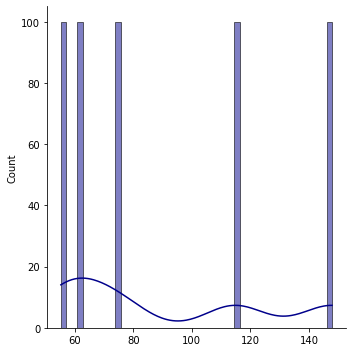

In [22]:
# plot for same
ll.density_plot(dfErrors['mae'])

In [24]:
#compute summary statistics for error for all 'buckets' - in this case artists
df_stats = pd.DataFrame(columns=('level','N', 'min', 'max', 'average', 'mode','variance','kurtosis','skew'))
i = 0
for level in simulator.rows:
    sError = simulator.calculate_errors_on_row(level)
    sReport, dftoss = calculate_summary_stats(sError)
    df_stats.loc[i] = [level,sReport.num, sReport.mn,sReport.mx,sReport.ave,sReport.md,sReport.sd,sReport.kurt,sReport.skew]
    i = i + 1
    if i > 20:  #todo: comment out and calculate all of it
        break
df_stats

,level,N,min,max,average,mode,variance,kurtosis,skew
0,Michael Jackson,36600,2.97,286.81,95.696202,24.62,46.030495,1.498575,0.925690
1,Lady Gaga,36600,1.98,340.34,57.113497,19.93,38.401476,21.257918,3.417599
2,Eminem,36600,0.99,1146.30,69.556694,28.72,80.496326,102.177893,8.798773
3,Justin Bieber,36600,0.99,383.99,90.482104,37.52,58.916610,4.276150,1.677945
4,Freddie Mercury,36600,3.96,225.75,76.188825,39.84,39.569310,1.503688,1.088262
5,Miley Cyrus,36600,0.99,196.40,34.349235,14.15,25.009925,10.312185,2.502438
6,Taylor Swift,36600,0.00,542.68,60.781120,2.97,58.081655,25.708318,4.277467
7,Lil Wayne,36600,0.00,212.98,31.354426,0.99,27.510277,9.849049,2.552727
8,Selena Gomez,36600,0.00,198.36,64.485738,49.46,38.310993,0.420771,0.755570
9,Rihanna,36600,1.98,118.08,36.994590,2.97,21.199926,0.761539,0.840188


In [ ]:
# TODO: save the statistics dataframe to a sortable csv to do feature priority analysis!